# **Iris prediction**

### **Import libraries**

In [4]:
%matplotlib inline
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import itertools
import io
import contextlib
import matplotlib
import imageio
from itertools import combinations, product
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    roc_auc_score
)

### **Backend**

In [5]:
# Main function 
def predictIris(path, f=np.pi, save=False, output_width=128, sigma=4.42):
    """
    An extended iris image processing function that detects the boundaries of the pupil and the iris,
    then unwraps the iris into a rectangular form and generates its code.
    The parameter f (frequency) is provided by the user – for example, f = pi.
    """
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    binary_image_pupil = binarize_image(gray_image, X=4.5)   

    binary_image_iris = binarize_image(gray_image, X=1.6)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        # create directory if it doesn't exist
        if not os.path.exists("found"):
            os.makedirs("found")
        
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
    print("############# UNWRAPPED IRIS #############")    
    unwrapped_iris = unwrap_iris(image_array, x_pupil, y_pupil, r_pupil, r_iris)
    show_image(unwrapped_iris)

    visualize_band_boundaries(unwrapped_iris)    

    bands = extract_central_bands(unwrapped_iris, output_width)
    visualize_bands(bands)

    print("############# COMPUTING IRIS CODE #############")
    iris_code = compute_full_iris_code(unwrapped_iris, f, num_bands=8, num_coeffs=128, output_width=output_width, sigma=sigma)
    print("Iris Code (binary):")
    print(iris_code)

    visualize_iris_code_by_band(iris_code, num_bands=8)
    
    return iris_code
    
   
# Show image    
def show_image(image_array):
    plt.figure(figsize=(4, 4))
    plt.imshow(image_array)
    plt.axis("off") 
    plt.show()
    
        
# Load image
def load_img(path):
    image = Image.open(path)
    image_array = np.array(image)
    #print("############# ORIGINAL EYE IMAGE #############")
    #show_image(image_array)
    return image_array
    
    
# Convert to grayscale
def convert_to_grayscale(image_array):
    gray_image = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.uint8)
    gray_image = np.mean(image_array, axis=2)
    gray_image = np.array(gray_image, dtype=np.uint8)
    print("############# GRAY IMAGE #############")
    show_image(np.dstack((gray_image, gray_image, gray_image)))
    return gray_image


# Binarize with threshold
def binarize_image(image_array, X):
    P = np.mean(image_array)
    threshold = P / X
    binary_image = np.zeros_like(image_array)
    binary_image[image_array > threshold] = 255
    #show_image(np.dstack((binary_image, binary_image, binary_image)))
    return binary_image


# Clean pupil image
def clean_pupil(binary_image):
    kernel = np.array([[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],], dtype=np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)   
    clean_image = binary_image.copy()
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
    clean_image = cv2.erode(clean_image, kernel, iterations=2)
    clean_image = cv2.dilate(clean_image, kernel_small, iterations=2)
    clean_image = cv2.medianBlur(clean_image, 5)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)
    return find_pupil(horizontal_projection, vertical_projection)


# Clean iris image
def clean_iris(binary_image):
    kernel_large = np.ones((10, 10), np.uint8)   
    kernel_medium = np.ones((5, 5), np.uint8)  
    kernel_small = np.ones((3, 3), np.uint8)  
    clean_image = binary_image.copy() 
    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=1)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=5)
    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=5)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.dilate(clean_image, kernel_large, iterations=1)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=10)
    clean_image = cv2.blur(clean_image, (5, 5), 0)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel_large)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)   
    return find_iris(horizontal_projection, vertical_projection) 


# Keep largest object
def keep_largest_object(binary_image):
    inverted_image = cv2.bitwise_not(binary_image)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(inverted_image, connectivity=8)

    if num_labels == 1:
        return binary_image
    
    largest_label = 1 + np.argmax(stats[1:, 4])

    largest_object = np.zeros_like(binary_image, dtype=np.uint8)
    largest_object[labels == largest_label] = 255  

    return cv2.bitwise_not(largest_object)


# Show projections
def show_projections(clean_image, binary_image):
    horizontal_projection = np.sum(clean_image, axis=1)  
    vertical_projection = np.sum(clean_image, axis=0)   
    height, width = clean_image.shape
    _, axs = plt.subplots(2, 2, figsize=(10, 6))
    axs[0, 0].imshow(np.dstack((clean_image, clean_image, clean_image)))
    axs[0, 0].set_title("Binary Image after Morphology")
    axs[0, 0].axis("off")
    axs[1, 1].axis("off")
    rect = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[0, 0].add_patch(rect)
    axs[0, 1].plot(horizontal_projection, range(height), color='blue', linewidth=2)
    axs[0, 1].set_title("Horizontal Projection")
    axs[0, 1].set_ylim(height, 0)  
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].plot(range(width), vertical_projection, color='red', linewidth=2)
    axs[1, 0].set_title("Vertical Projection")
    axs[1, 0].set_xlim(0, width)  
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    axs[1, 1].imshow(np.dstack((binary_image, binary_image, binary_image)))
    axs[1, 1].set_title("Binary Image")
    rect2 = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[1, 1].add_patch(rect2)
    plt.tight_layout()
    plt.show()
    return horizontal_projection, vertical_projection


# Find pupil
def find_pupil(horizontal_projection, vertical_projection):
    y_pupil = int(np.median(np.where(horizontal_projection == np.min(horizontal_projection))[0]))
    x_pupil = int(np.median(np.where(vertical_projection == np.min(vertical_projection))[0]))

    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))
    
    pupil_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.3)[0]
    pupil_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.3)[0]
    if len(pupil_edges_y) > 1:
        r_pupil_y = (pupil_edges_y[-1] - pupil_edges_y[0]) // 2
    else:
        r_pupil_y = 0
    if len(pupil_edges_x) > 1:
        r_pupil_x = (pupil_edges_x[-1] - pupil_edges_x[0]) // 2
    else:
        r_pupil_x = 0 
    r_pupil = (r_pupil_x + r_pupil_y) // 2
    return (x_pupil, y_pupil, r_pupil)


# Find iris
def find_iris(horizontal_projection, vertical_projection):
    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))

    iris_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.4)[0]
    iris_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.4)[0]

    if len(iris_edges_y) > 1:
        r_iris_y = (iris_edges_y[-1] - iris_edges_y[0]) // 2
    else:
        r_iris_y = 0

    if len(iris_edges_x) > 1:
        r_iris_x = (iris_edges_x[-1] - iris_edges_x[0]) // 2
    else:
        r_iris_x = 0 

    r_iris = (3 * r_iris_x + r_iris_y) // 4

    return r_iris


# Draw found iris and pupil
def draw_circle(image_array, x, y, r):
    image_with_circle = image_array.copy()
    image_with_circle = cv2.circle(image_with_circle, (x, y), r, (255, 0, 0), 1)
    return image_with_circle

# Unwrap iris
def unwrap_iris(image, x_pupil, y_pupil, r_pupil, r_iris, output_shape=(64, 360), angle_offset=270):
    """
    Unwraps the detected iris into a rectangular form according to the description of the pseudo-polar coordinate system.
    A linear radial transformation was used: r_norm ∈ [0, 1]
    """
    height, width = output_shape
    offset_rad = np.deg2rad(angle_offset)
    theta = np.linspace(0, 2 * np.pi, width, endpoint=False) + offset_rad  
    r_norm = np.linspace(0, 1, height)  # [0 - źrenica], [1 - zewn. kontur]

    r_grid, theta_grid = np.meshgrid(r_norm, theta, indexing='ij')
    r_actual = r_pupil + r_grid * (r_iris - r_pupil)
    x_grid = (x_pupil + r_actual * np.cos(theta_grid)).astype(int)
    y_grid = (y_pupil + r_actual * np.sin(theta_grid)).astype(int)

    x_grid = np.clip(x_grid, 0, image.shape[1] - 1)
    y_grid = np.clip(y_grid, 0, image.shape[0] - 1)

    unwrapped_iris = image[y_grid, x_grid]
    return unwrapped_iris


def compute_1d_representation(band, sigma):
    """
    For a given iris strip, the function computes a one-dimensional signal by averaging the rows 
    using a Gaussian window.

    This way, the weight assigned to each row decreases with distance from the center of the image,
    and the resulting 1D signal (for each column) effectively represents the central part of the iris strip.
    """
    h, _, _ = band.shape
    band_gray = band.mean(axis=2) 
    
    center = h / 2.0
    
    y = np.arange(h)
    weights = np.exp(-((y - center) ** 2) / (2 * sigma ** 2))
    weights = weights / np.sum(weights) 
    
    signal = np.sum(band_gray * weights[:, np.newaxis], axis=0)
    
    return signal


# Function for calculating 1-dimensional Gabor coefficients for a signal
def compute_gabor_coefficients(signal, f, num_coeffs=128):
    """
    For a one-dimensional signal I(x), the function calculates the coefficients of the Gabor expansion.
    We assume:
    c_k = sum_{i=0}^{L-1} I[i] * exp(-((i - x_k)^2)/(sigma^2)) * exp(-i2π f i)
    where sigma = 1 / (2πf), and x_k are the centers of the wavelets, chosen uniformly (num_coeffs elements).
    """
    L = len(signal)
    centers = np.linspace(0, L - 1, num_coeffs)
    sigma = 1/2 * np.pi * f
    coeffs = []
    indices = np.arange(L)
    for x0 in centers:
        gaussian_window = np.exp(-((indices - x0) ** 2) / (sigma ** 2))
        modulation = np.exp(-1j * 2 * np.pi * f * (indices - x0)) 
        c = np.sum(signal * gaussian_window * modulation)
        coeffs.append(c)
    return np.array(coeffs)


# Function that encodes a single coefficient based on its phase (argument)
def encode_coefficient(c):
    """
    Encodes the coefficient c (a complex number) into a 2-bit sequence based on its phase:
    - Phase in [0, π/2)   -> "00"
    - Phase in [π/2, π]   -> "01"
    - Phase in (-π, -π/2] -> "11"
    - Phase in (-π/2, 0)  -> "10"
    """
    angle = np.angle(c) 
    if 0 <= angle < np.pi / 2:
        return "00"
    elif np.pi / 2 <= angle <= np.pi:
        return "01"
    elif -np.pi <= angle <= -np.pi / 2:
        return "11"
    elif -np.pi / 2 < angle < 0:
        return "10"
    else:
        return "00"  


# Function that computes the code for a single iris strip
def compute_band_iris_code(band, f, num_coeffs=128, sigma = 4.42):
    """
    For a single (2D) iris strip:
    1. Compute a one-dimensional representation (column-wise averaging using a Gaussian window).
    2. Calculate num_coeffs Gabor coefficients using a fixed frequency f.
    3. Encode each coefficient into a 2-bit sequence.
    The returned result is a bit string of length 2 * num_coeffs.
    """
    signal = compute_1d_representation(band, sigma)
    coeffs = compute_gabor_coefficients(signal, f, num_coeffs)
    band_code = "".join(encode_coefficient(c) for c in coeffs)
    return band_code


# Function that assembles the code from the entire iris (divided into num_bands strips)
def compute_full_iris_code(unwrapped_iris, f, num_bands=8, num_coeffs=128, output_width=128, sigma = 4.42):
    """
    The entire iris code is computed as follows:
    1. From the unwrapped iris image, we extract 8 central strips,
        each of constant width (output_width), to ensure consistency.
    2. For each strip, we calculate a 2-bit code (using the Gabor transform).
    3. We concatenate the results for the individual strips.
    The returned bit string has a length of num_bands * (2 * num_coeffs).
    """
    bands = extract_central_bands(unwrapped_iris, output_width)
    full_code = ""
    for band in bands:
        band_code = compute_band_iris_code(band, f, num_coeffs, sigma)
        full_code += band_code
    return full_code


def visualize_iris_code_by_band(iris_code: str, num_bands: int = 8):
    """
    Visualizes the iris code as a black-and-white image, where:
    - each of the 8 rows corresponds to one strip,
    - columns represent consecutive bits of a given strip.

    Parameters:
    iris_code  - a bit string (e.g., "010101...") representing the iris code
    num_bands  - the number of strips (default is 8)
    """
    total_bits = len(iris_code)
    if total_bits % num_bands != 0:
        raise ValueError("The length of the code is not divisible by the number of strips.")
    
    bits_per_band = total_bits // num_bands
    arr = np.zeros((num_bands, bits_per_band), dtype=np.uint8)
    
    for band_index in range(num_bands):
        start = band_index * bits_per_band
        stop = (band_index + 1) * bits_per_band
        segment = iris_code[start:stop]
        
        # '1' → 1 (black), '0' → 0 (white)
        for i, bit in enumerate(segment):
            arr[band_index, i] = 1 if bit == '1' else 0

    plt.figure(figsize=(bits_per_band/16, num_bands/3))
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1, aspect='auto')
    plt.axis('off') 
    plt.show()


def extract_central_bands(unwrapped_iris, output_width: int, vertical_crop_ratio: float = 1.0):
    """
    Extracts 8 concentric segments of the iris ring.

    • First, the central portion is preserved (vertical_crop_ratio).
    • The ring is divided into 8 equal radial strips.
    • For each strip, an azimuthal segment is applied:
    - Strips 0-3 → 330°
    - Strips 4-5 → 226°
    - Strips 6-7 → 180°
    We assume the unwrap is performed with angle_offset=270°, so column 0 corresponds to the 270° angle.
    """
    if unwrapped_iris.ndim == 3:
        H, W, _ = unwrapped_iris.shape
    else:
        H, W = unwrapped_iris.shape

    top = int((1 - vertical_crop_ratio) / 2 * H)
    bottom = H - top
    roi = unwrapped_iris[top:bottom]
    Hc = roi.shape[0]
    band_h = Hc // 8

    spans = [330, 330, 330, 330, 226, 226, 180, 180]  
    center_x = W // 2
    bands = []
    for i in range(8):
        band = roi[i * band_h : (i + 1) * band_h]
        span = spans[i]
        crop_w = int(round(span / 360 * W))
        x0 = center_x - crop_w // 2
        x1 = x0 + crop_w
        band_cropped = band[:, x0:x1]
        band_resized = cv2.resize(band_cropped, (output_width, band_cropped.shape[0]), interpolation=cv2.INTER_LINEAR)
        bands.append(band_resized)
    return bands


def visualize_bands(bands):
    """
    Stitches together 8 horizontal strips (images) and displays the result.
    Each strip corresponds to a horizontal segment of the unwrapped iris.
    """
    min_height = min(band.shape[0] for band in bands)
    bands_equal = [band[:min_height, :] for band in bands]
    
    stacked = np.vstack(bands_equal)

    plt.figure(figsize=(stacked.shape[1] / 50, stacked.shape[0] / 50))
    plt.imshow(stacked, cmap='gray', aspect='auto')
    plt.title("Extracted Horizontal Iris Strips")
    plt.axis('off')
    plt.show()


def visualize_band_boundaries(unwrapped_iris, vertical_crop_ratio=1):
    """
    On the unwrapped iris image, overlays markings showing:
    1. Vertical boundaries of the central region (cutting off the top and bottom parts, e.g., eyelids).
    2. Horizontal division of the central region into 8 equal strips.
    3. Within each strip – vertical boundaries of the horizontal segment,
        corresponding to the angular range (different for strips 1-4, 5-6, and 7-8).

    Parameters:
    unwrapped_iris      - the unwrapped iris image (e.g., grayscale or color),
                            where the full width corresponds to 360°.
    vertical_crop_ratio - the ratio of the central region's height to the full image height.
    """
    h, w = unwrapped_iris.shape[:2]
    
    crop_top = int((1.0 - vertical_crop_ratio) / 2 * h)
    crop_bottom = h - crop_top
    central_region = unwrapped_iris[crop_top:crop_bottom, :]
    new_h, new_w = central_region.shape[:2] 
    
    num_bands = 8
    band_height = new_h / num_bands
    
    plt.figure(figsize=(w/50, h/50))
    plt.imshow(unwrapped_iris, cmap='gray', aspect='auto')
    
    plt.axhline(y=crop_top, color='cyan', linestyle='-', linewidth=2, label='Central region')
    plt.axhline(y=crop_bottom, color='cyan', linestyle='-', linewidth=2)
    
    for i in range(1, num_bands):
        y_line = crop_top + i * band_height
        plt.axhline(y=y_line, color='red', linestyle='--', linewidth=2)
    
    center_x = new_w // 2
    for i in range(num_bands):
        y0 = crop_top + i * band_height
        y1 = y0 + band_height
        
        if i  >= 4:
            angular_span = 330.0
        elif i  >= 2:
            angular_span = 226.0
        else:
            angular_span = 180.0
        
        crop_width = int(round(angular_span / 360.0 * new_w))
        x0 = center_x - crop_width // 2
        x1 = x0 + crop_width

        plt.axvline(x=x0, ymin=(y0/h), ymax=(y1/h), color='yellow', linestyle='-.', linewidth=2)
        plt.axvline(x=x1, ymin=(y0/h), ymax=(y1/h), color='yellow', linestyle='-.', linewidth=2)
    
    plt.title("Boundaries of the central region and cropped segments of the iris strips")
    plt.axis('off')
    plt.show()


def hamming_distance_np(code1: str, code2: str) -> float:
    """
    This function first converts the strings into arrays of integers and then computes the distance.
    """
    if len(code1) != len(code2):
        raise ValueError("The codes must have the same length")
    
    arr1 = np.array([int(b) for b in code1])
    arr2 = np.array([int(b) for b in code2])
    diff = np.sum(arr1 != arr2)
    return diff / len(code1)


def compare_within_person(person_id, eye, f_value, verbose=False, plot_histogram=True, sigma=4.42):
    with silent_mode(active=not verbose):
        codes = {}
        for n in range(1, 6):
            path = f"data/eye_p{person_id:02d}_{eye}{n}.bmp"
            codes[n] = predictIris(path, f=f_value, sigma=sigma)

        distances = [
            hamming_distance_np(c1, c2)
            for (_, c1), (_, c2) in itertools.combinations(codes.items(), 2)
        ]
    
    if plot_histogram:
        plt.figure(figsize=(8, 6))
        plt.hist(distances, bins=10, edgecolor='black')
        plt.title(f"Hamming distances between images of person {person_id} (no rotation)")
        plt.xlabel("Hamming distance")
        plt.ylabel("Count")
        plt.grid(alpha=.6)
        plt.show()

    return distances


def compare_within_persons_range(person_ids, eye, f_value, verbose=False, skip_ids=None, sigma=4.42):
    """
    For each person in person_ids (excluding skip_ids), it calls compare_within_person with the plot disabled,
    collects all distances, and draws a combined histogram.
    """
    if skip_ids is None:
        skip_ids = []
    filtered_ids = [pid for pid in person_ids if pid not in skip_ids]

    all_distances = []
    for pid in filtered_ids:
        if verbose:
            print(f"Processing person {pid}")
        d = compare_within_person(pid, eye, f_value,
                                              verbose=verbose,
                                              plot_histogram=False,
                                              sigma=sigma)
        all_distances.extend(d)

    plt.figure(figsize=(10, 6))
    plt.hist(all_distances, bins=30, edgecolor='black')
    plt.title(f"Intra-person Hamming distances")
    plt.xlabel("Hamming Distance")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return all_distances


def compare_people_multiple(person_ids, eye, f_value, verbose=False, plot_histogram=True, sigma=4.42):
    """
    Compares the codes between all pairs of different people in person_ids.
    Returns a list of Hamming distances (minimum after rotations) and optionally a histogram.
    """
    with silent_mode(active=not verbose):
        iris_codes = {}
        for pid in person_ids:
            if verbose:
                print(f"Loading person {pid}")
            codes = [predictIris(f"data/eye_p{pid:02d}_{eye}{n}.bmp",
                                 f=f_value, sigma=sigma)
                     for n in range(1, 6)]
            iris_codes[pid] = codes

        distances = []
        for p1, p2 in itertools.combinations(person_ids, 2):
            if verbose:
                print(f"Comparing {p1} vs {p2}")
            for c1 in iris_codes[p1]:
                for c2 in iris_codes[p2]:
                    distances.append(hamming_distance_np(c1, c2))

    if plot_histogram:
        plt.figure(figsize=(10, 6))
        plt.hist(distances, bins=30, edgecolor='black')
        plt.title(f"Cross-person Hamming distances")
        plt.xlabel("Hamming Distance")
        plt.ylabel("Count")
        plt.grid(alpha=0.5)
        plt.show()

    return distances


def compare_two_images(person_id1, eye1, index1,
                       person_id2=None, eye2=None, index2=None,
                       f_value=np.pi, sigma=4.42, threshold=0.3219,
                       verbose=True):
    """
    Compares two iris codes:
    - If you provide only person_id1, eye1, index1, and index2,
        it compares two images of the same person.
    - If you also provide person_id2 and eye2,
        it compares images from two different people.

    Arguments:
    person_id1 (int): ID of the first person (e.g., 14)
    eye1 (str): "left" or "right" for the first person
    index1 (int): image number (1-5) for the first person

    person_id2 (int or None): ID of the second person; if None, uses person_id1
    eye2 (str or None): "left" or "right" for the second person; if None, uses eye1
    index2 (int or None): image number (1-5) for the second person; if None, must be provided

    f_value (float): parameter for the predictIris function
    sigma (float): sigma of the Gaussian window
    threshold (float): Hamming distance threshold

    Returns:
    dist (float): Hamming distance between the codes
    """

    if person_id2 is None:
        person_id2, eye2 = person_id1, eye1
    if eye2 is None:
        eye2 = eye1
    if index2 is None:
        raise ValueError("You must provide index2 (the number of the second image)")

    path1 = f"data/eye_p{person_id1:02d}_{eye1}{index1}.bmp"
    path2 = f"data/eye_p{person_id2:02d}_{eye2}{index2}.bmp"

    img1 = imageio.imread(path1)
    img2 = imageio.imread(path2)

    with silent_mode(active=True):
        code1 = predictIris(path1, f=f_value, sigma=sigma)
        code2 = predictIris(path2, f=f_value, sigma=sigma)

    dist = hamming_distance_np(code1, code2)

    if verbose:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img1, cmap='gray')
        axes[0].set_title(f"P{person_id1}-{eye1} img {index1}")
        axes[0].axis('off')
        axes[1].imshow(img2, cmap='gray')
        axes[1].set_title(f"P{person_id2}-{eye2} img {index2}")
        axes[1].axis('off')
        plt.suptitle(f"Hamming distance: {dist:.4f}")
        plt.tight_layout()
        plt.show()

        msg = "✅ Iris match!" if dist <= threshold else "❌ Iris mismatch!"
        print(msg)
        print(f"Hamming distance: {dist:.4f}")

    return dist


@contextlib.contextmanager
def silent_mode(active: bool = True, close_figs: bool = True):
    """
    • If active == True - suppresses all print statements *and* blocks plot display.
    • If active == False - does not change anything.
    """
    if not active:
        yield
        return

    null_out = io.StringIO()
    cm_stdout = contextlib.redirect_stdout(null_out)
    cm_stderr = contextlib.redirect_stderr(null_out)

    old_backend = matplotlib.get_backend()
    old_show = plt.show
    matplotlib.use('Agg', force=True)
    plt.show = lambda *a, **kw: None

    try:
        with cm_stdout, cm_stderr:
            yield
    finally:
        plt.show = old_show
        matplotlib.use(old_backend, force=True)
        if close_figs:
            plt.close('all')

### **Example of use**

############# GRAY IMAGE #############


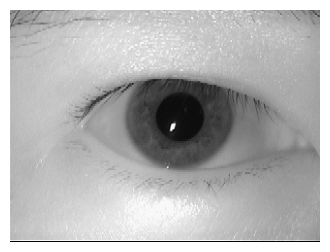

############# PUPIL EXTRACTED #############


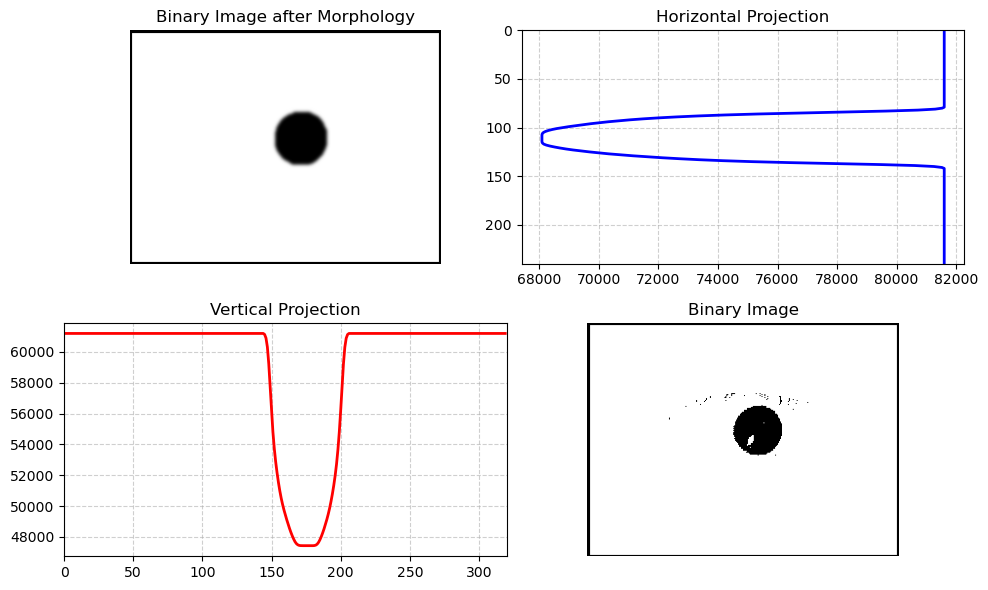

############# IRIS EXTRACTED #############


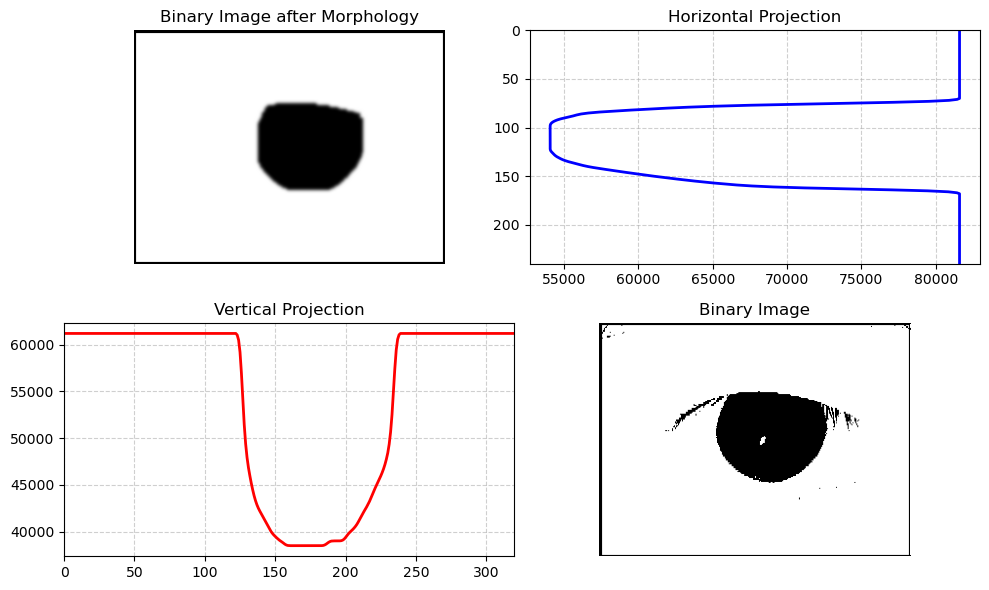

############# FOUND PUPIL AND IRIS #############


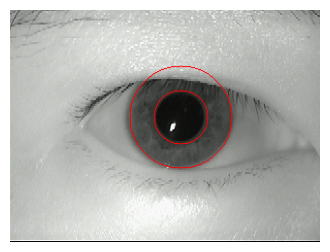

Image saved to found\eye_p42_right3.bmp_found.bmp
############# UNWRAPPED IRIS #############


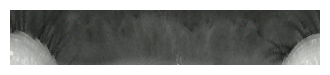

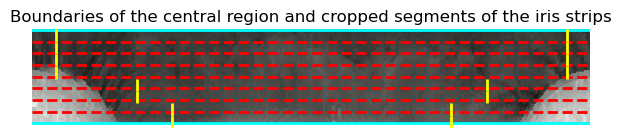

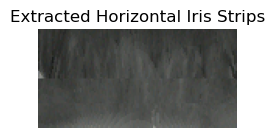

############# COMPUTING IRIS CODE #############
Iris Code (binary):
10100000010111100000111010000001011111101010000000000000011110101000000111101010000001011110100000010111111010000000010110101010100000000000000011101000000111101010000000000001101000000111101000000001000000001110100000001110101010101010100000011110101000001010000001111110000001000000010101111110101000000000000101111010000000010010101000000111101010100000010111101010000000010111101000000000000000011110100000011110100000011110101010100000000111111010000010100000011111101010101000000001011110101000011110100000101000000111100001111110100000010111111010000001111110100010100000011111101000000101111010000001111010101010100000000001011111101000000111101000000101011111111010000001111010000001011110100000000111111010100000010111111010000001101010000000010111111010000010100000010111111110101000000101111110101000000111101000000111101000011110101000000110000001011110101000000111101000000111111010100000000111101000000001100000011110

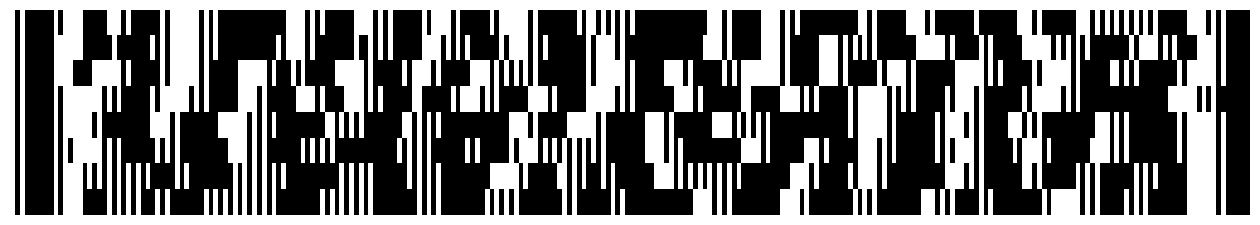

In [6]:
person_id = 42
eye = 'right'
photo_number = 3
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

irisCode = predictIris(path, f = np.pi, sigma=4.42, save=True)  

### **Comparison of iris codes of different people using Hamming distance**

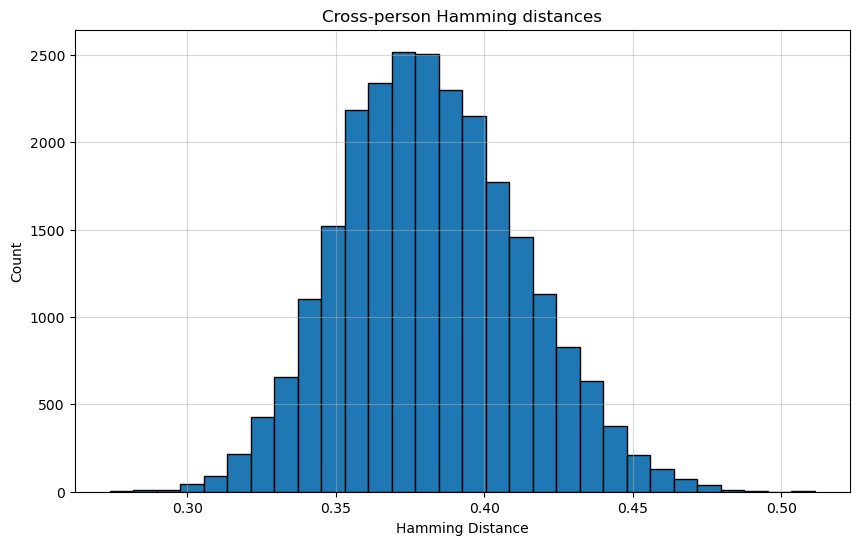

In [7]:
distances_left = compare_people_multiple(
    person_ids=[x for x in range(1, 47) if x != 4],
    eye="left",
    f_value=np.pi,
    verbose=False,
    sigma=4.42
)

In [8]:
mean_left = np.mean(distances_left)
mean_left

0.38229217960858586

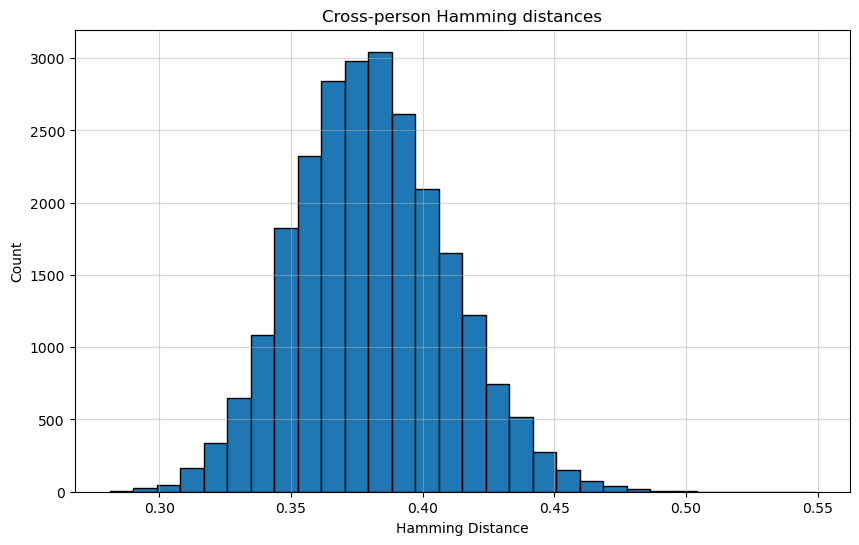

In [9]:
distances_right = compare_people_multiple(
    person_ids=[x for x in range(1, 47) if x != 4],
    eye="right",
    f_value=np.pi,
    verbose=False,
    sigma=4.42
)

In [10]:
mean_right = np.mean(distances_right)
mean_right

0.38064113794191917

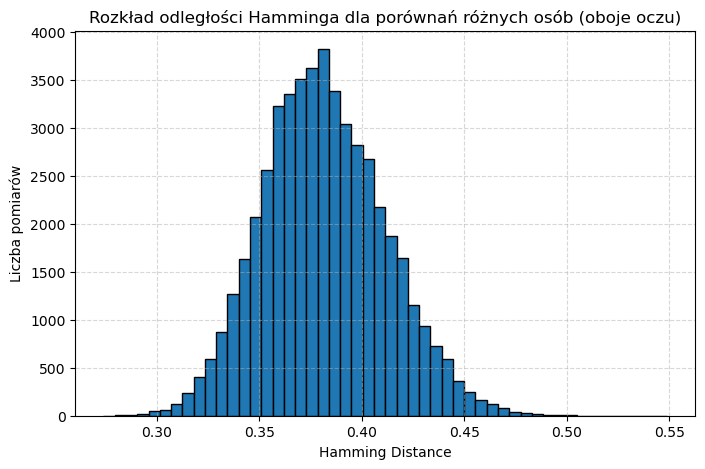

(0.38146665877525254, 0.02976390360606778, 0.3798828125)

In [11]:
all_distances = np.concatenate([distances_left, distances_right])

# Narysuj histogram
plt.figure(figsize=(8,5))
plt.hist(all_distances, bins=50, edgecolor='black')
plt.title("Rozkład odległości Hamminga dla porównań różnych osób (oboje oczu)")
plt.xlabel("Hamming Distance")
plt.ylabel("Liczba pomiarów")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

np.mean(all_distances), np.std(all_distances), np.median(all_distances)

In [12]:
np.mean(all_distances) - 2 * np.std(all_distances)

0.32193885156311697

### **Comparison of iris codes of the same person using Hamming distance**

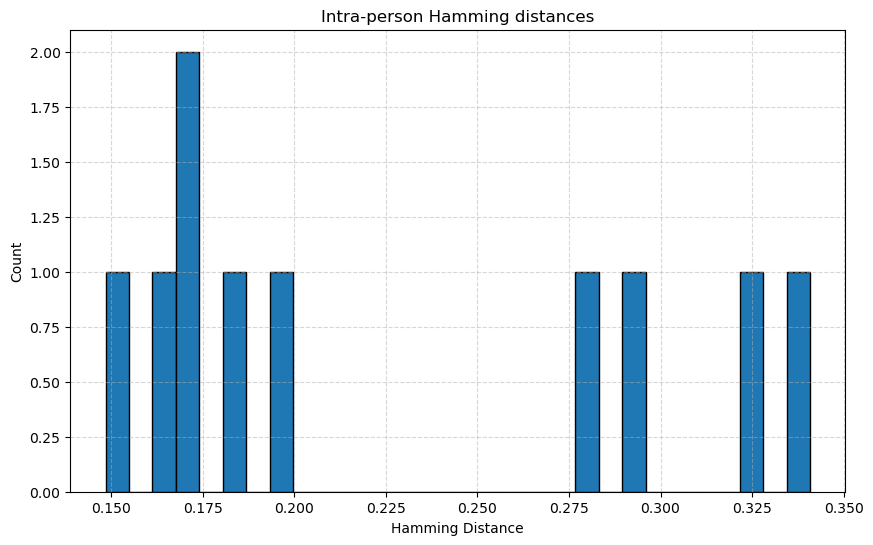

In [ ]:
all_dist = compare_within_persons_range(
    person_ids=[42],
    eye="left",
    f_value=np.pi,
    verbose=False,
    sigma=4.42
)

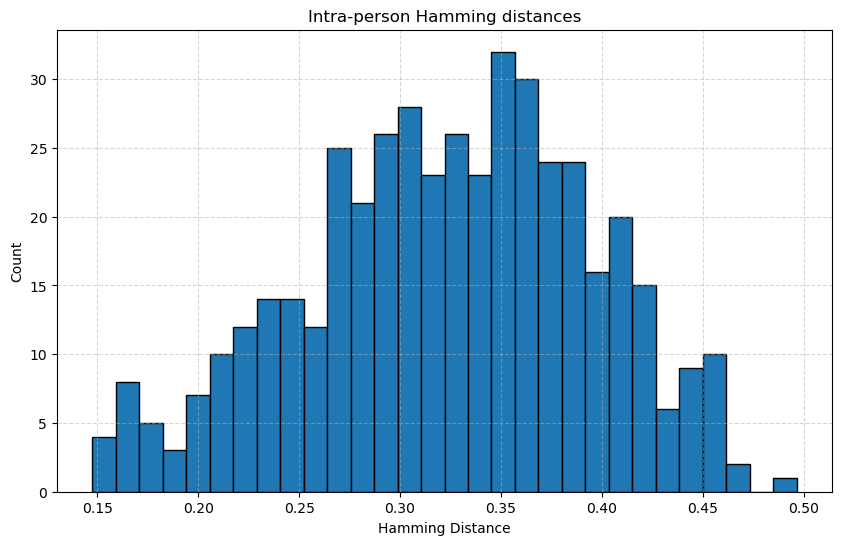

In [14]:
left_dists = compare_within_persons_range(
    person_ids=list(range(1, 47)),
    eye="left",
    f_value=np.pi,
    verbose=False,
    skip_ids=[4],
    sigma=4.42
)

In [15]:
np.mean(left_dists)

0.3235763888888889

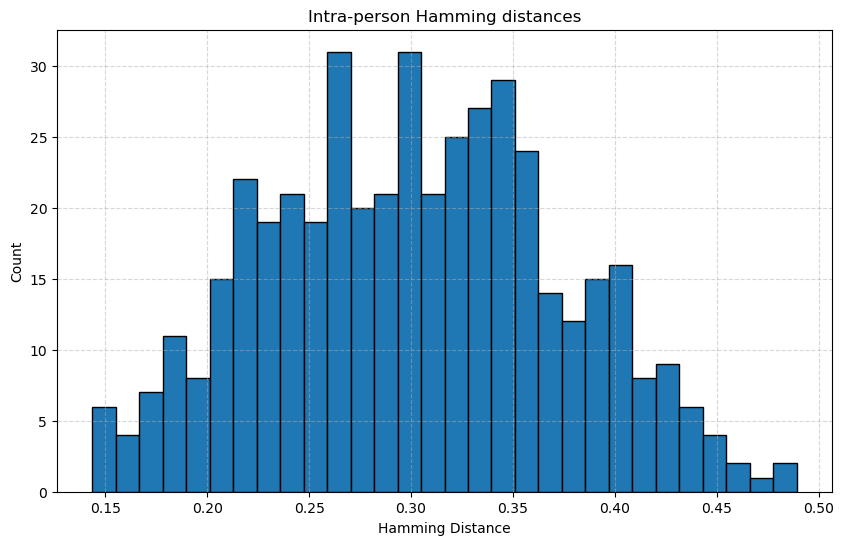

In [16]:
right_dists = compare_within_persons_range(
    person_ids=list(range(1, 47)),
    eye="right",
    f_value=np.pi,
    verbose=False,
    skip_ids=[4],
    sigma=4.42
)

In [17]:
np.mean(right_dists)

0.3016189236111111

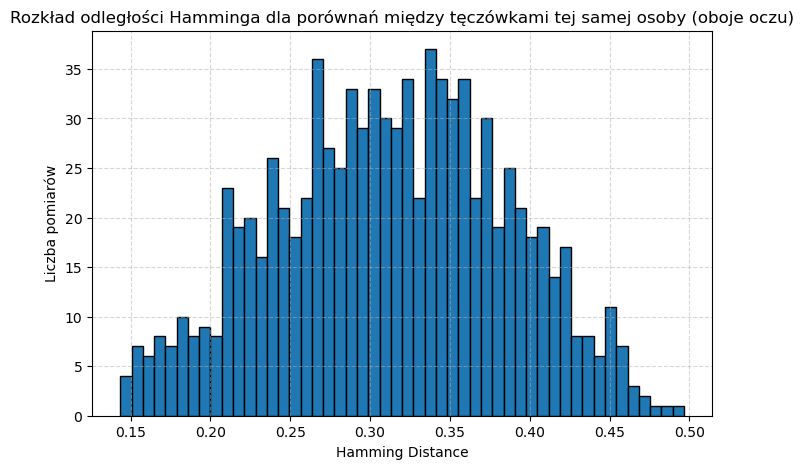

(0.31259765625, 0.07245596896923, 0.315185546875)

In [18]:
all_dists = np.concatenate([left_dists, right_dists])

plt.figure(figsize=(8,5))
plt.hist(all_dists, bins=50, edgecolor='black')
plt.title("Rozkład odległości Hamminga dla porównań między tęczówkami tej samej osoby (oboje oczu)")
plt.xlabel("Hamming Distance")
plt.ylabel("Liczba pomiarów")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

np.mean(all_dists), np.std(all_dists), np.median(all_dists)

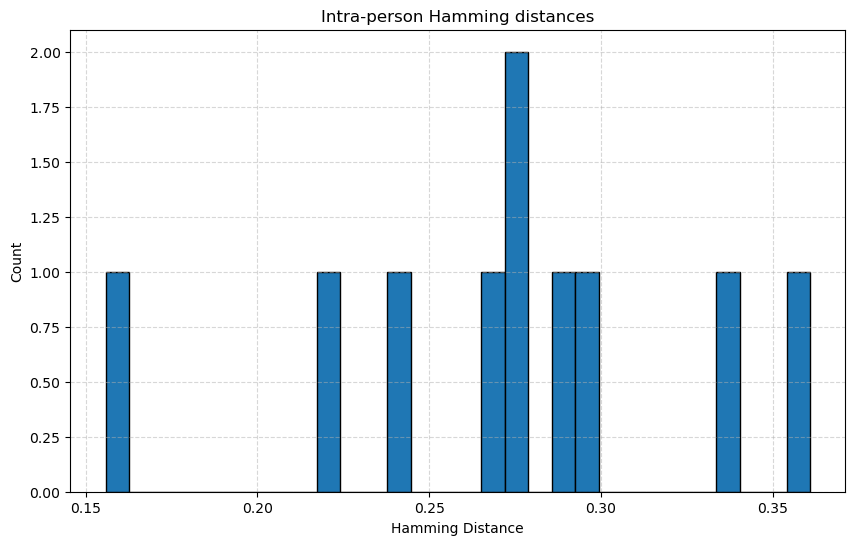

In [19]:
all_dist = compare_within_persons_range(
    person_ids= [14],
    eye="right",
    f_value=np.pi,
    verbose=False,
    sigma = 4.42
)

### **Optimization**

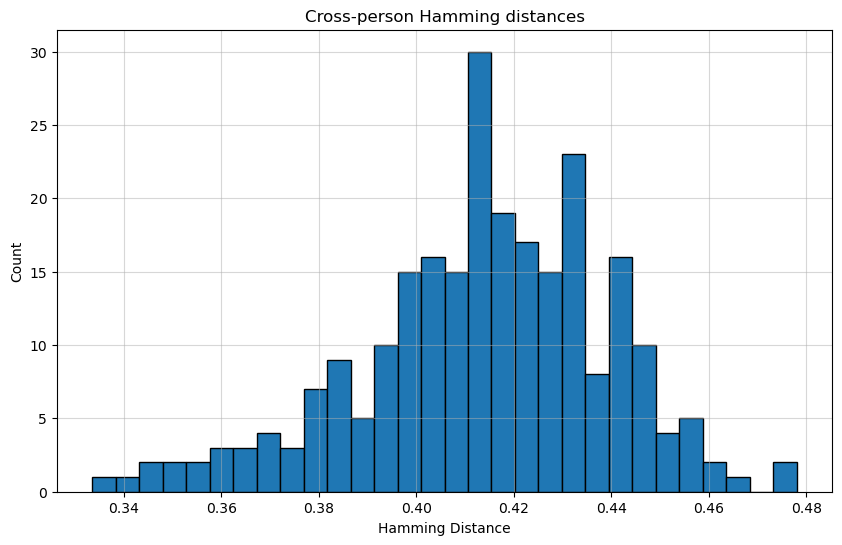

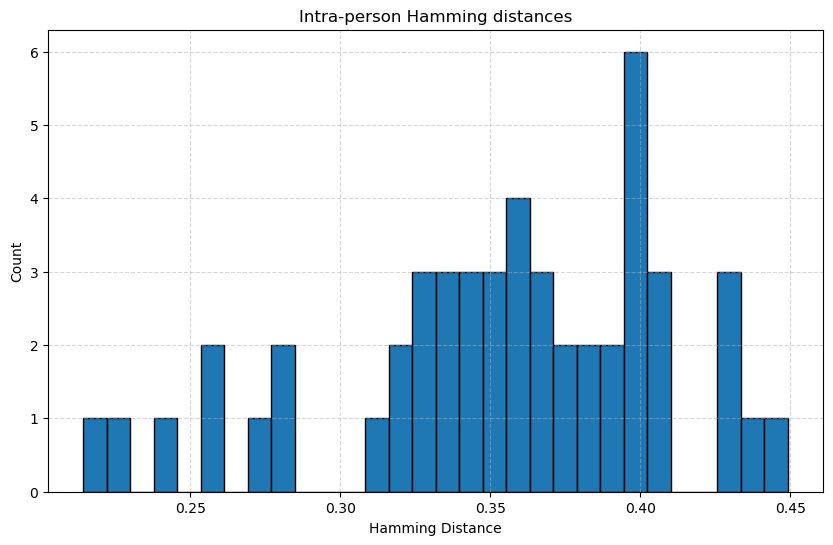

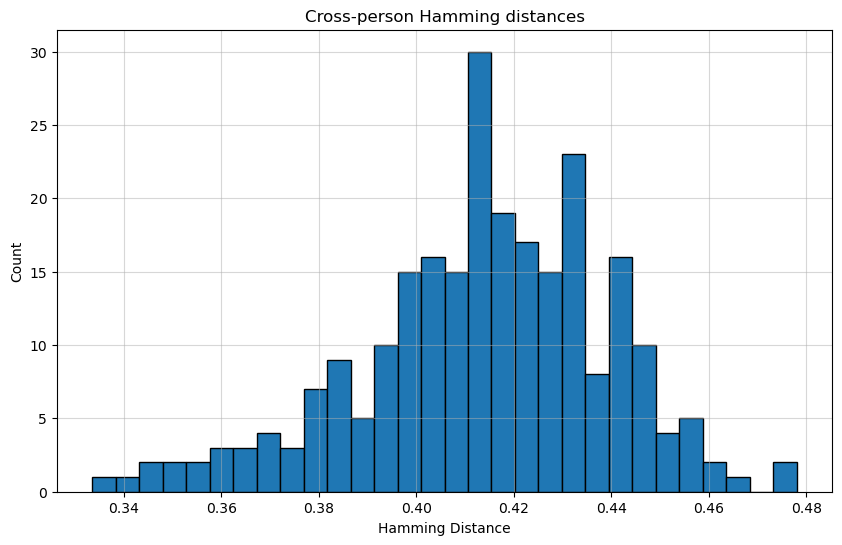

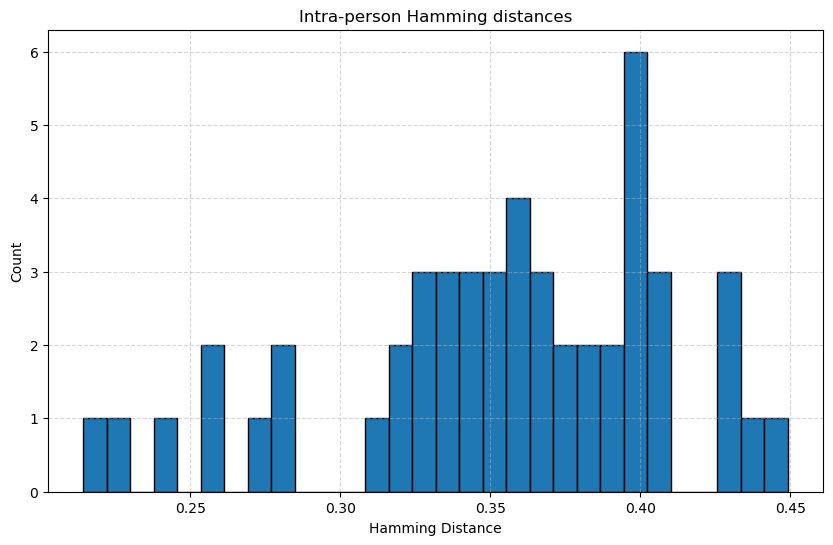

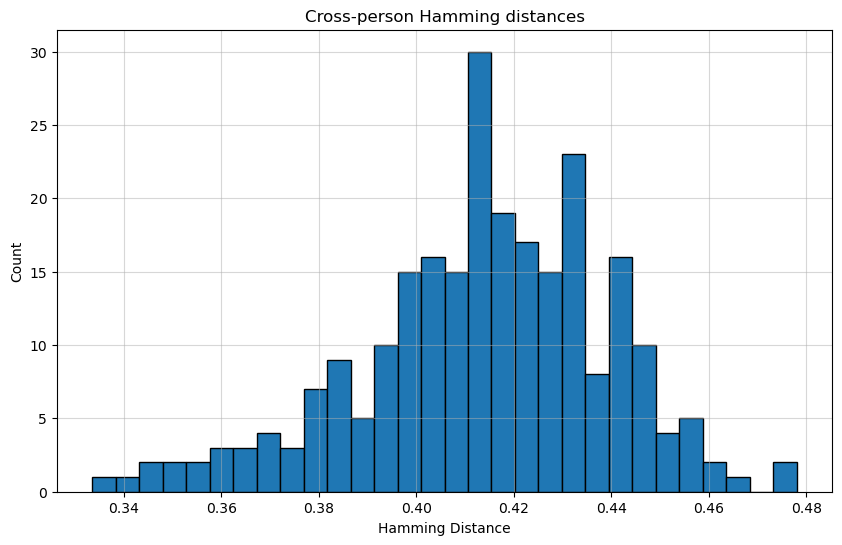

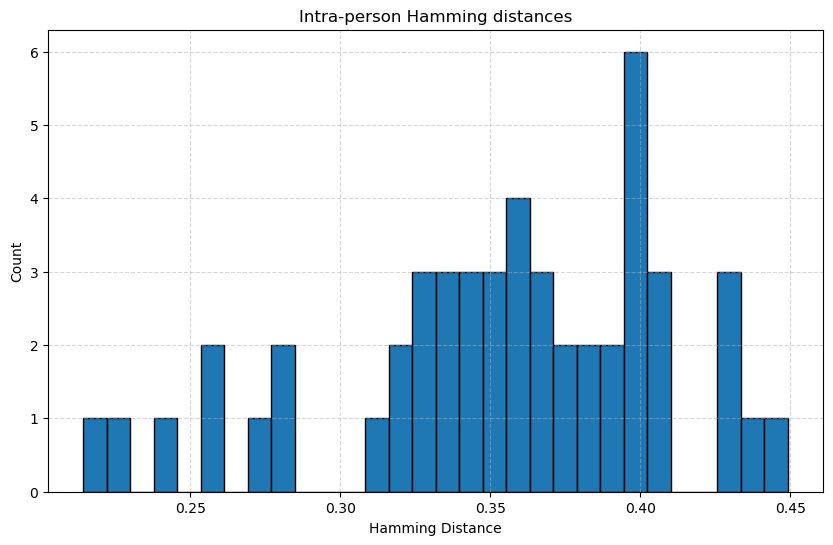

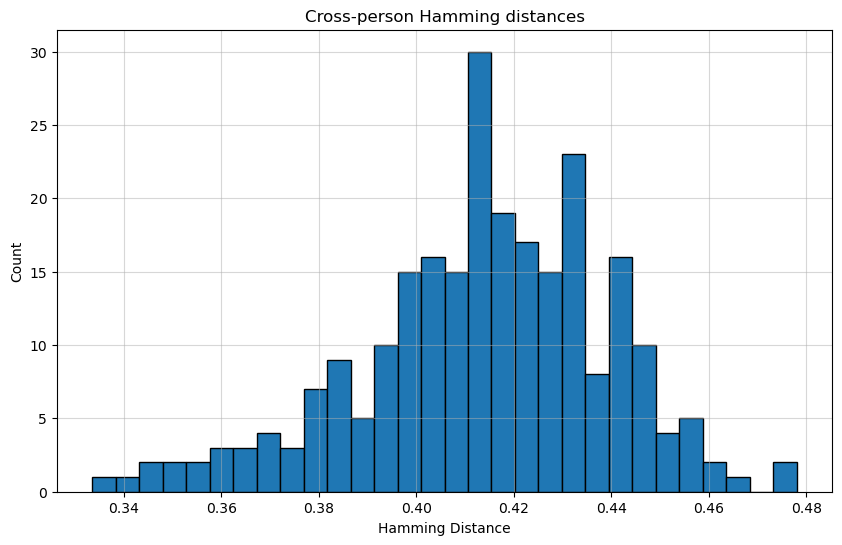

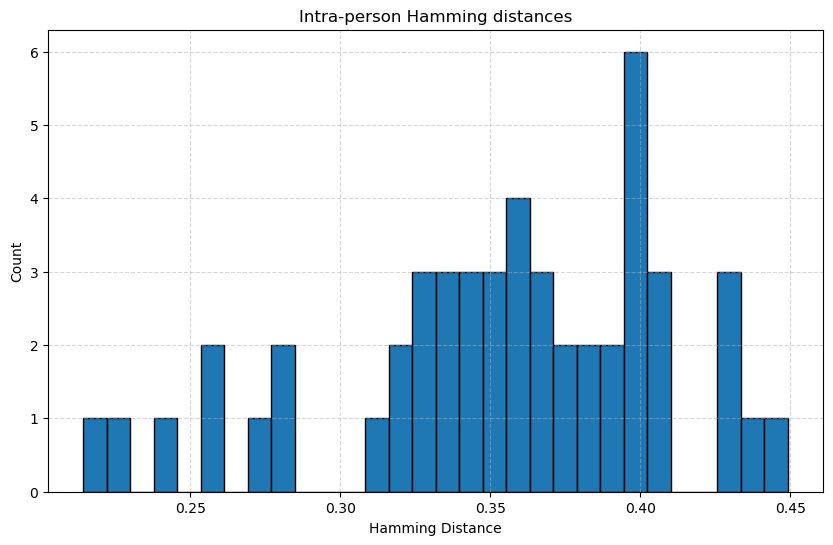

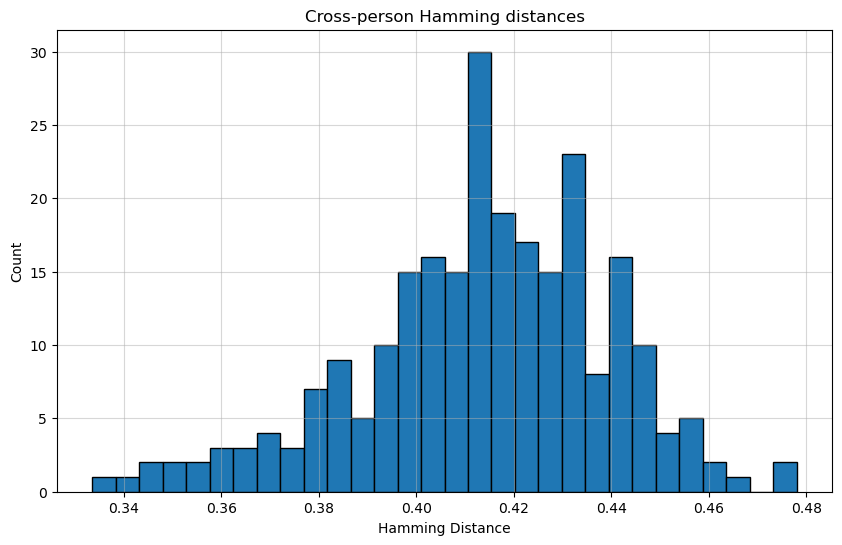

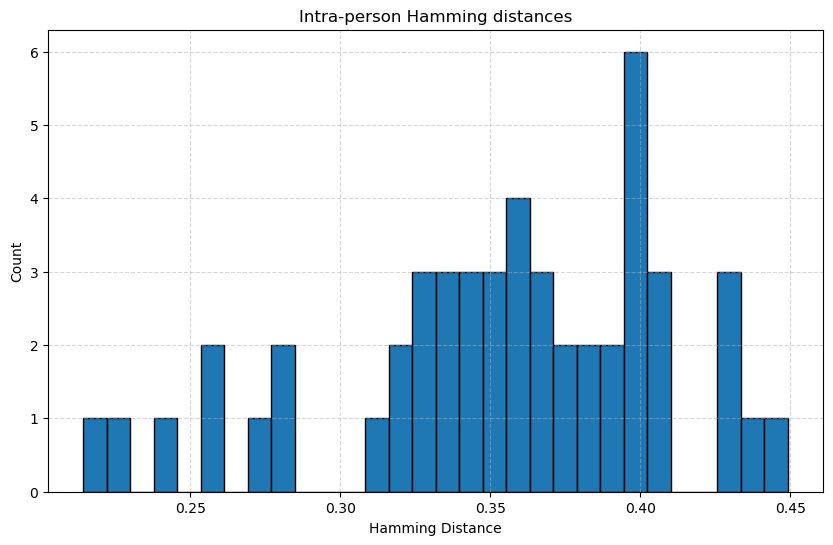

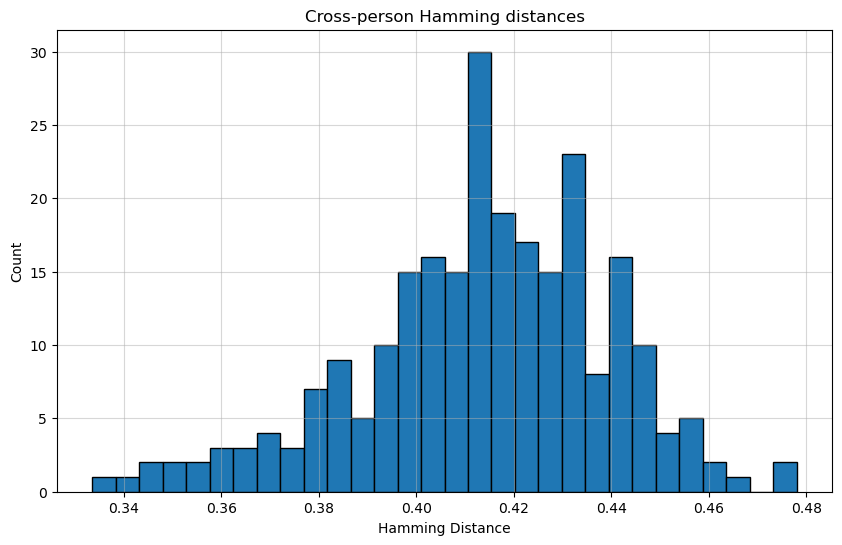

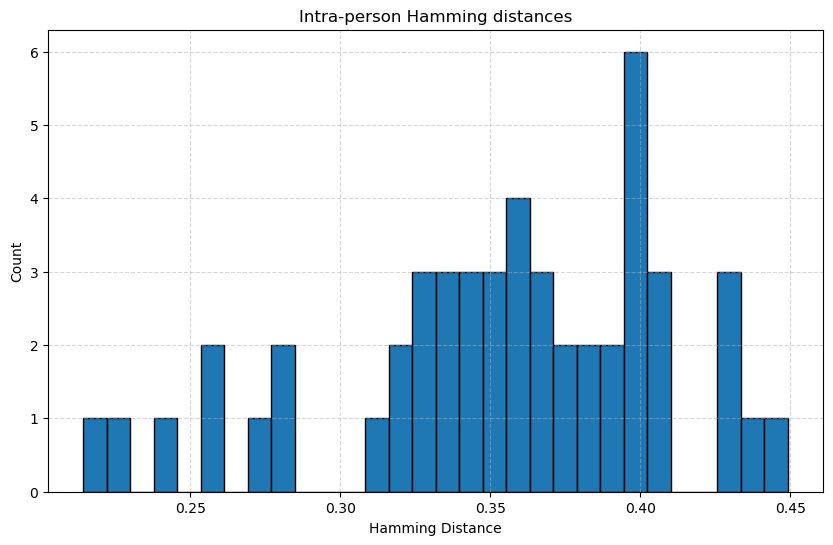

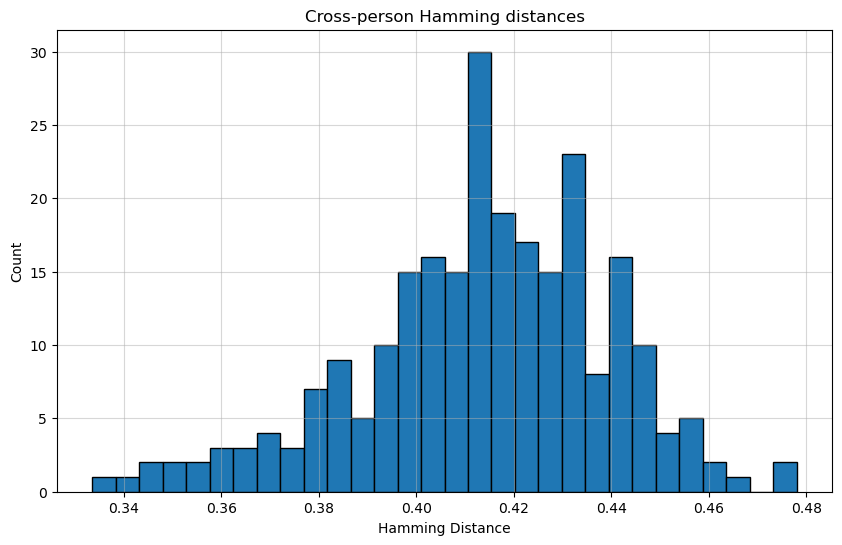

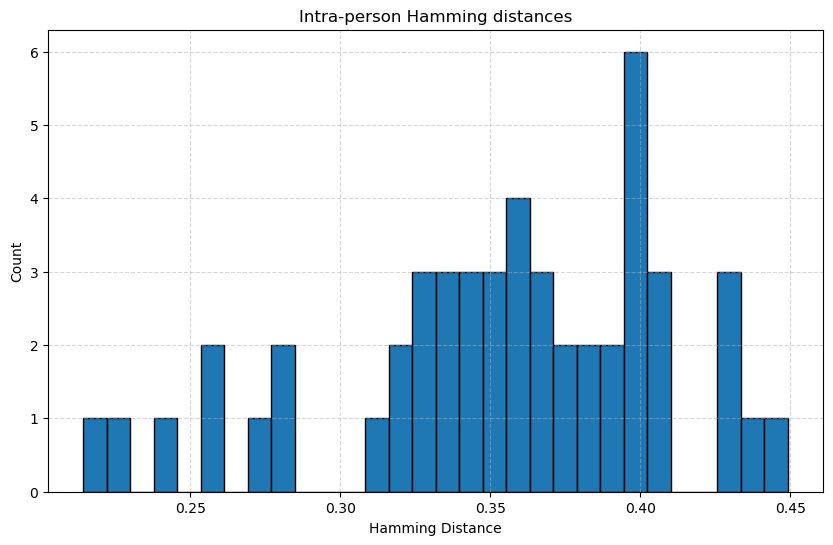

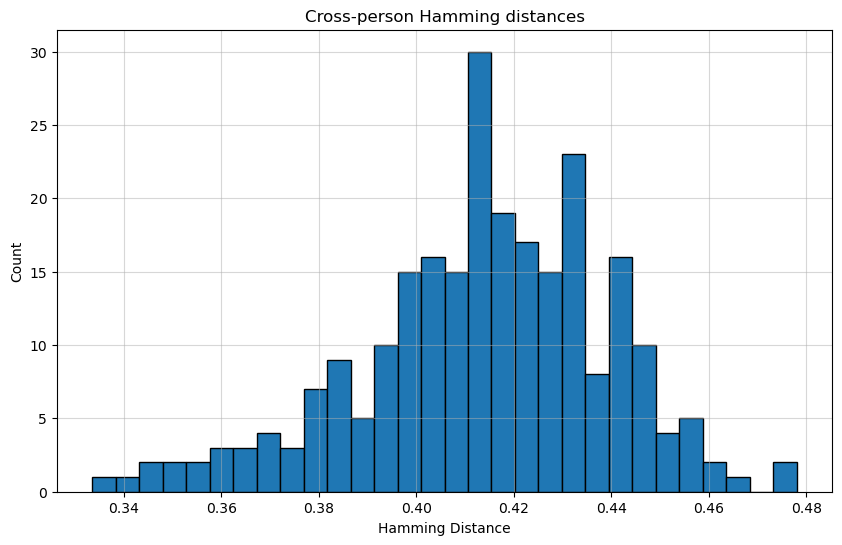

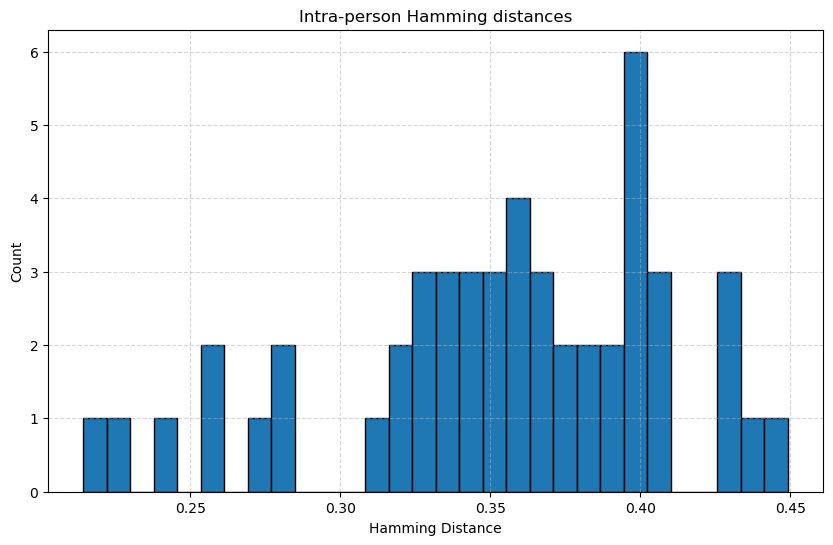

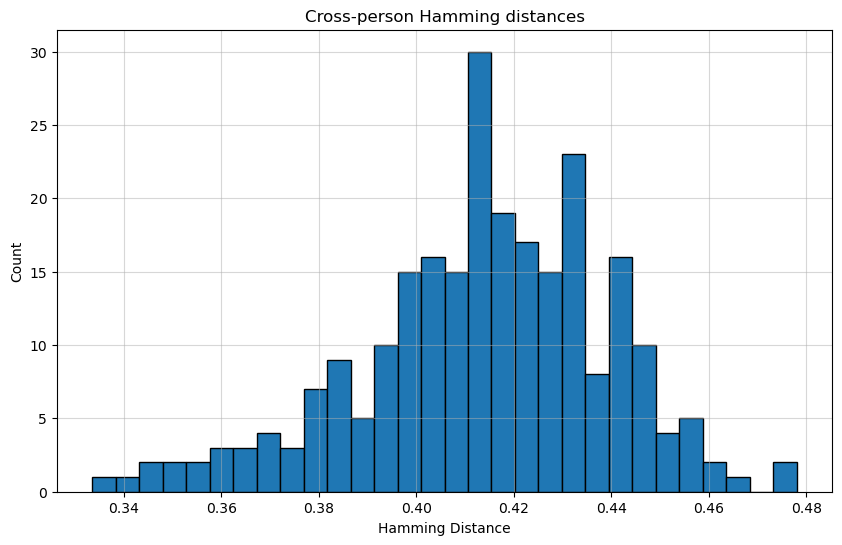

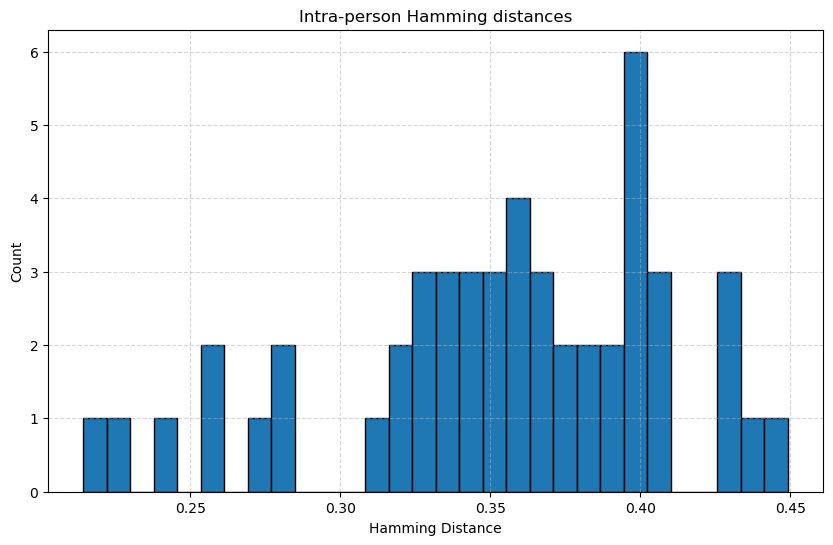

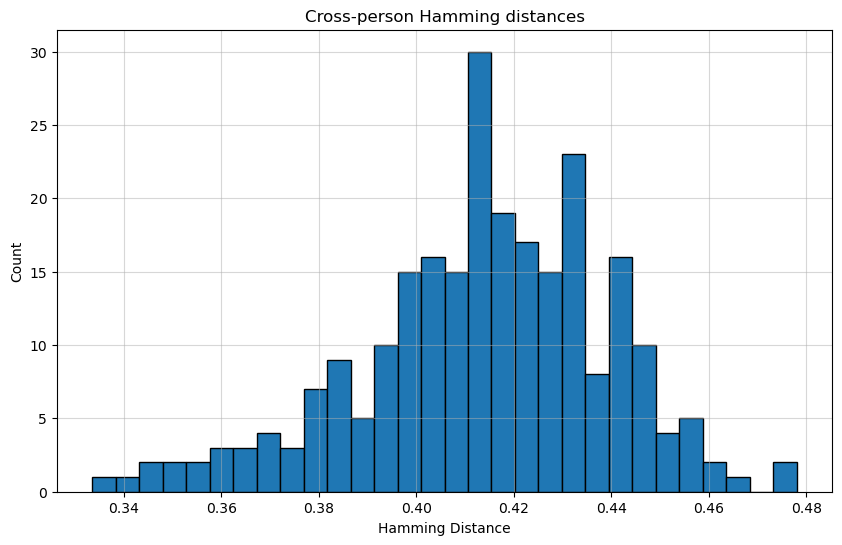

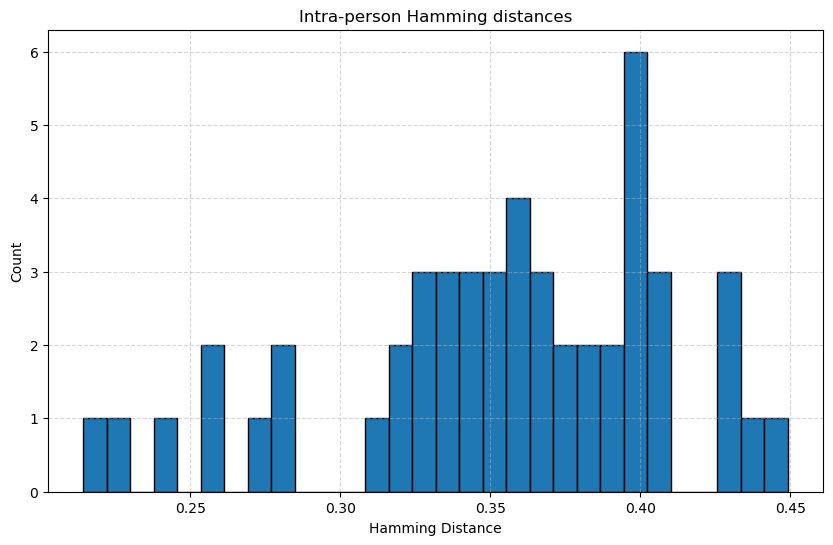

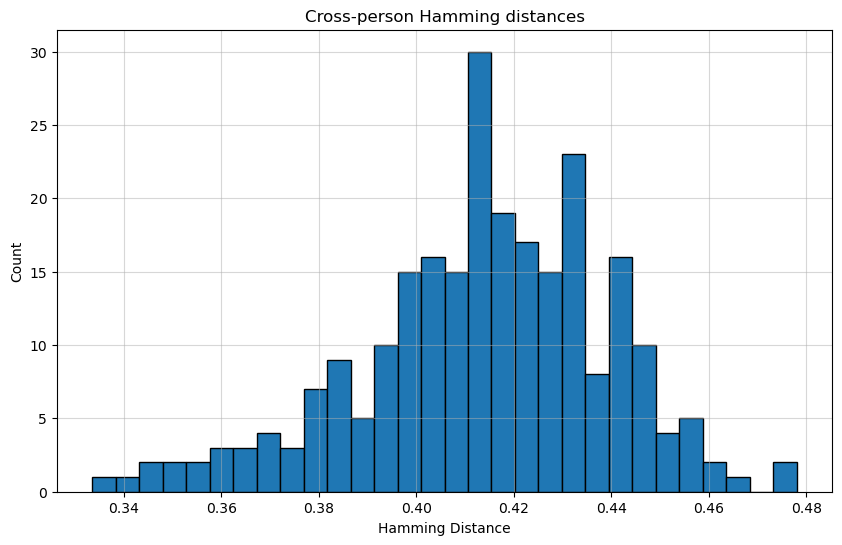

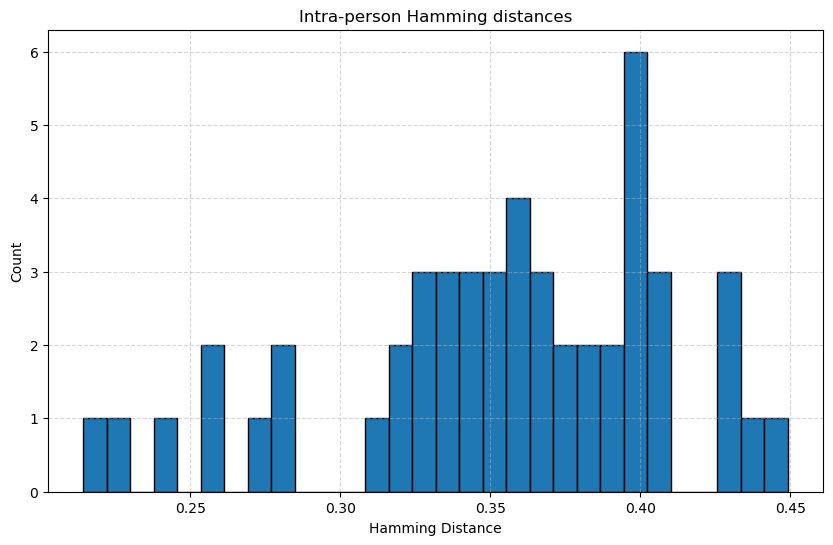

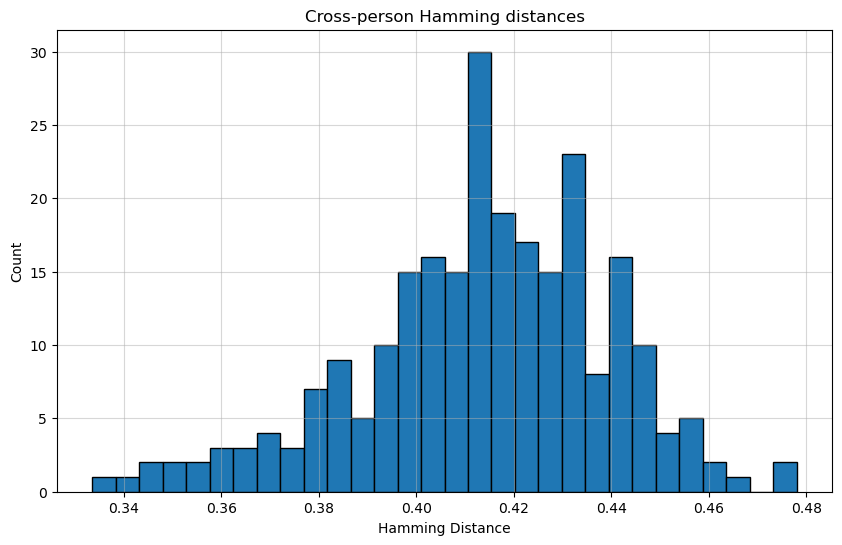

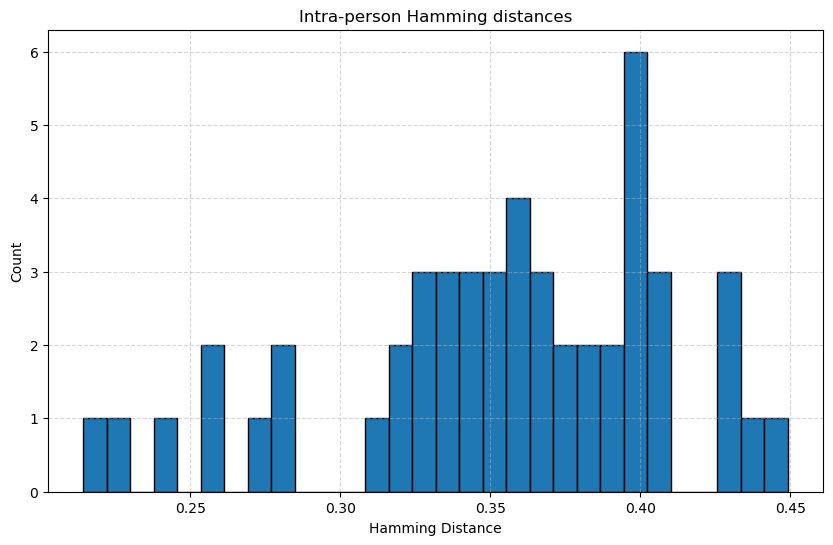

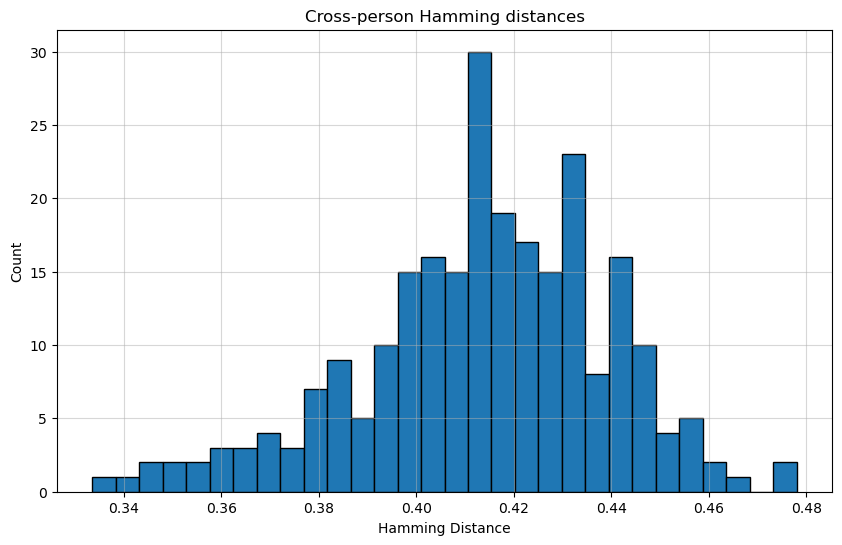

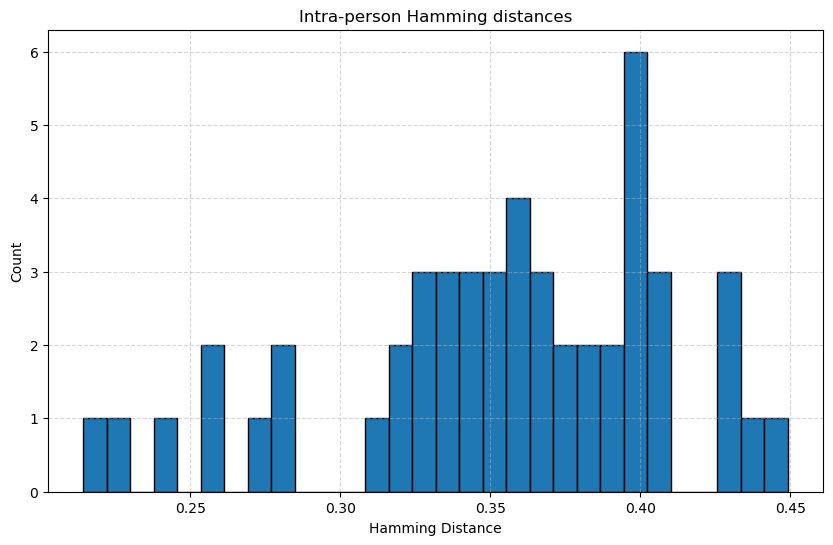

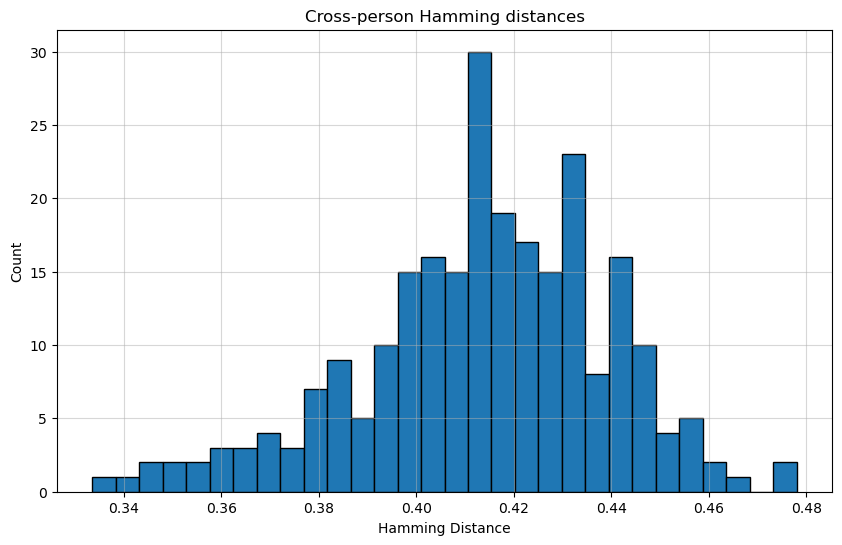

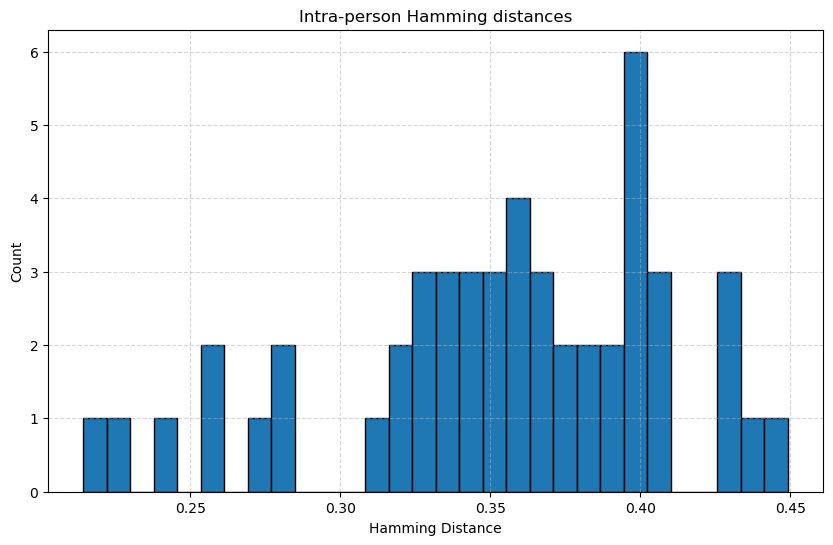

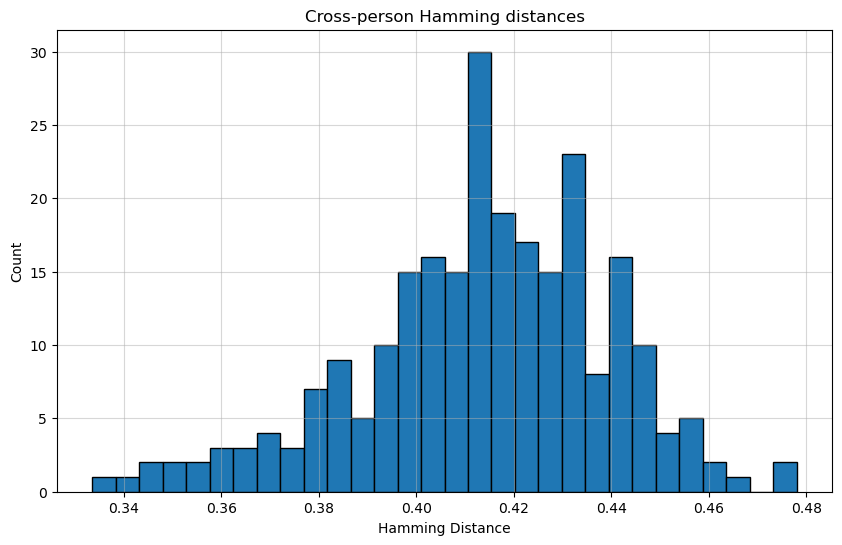

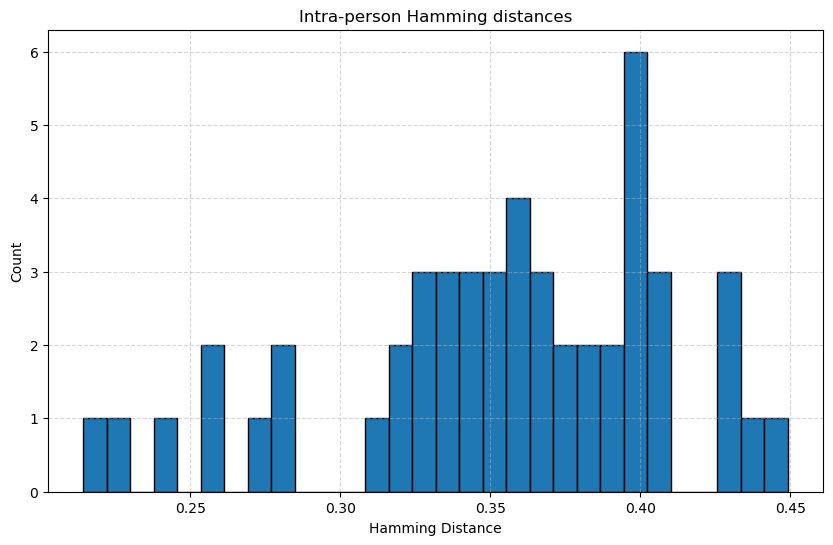

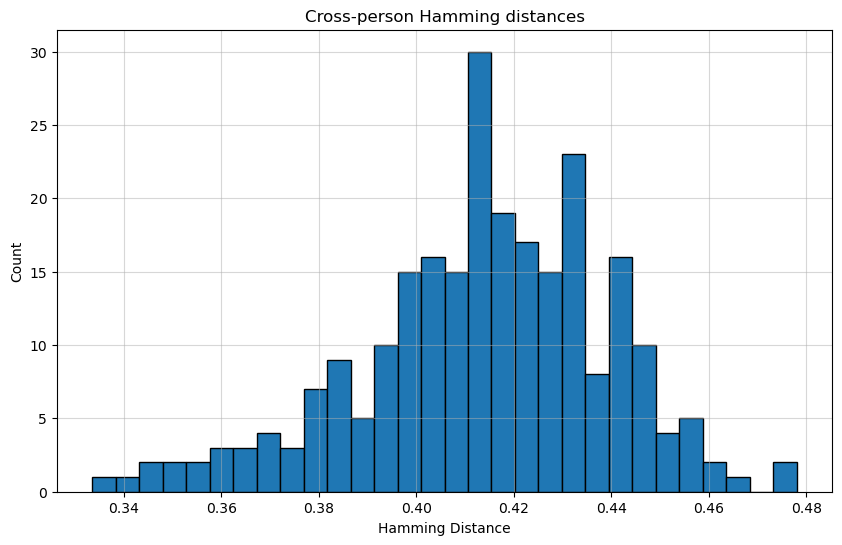

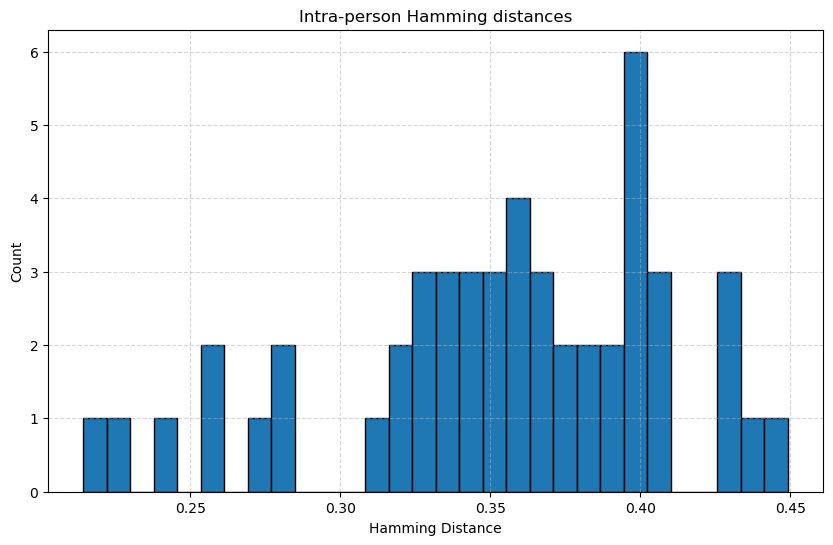

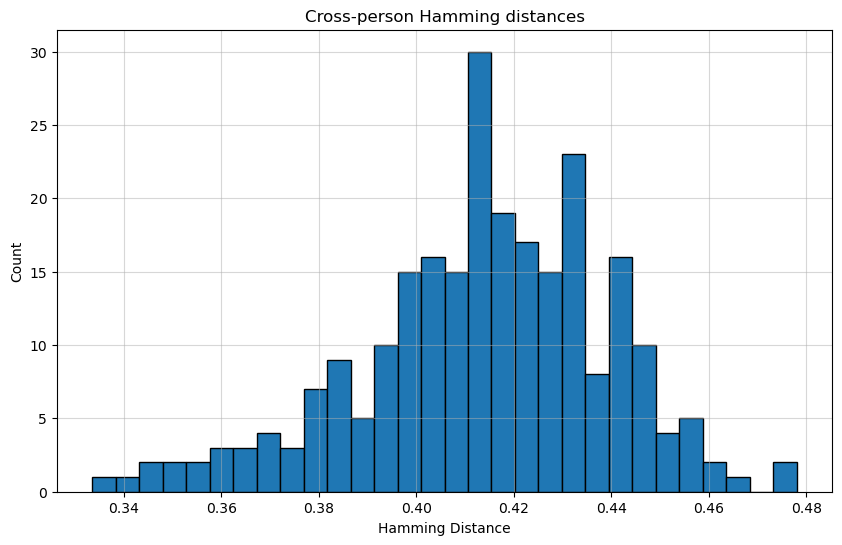

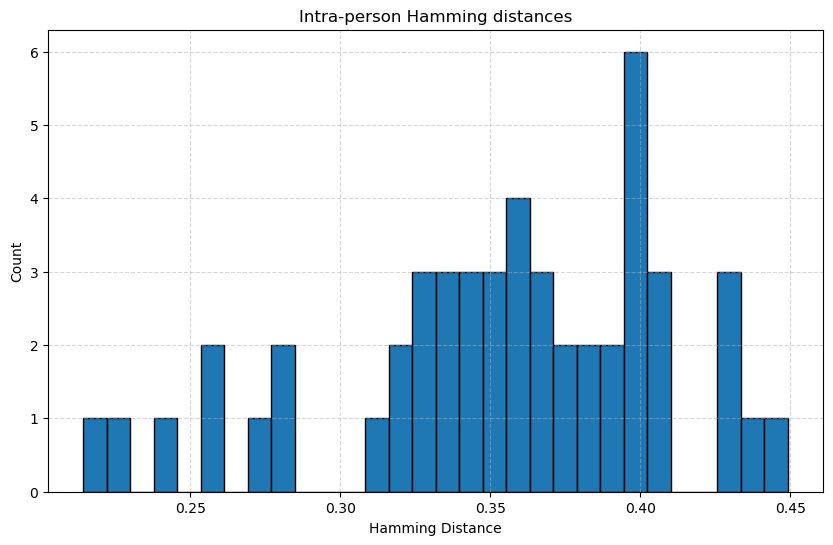

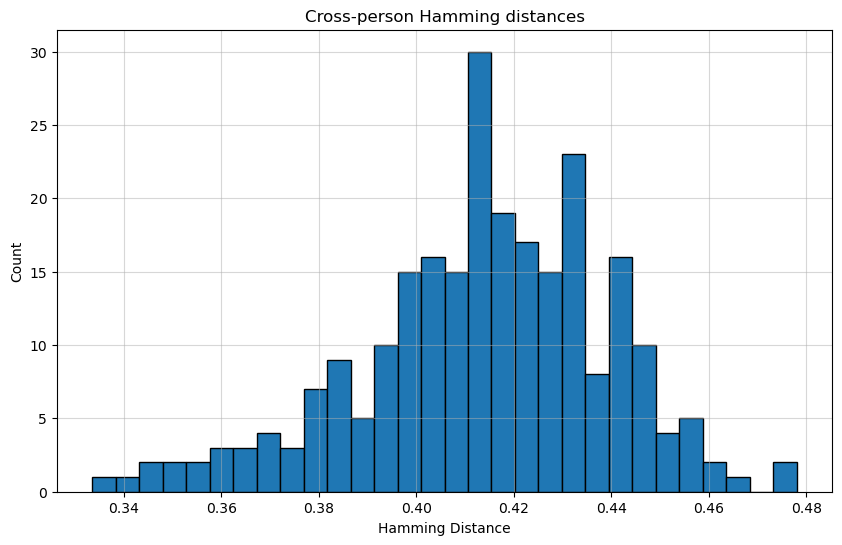

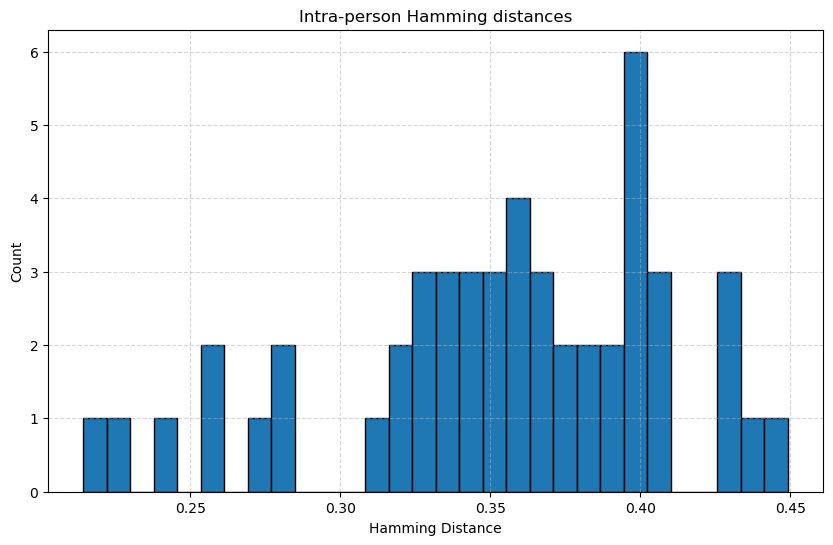

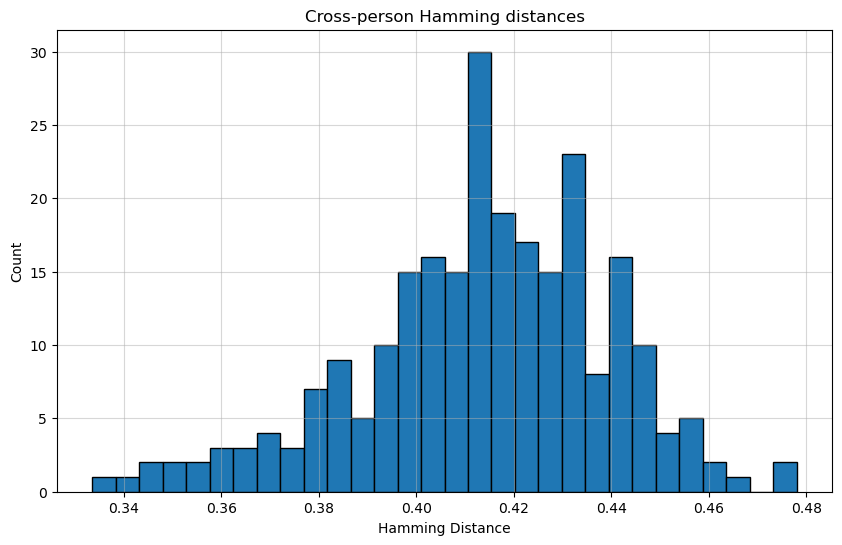

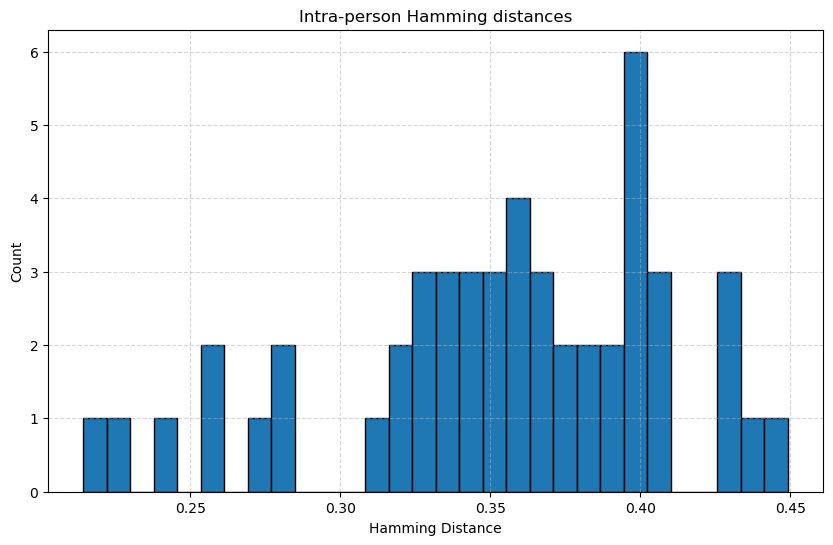

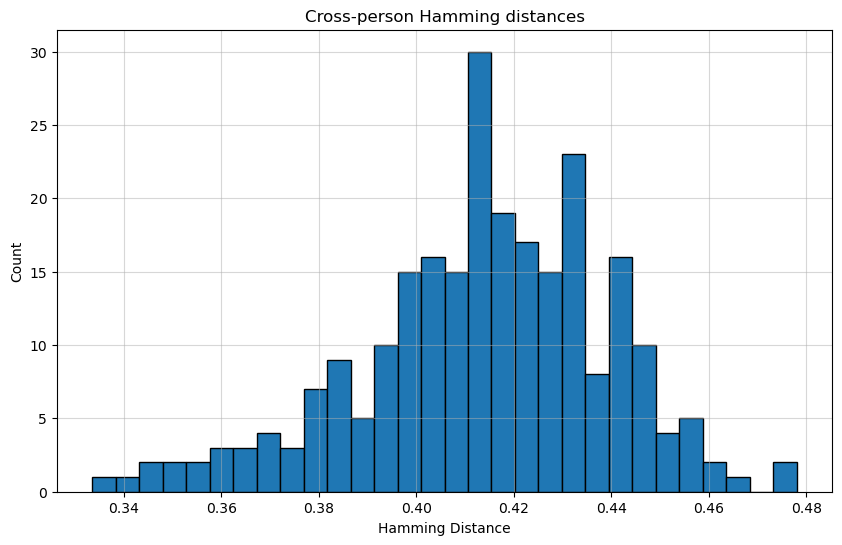

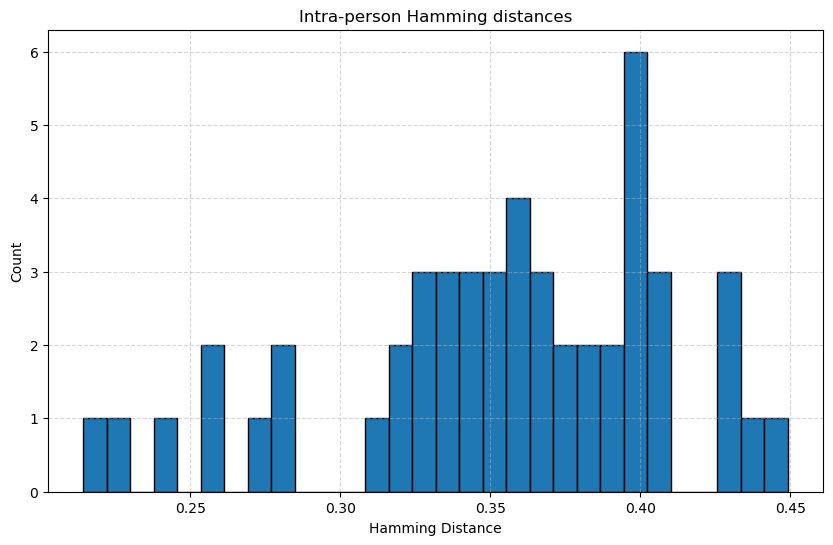

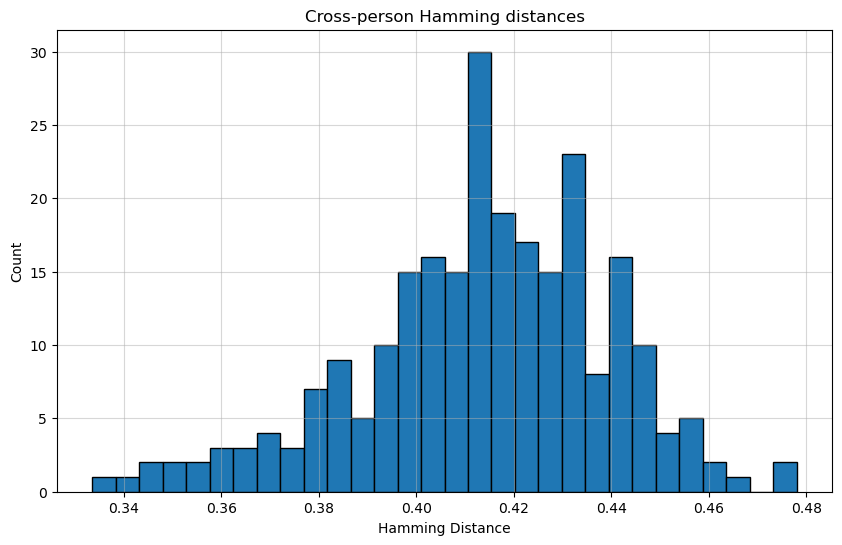

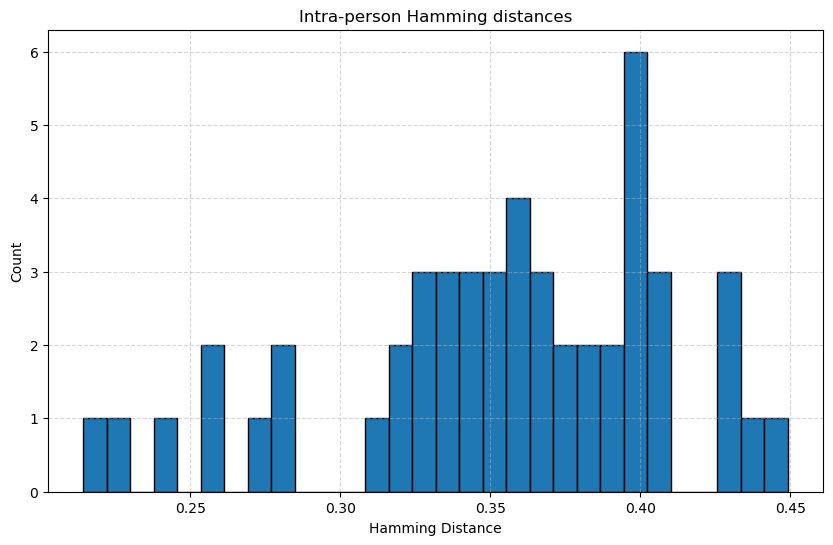

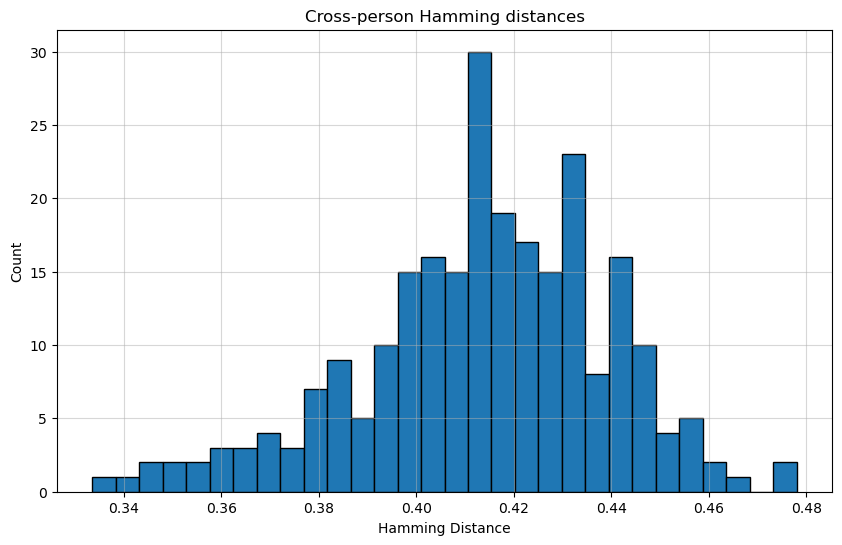

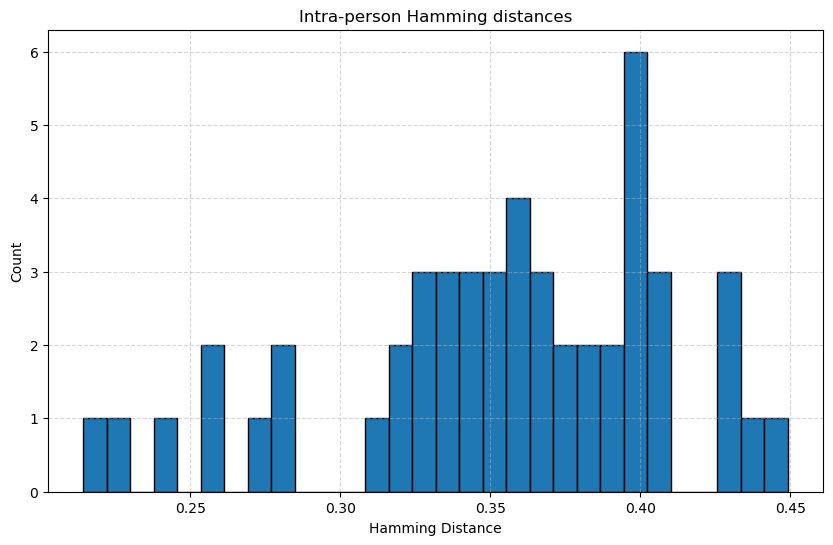

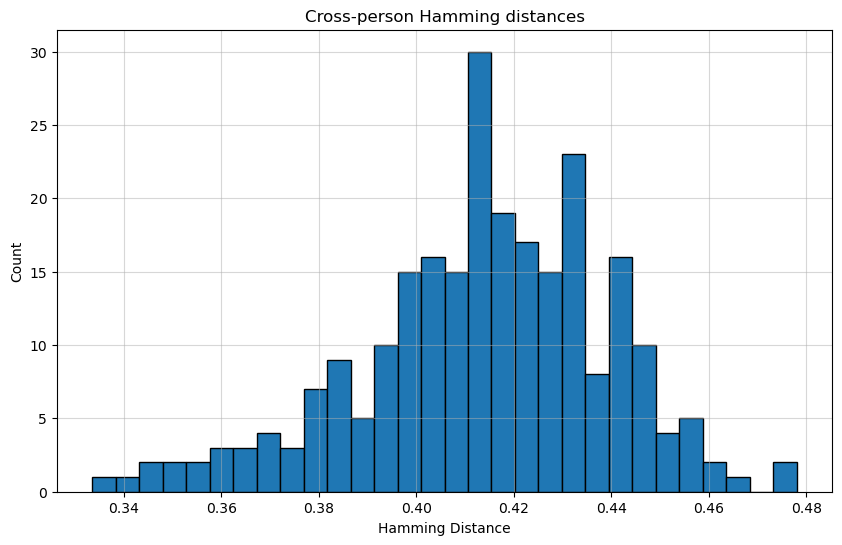

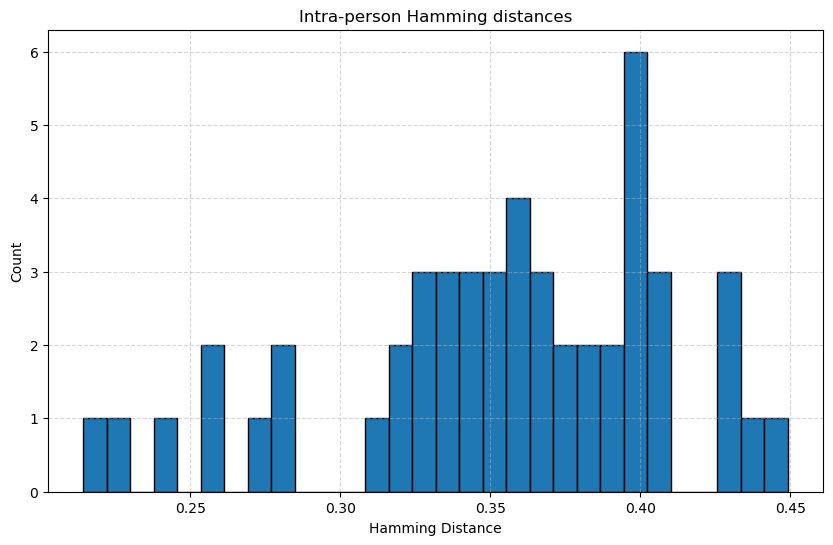

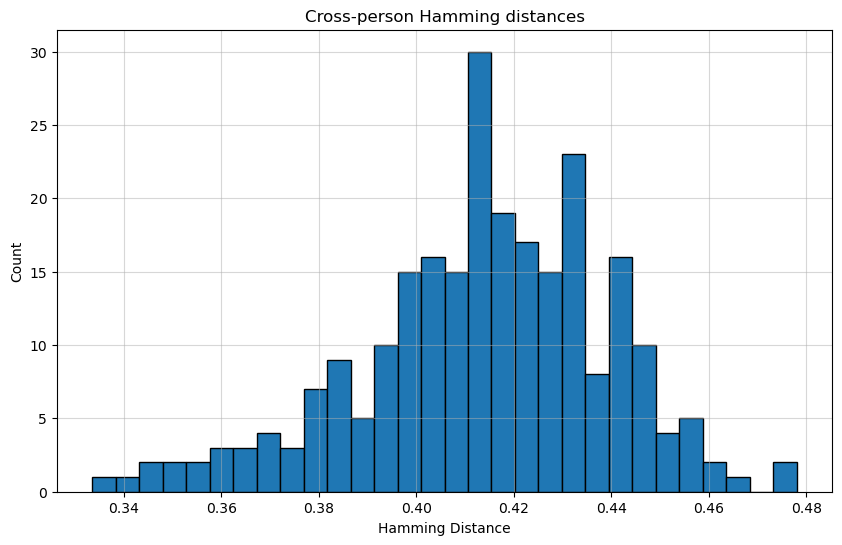

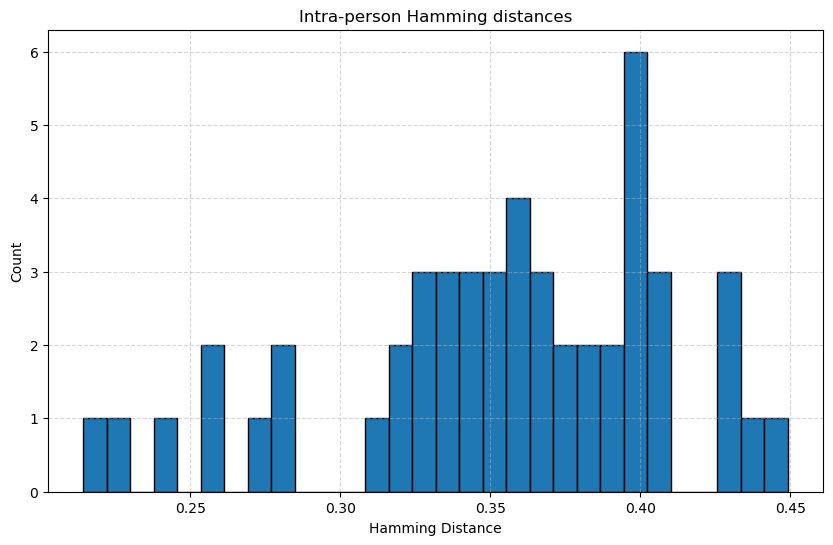

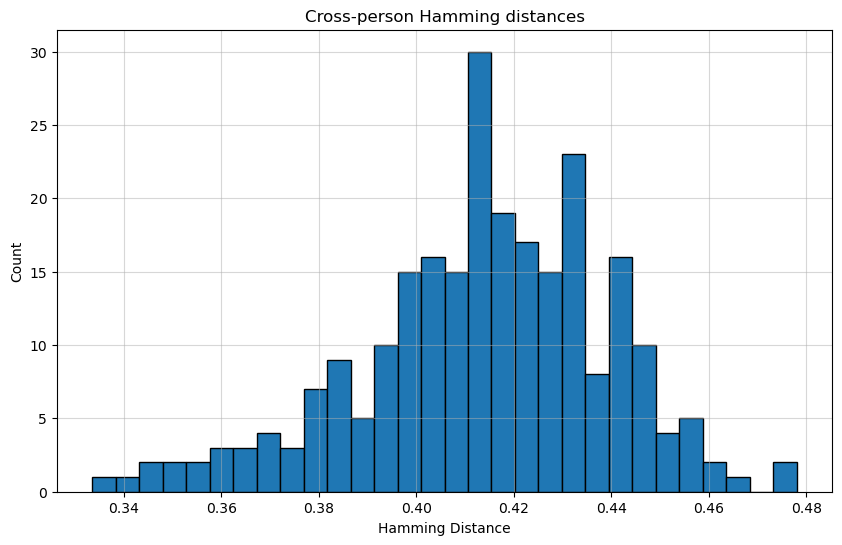

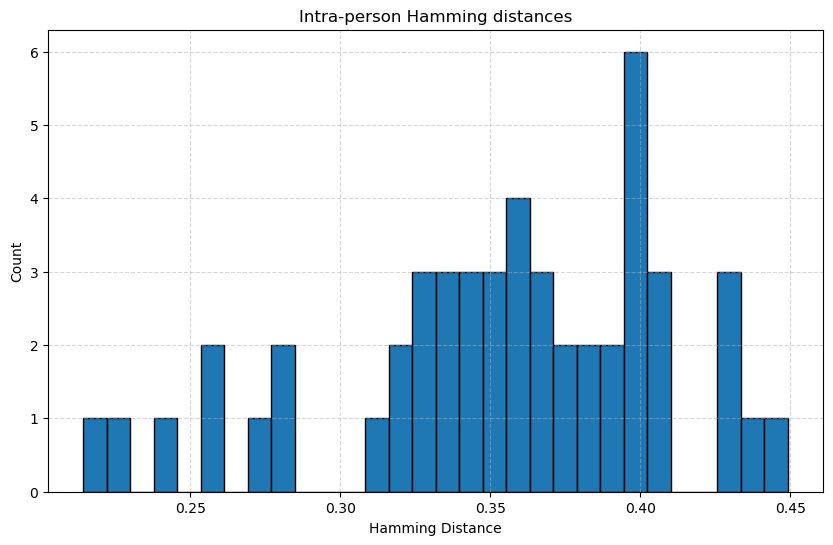

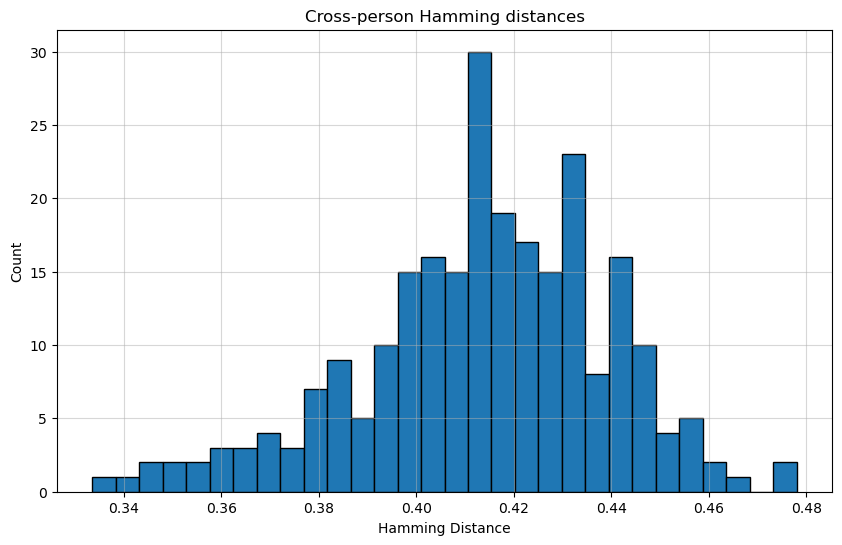

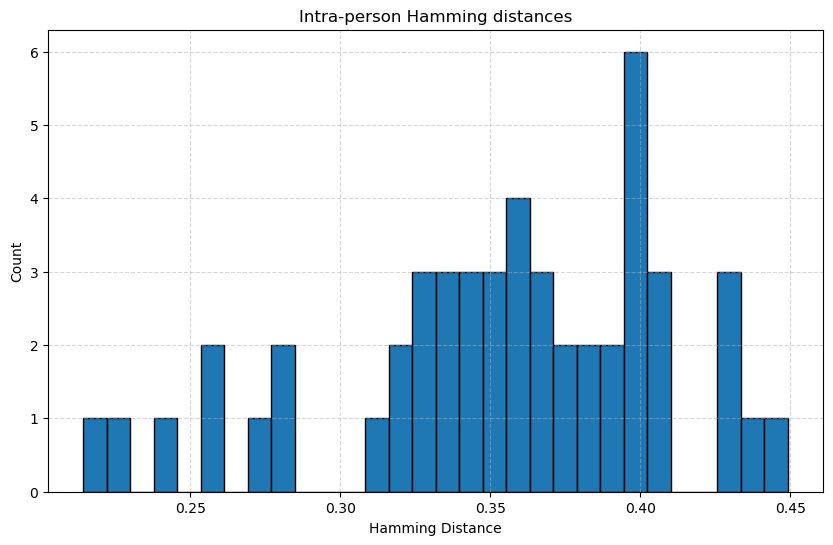

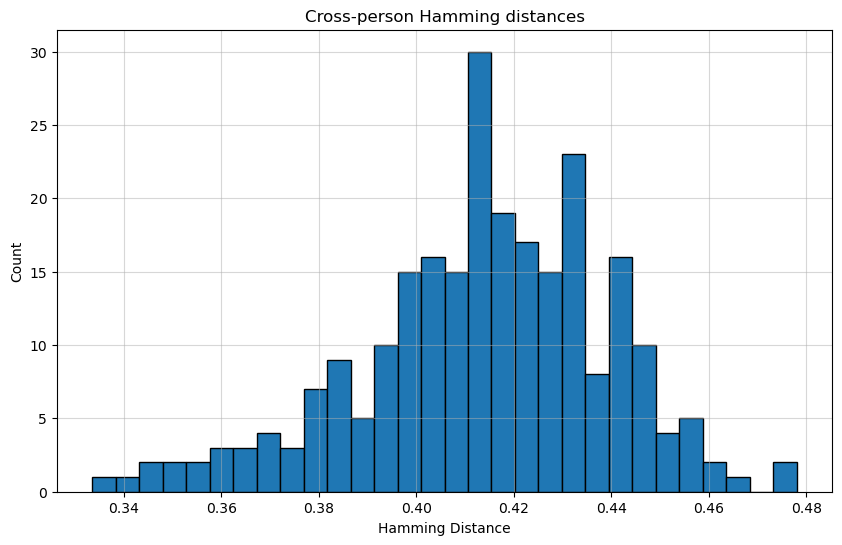

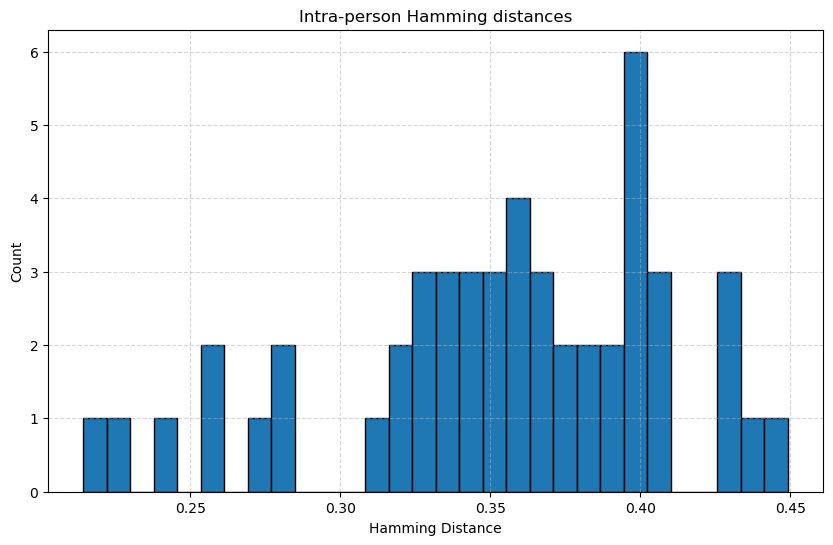

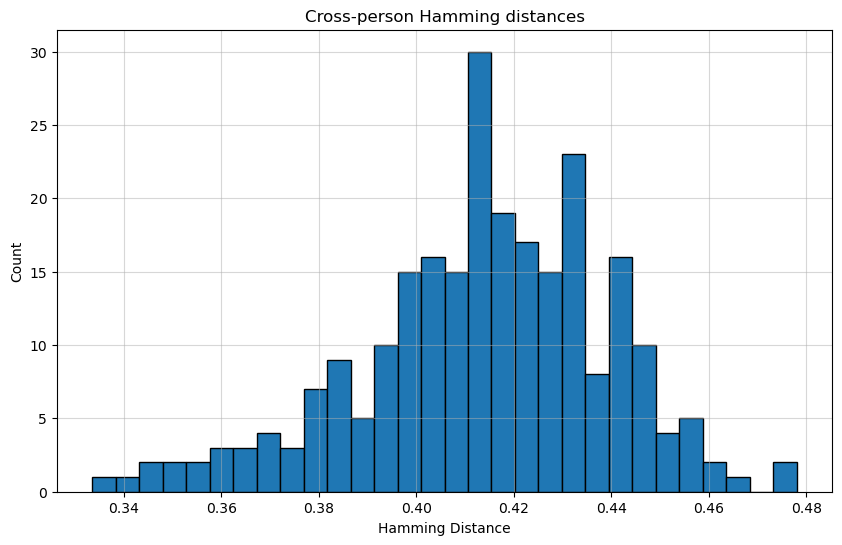

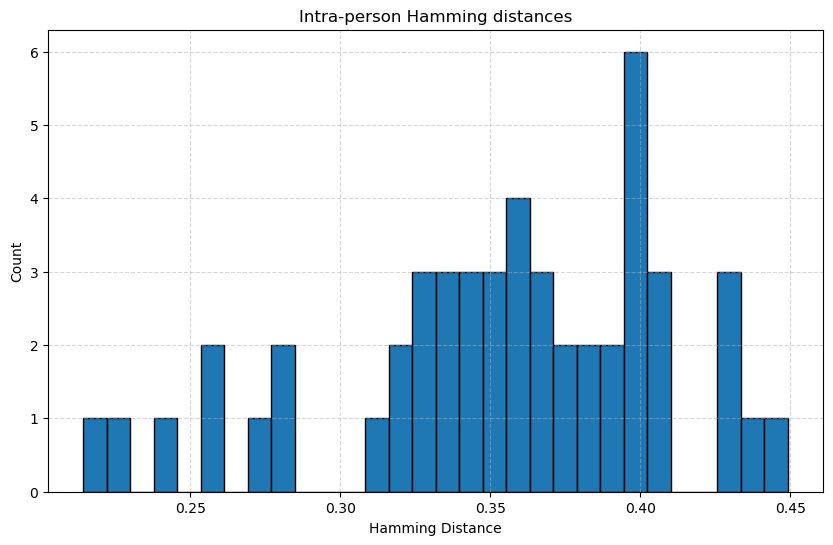

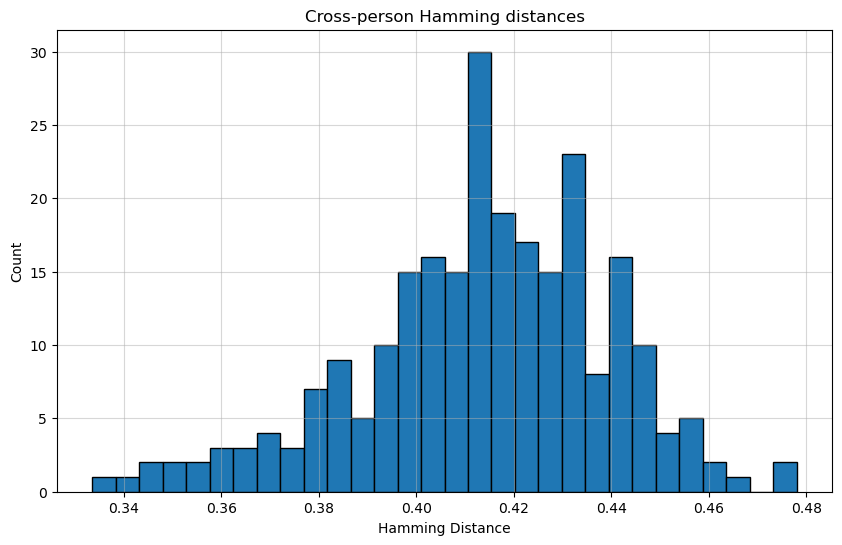

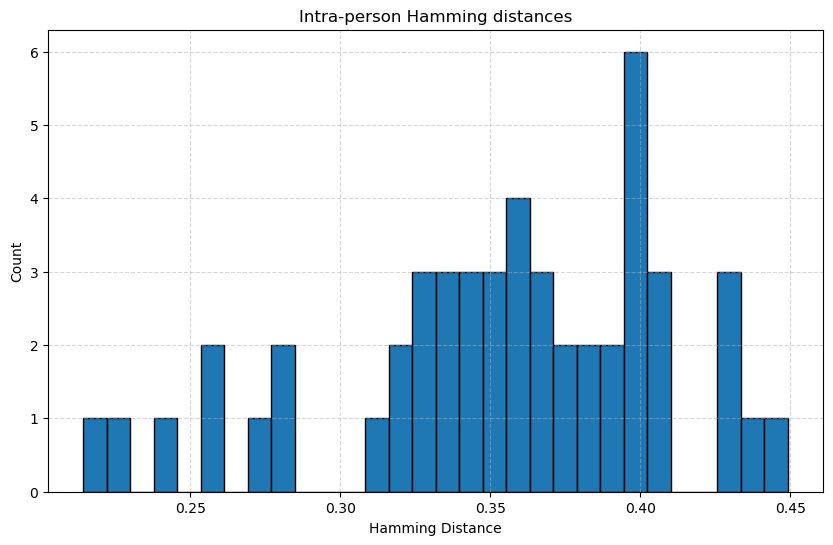

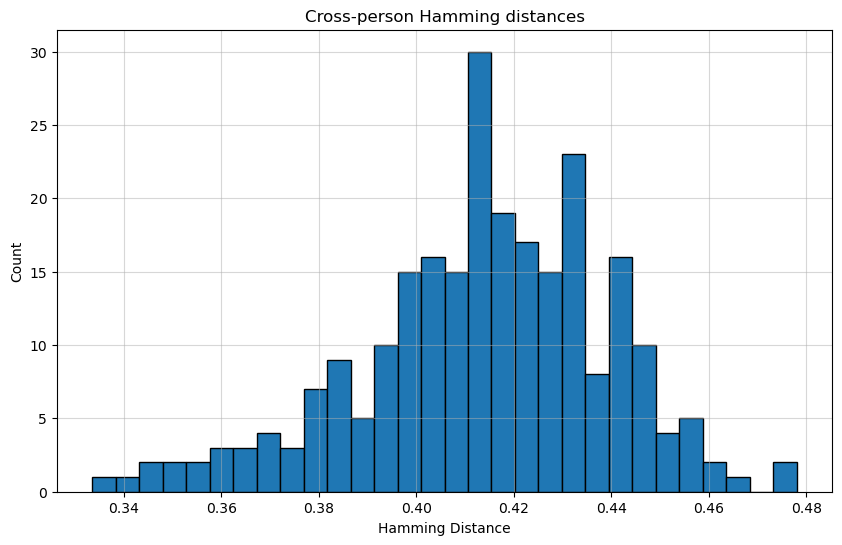

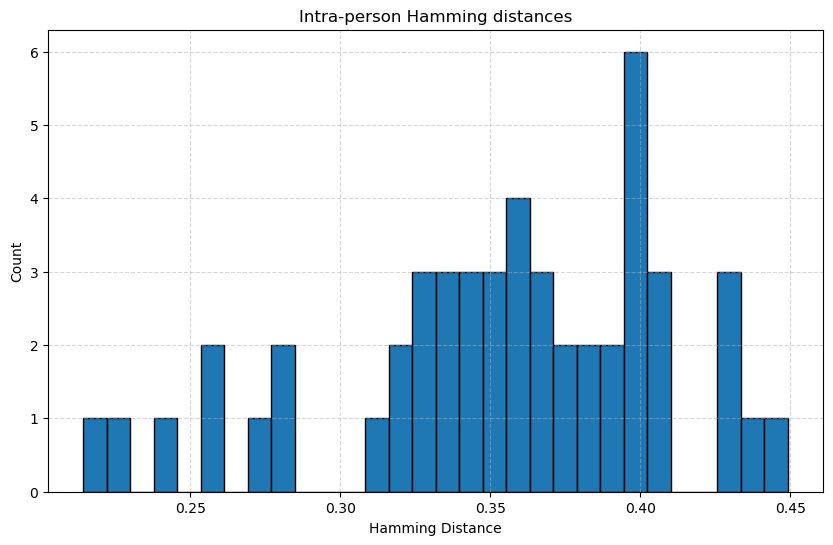

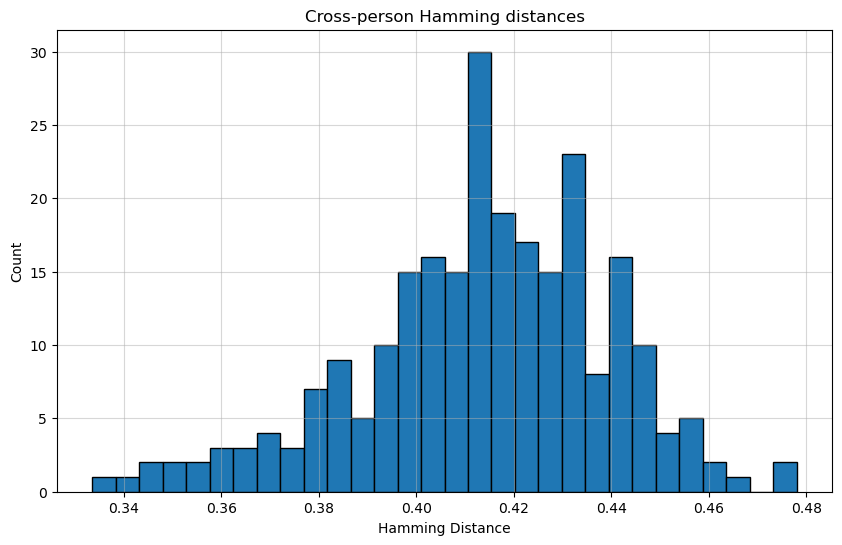

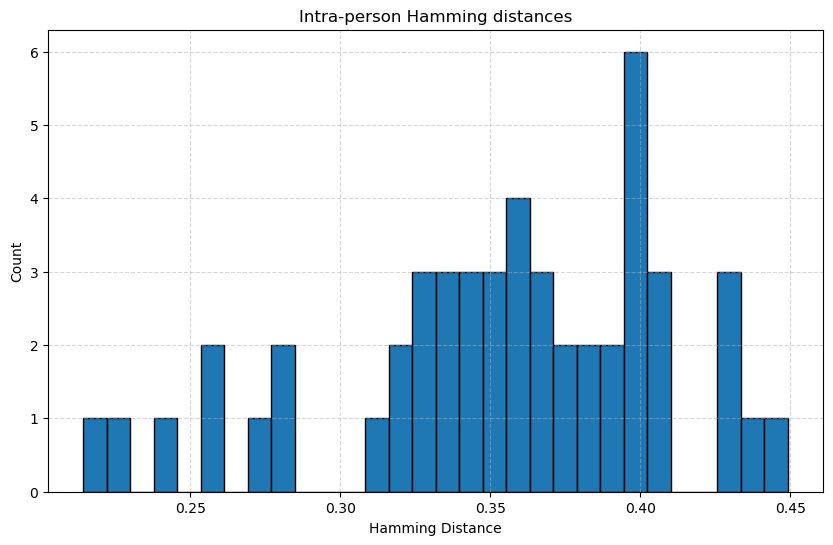

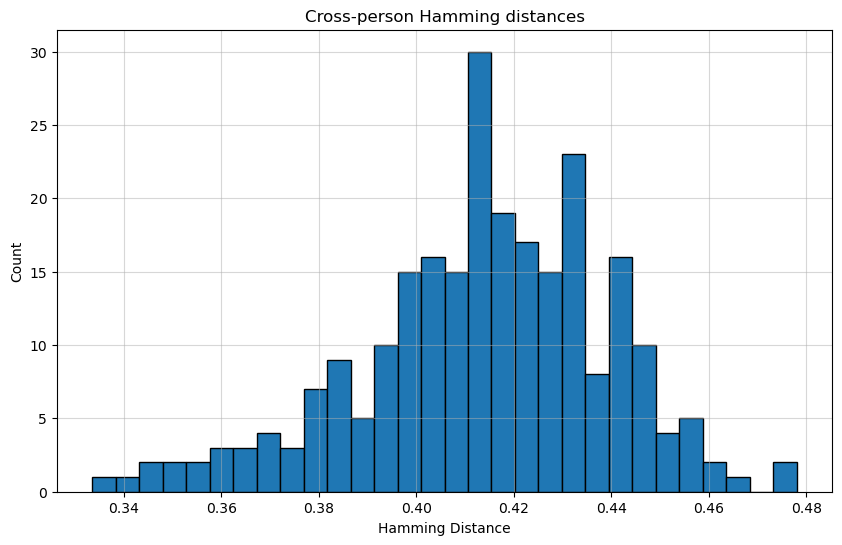

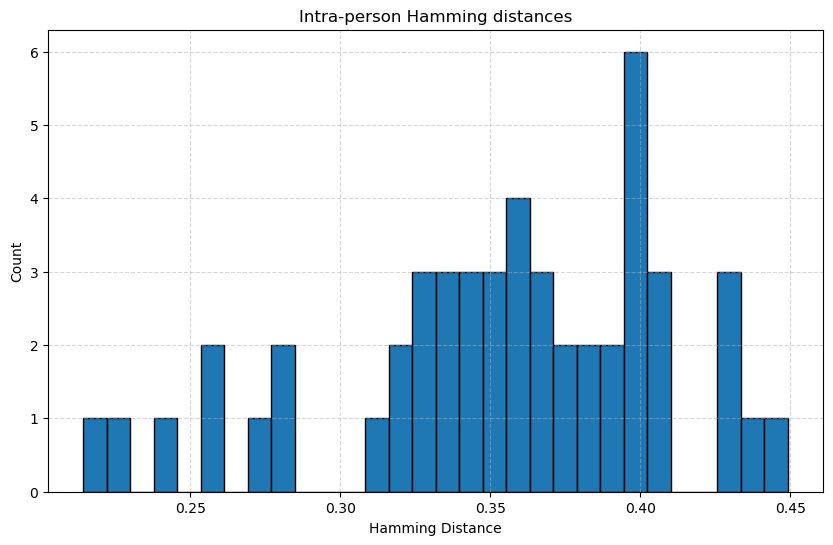

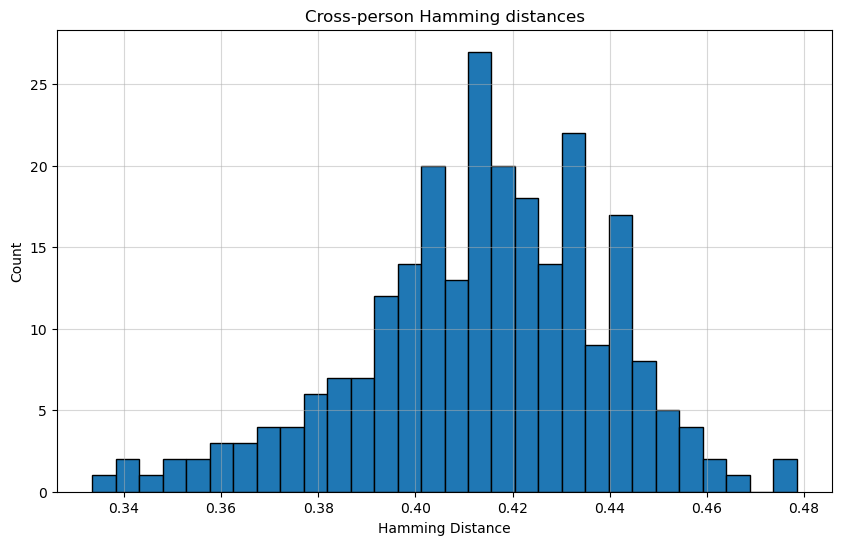

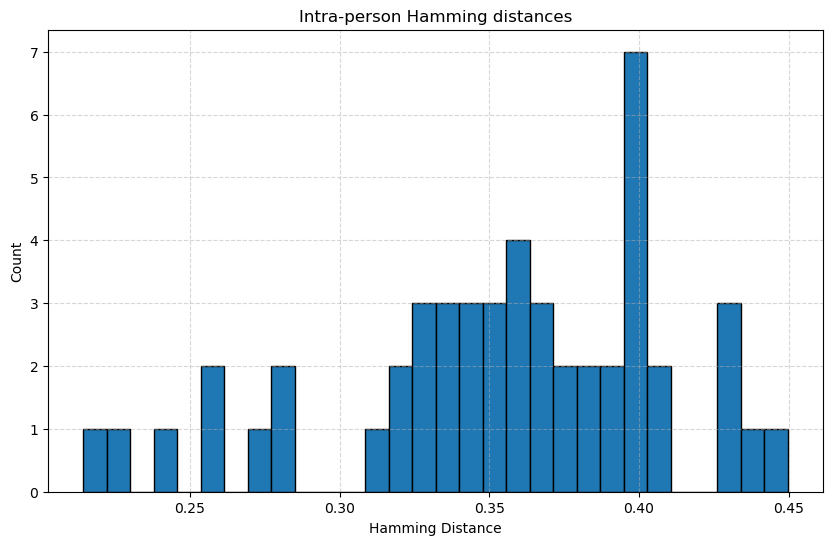

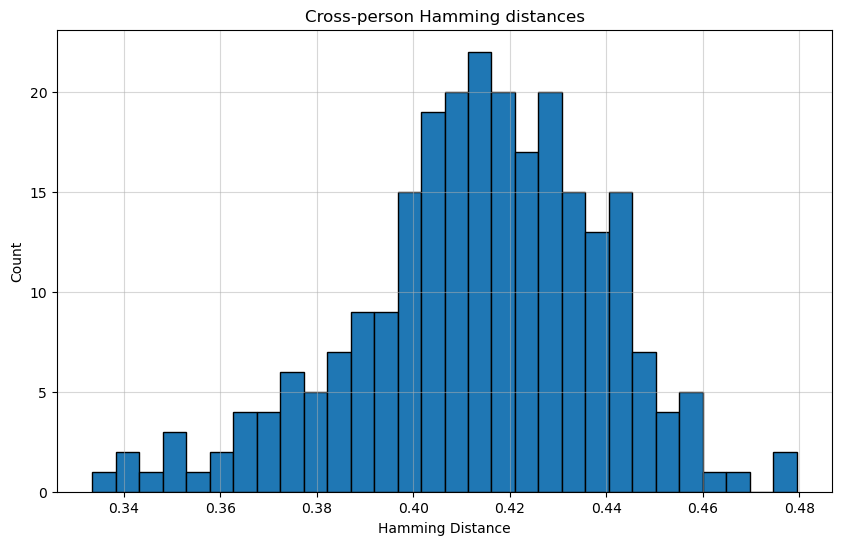

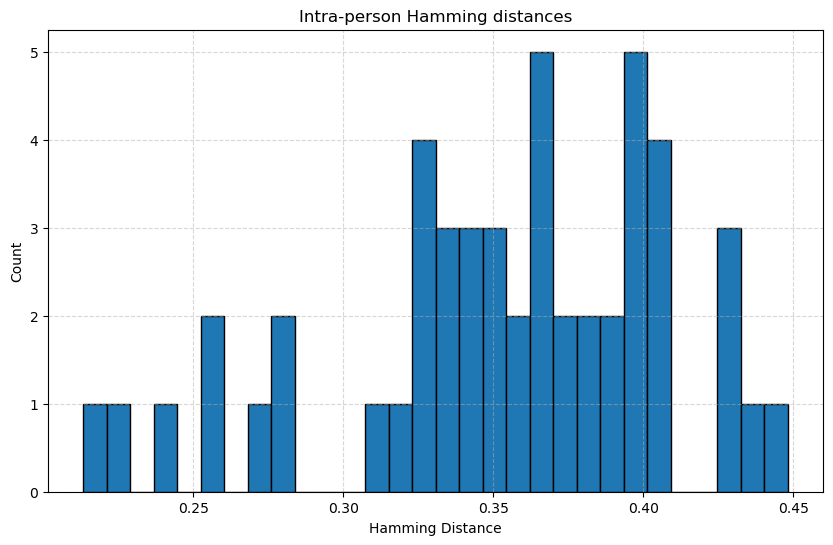

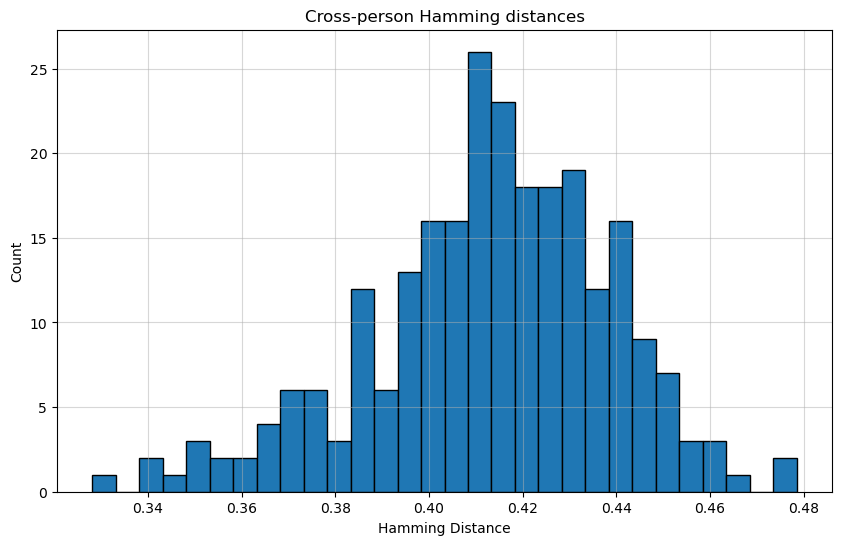

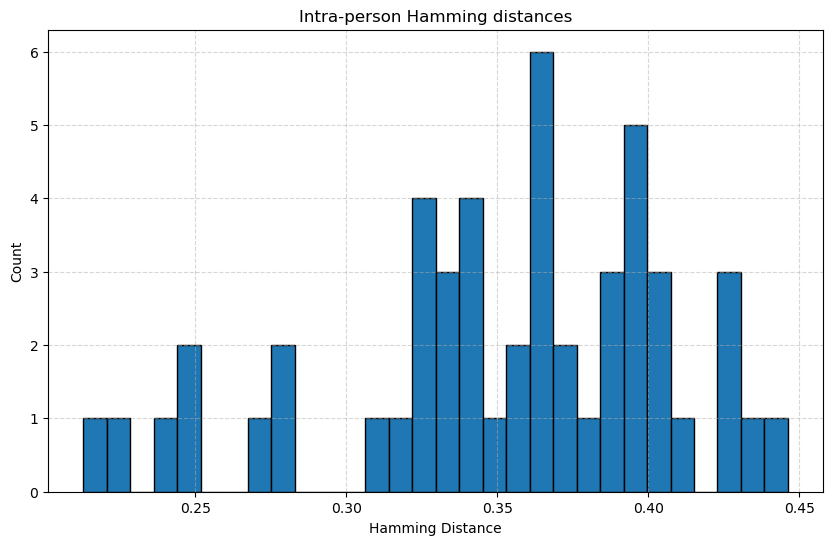

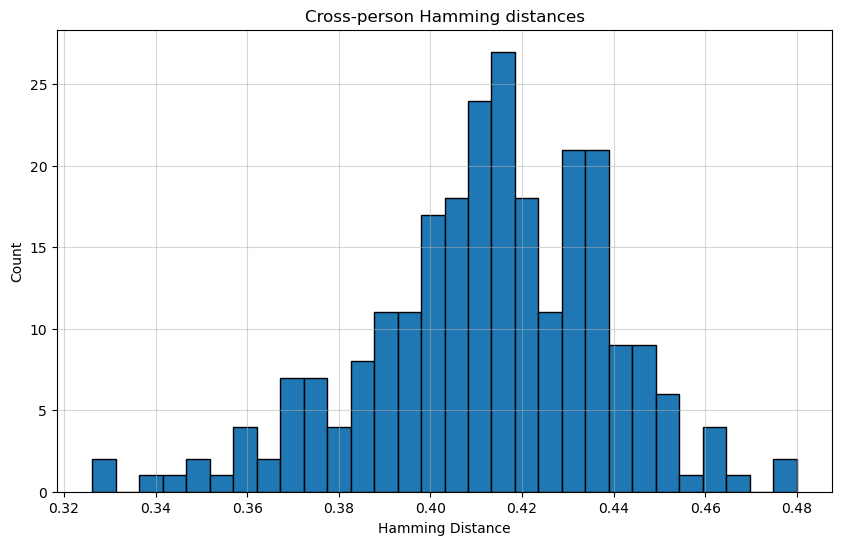

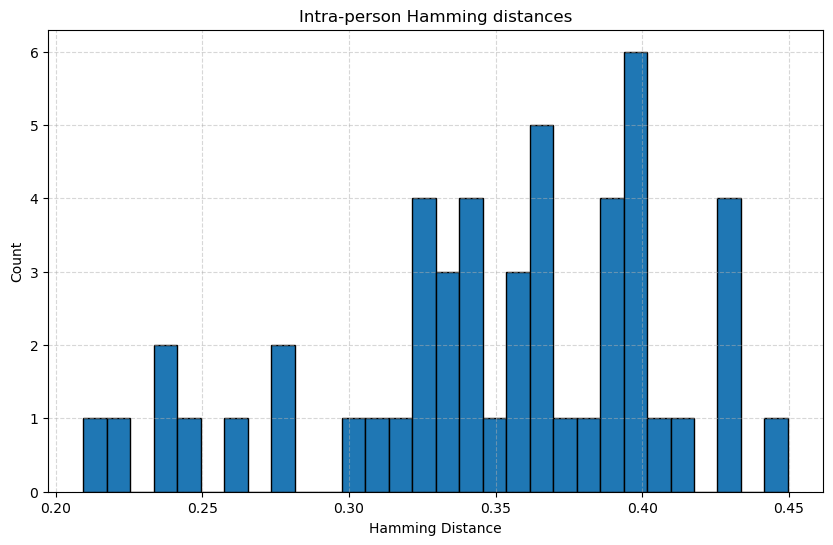

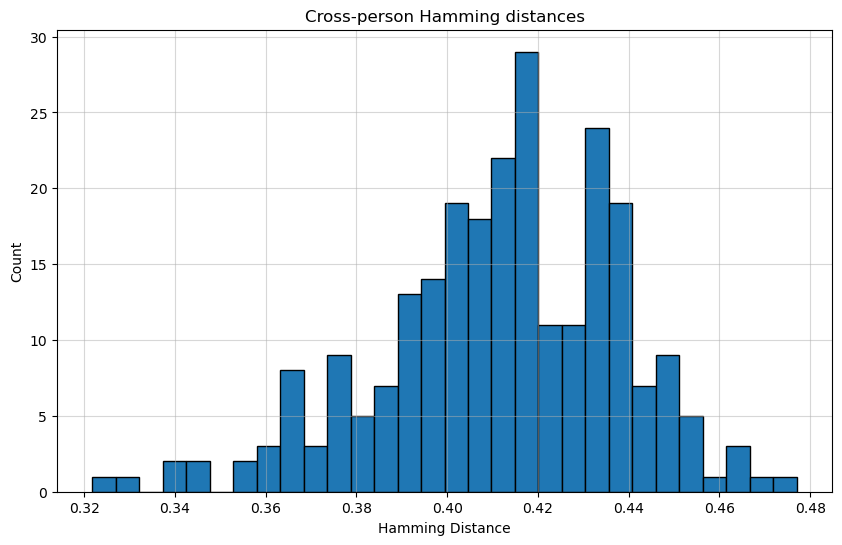

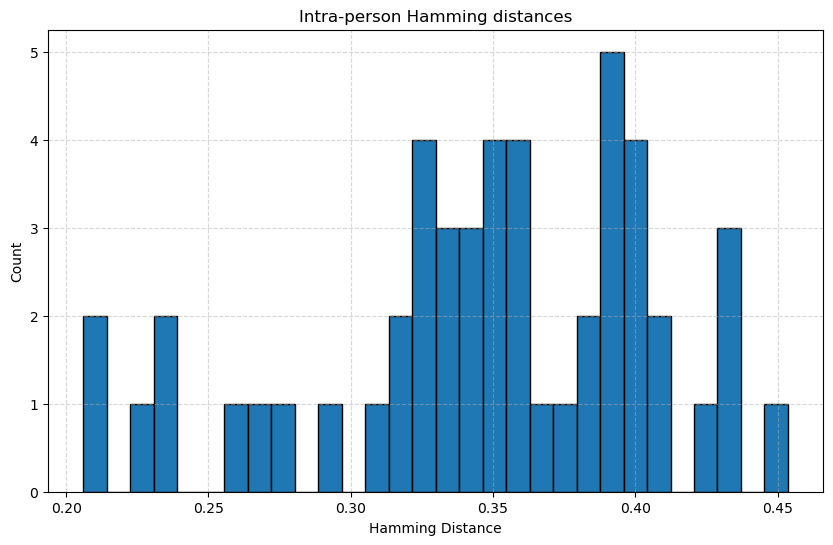

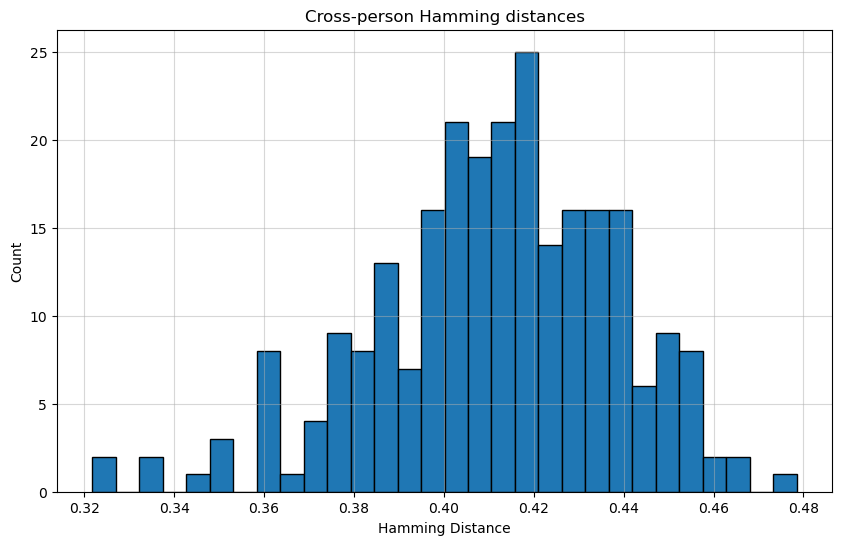

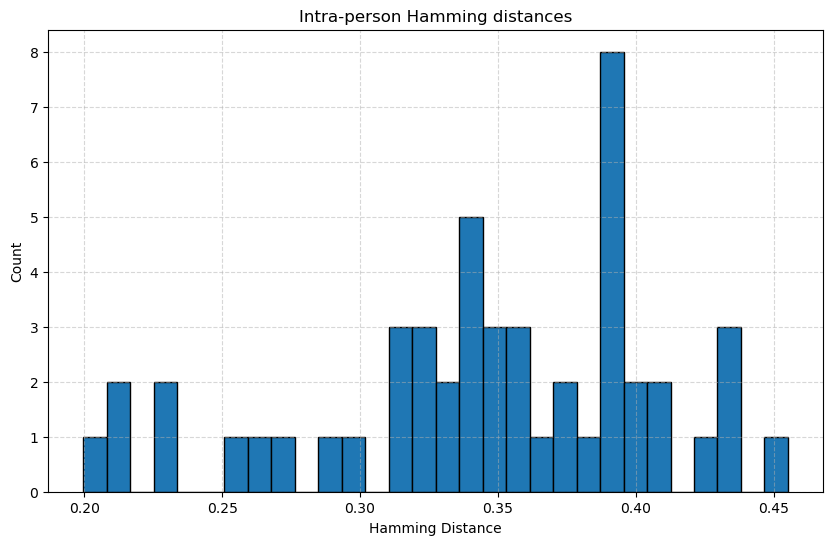

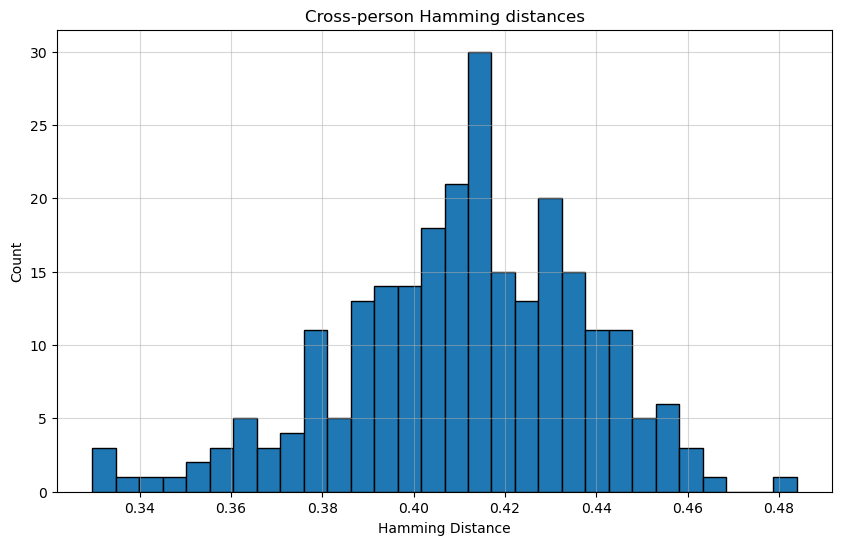

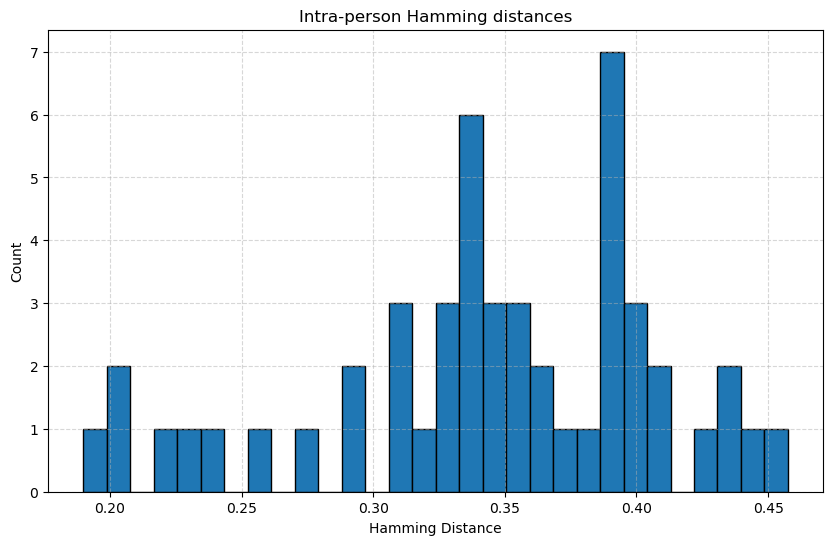

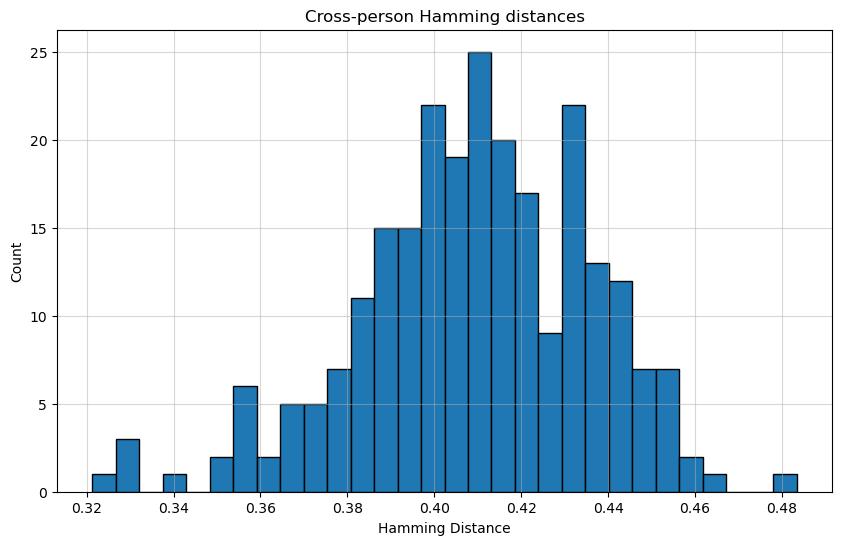

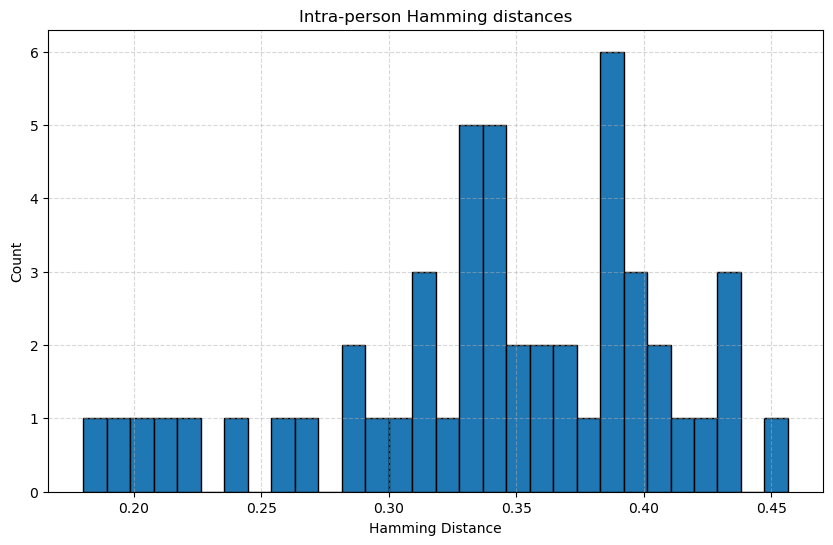

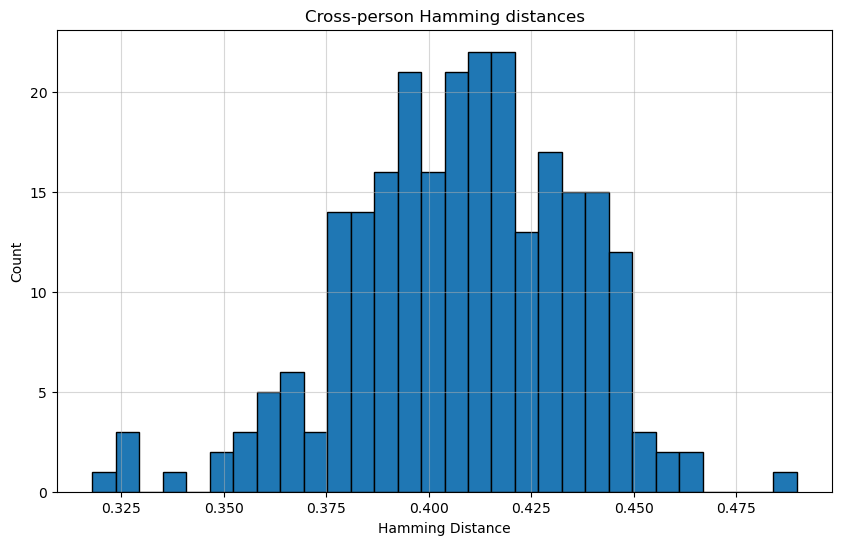

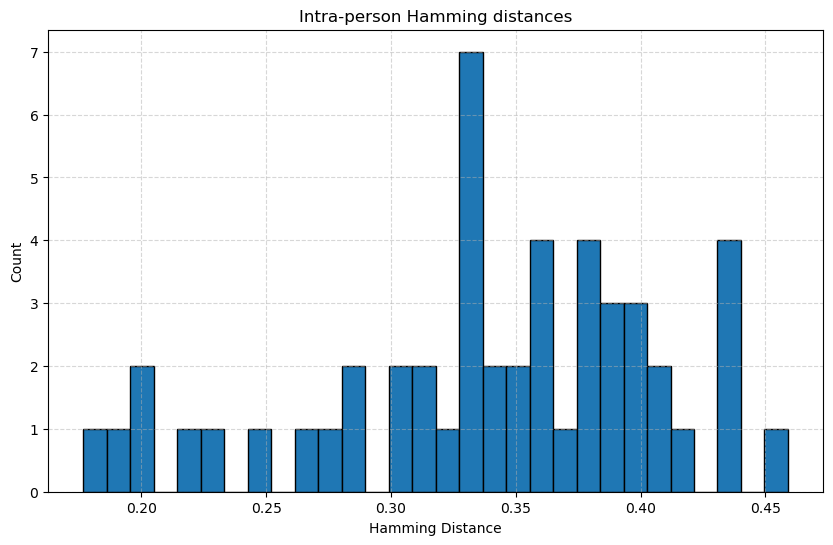

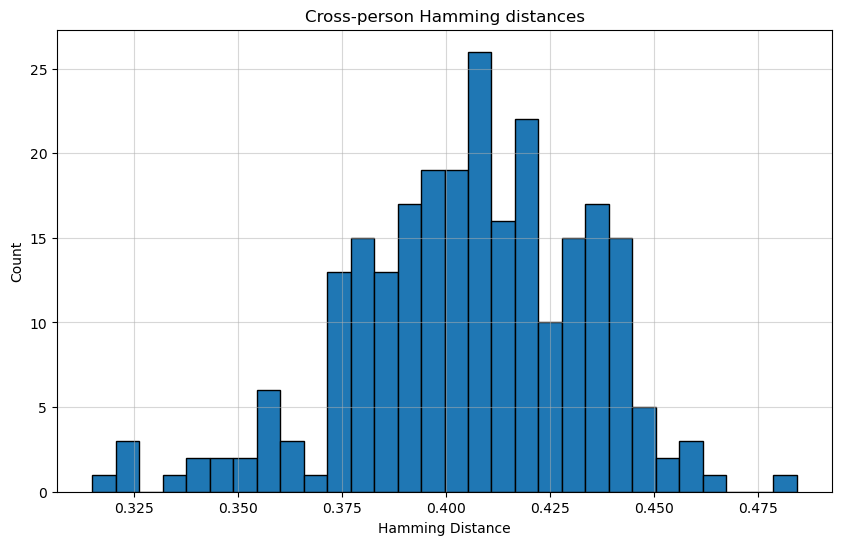

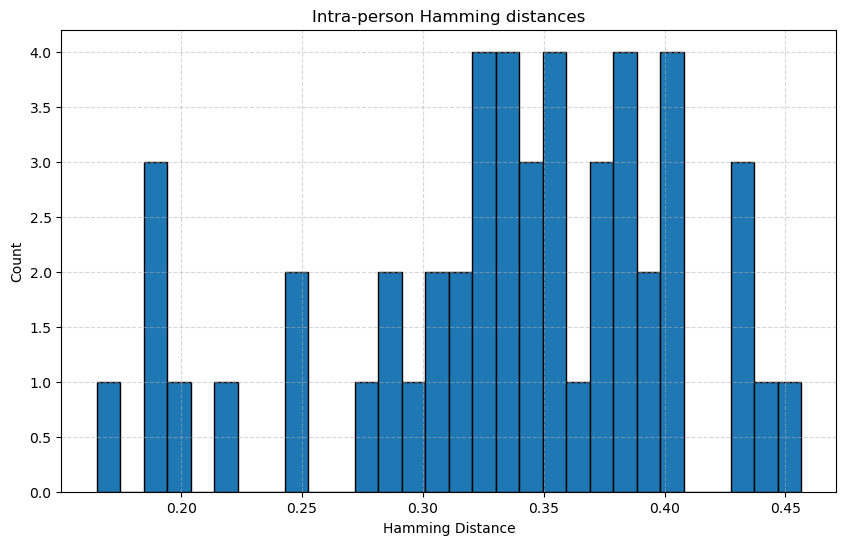

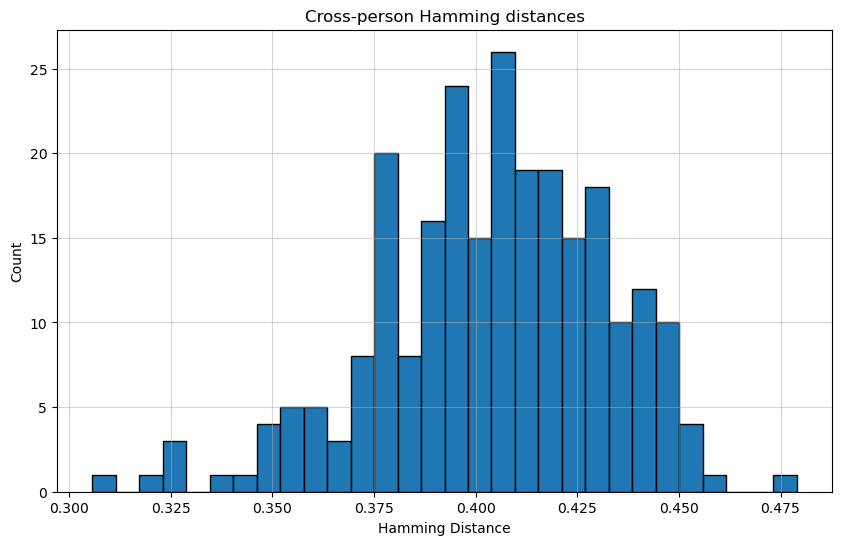

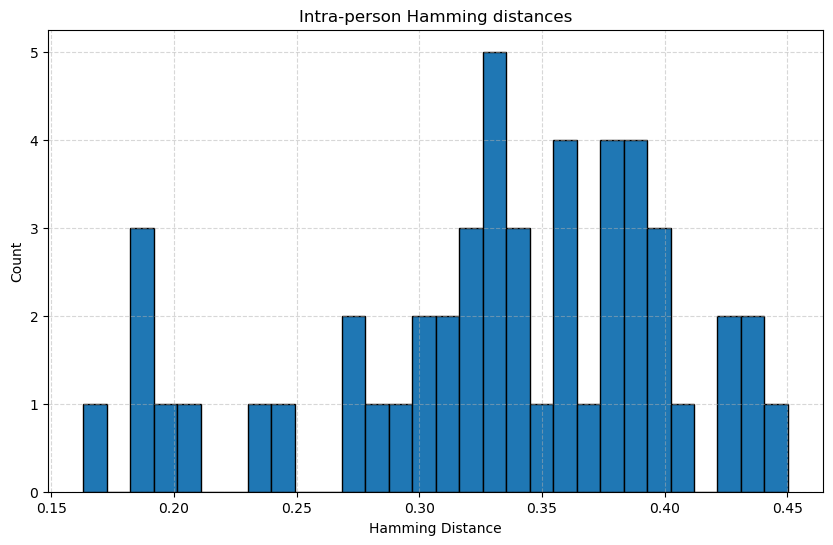

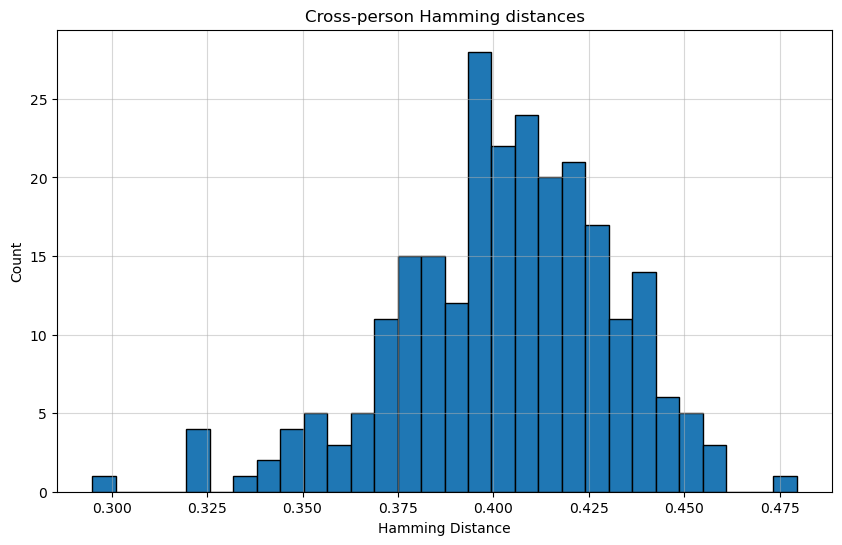

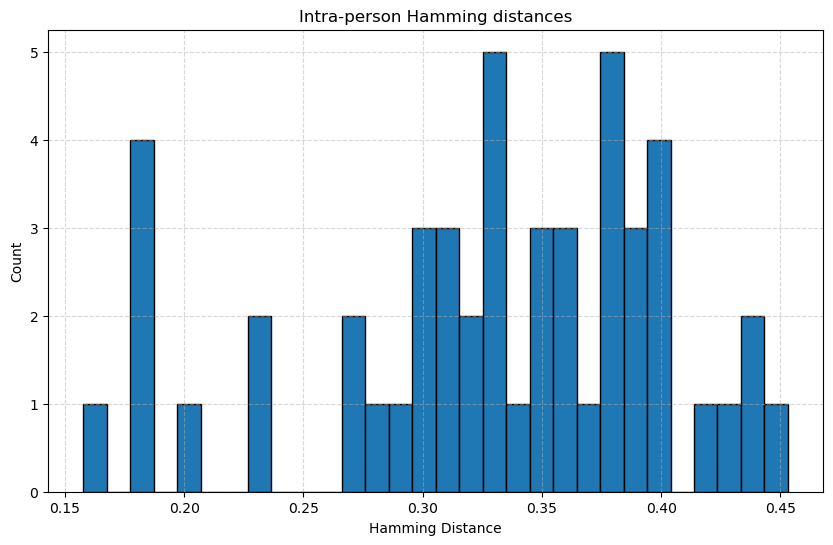

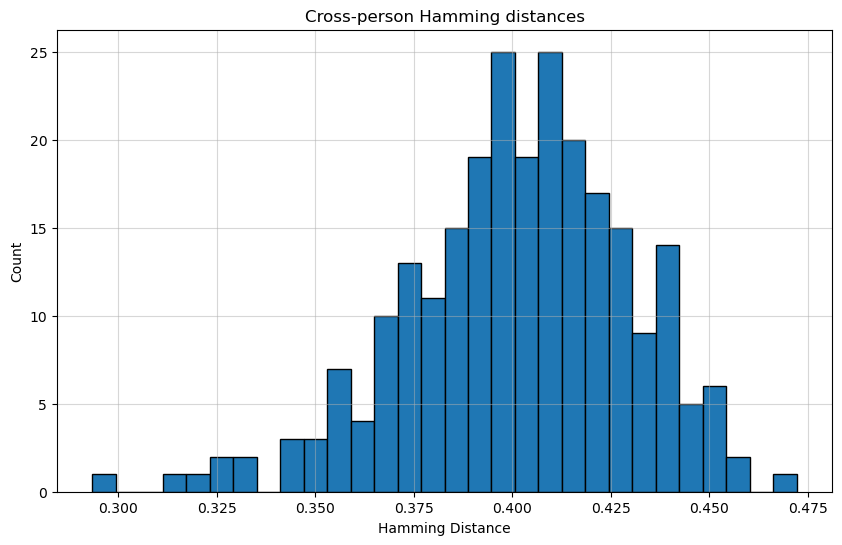

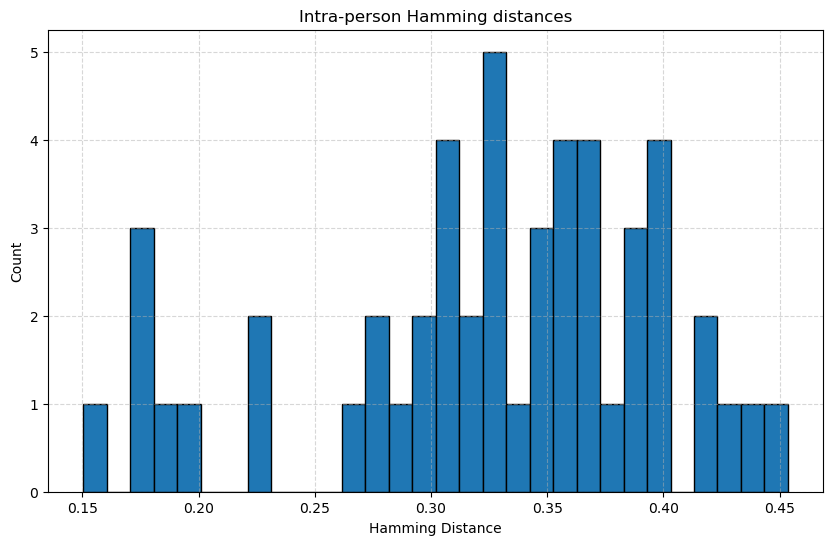

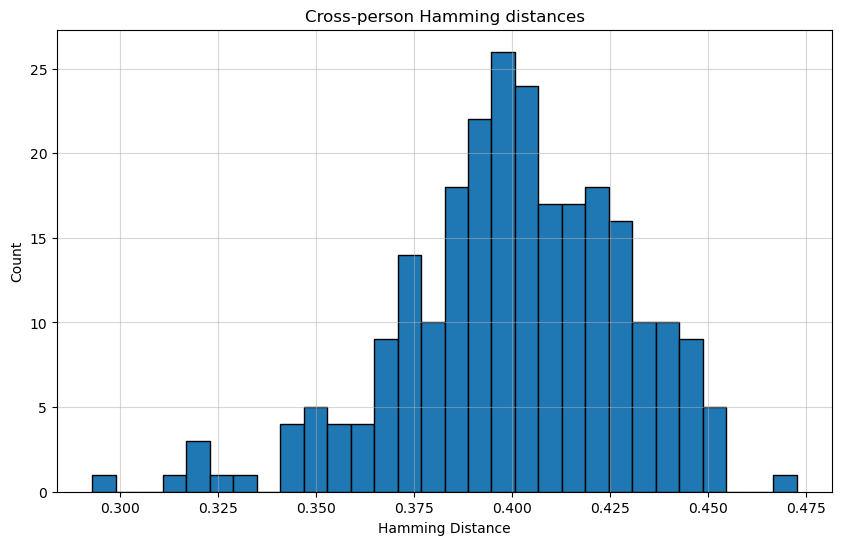

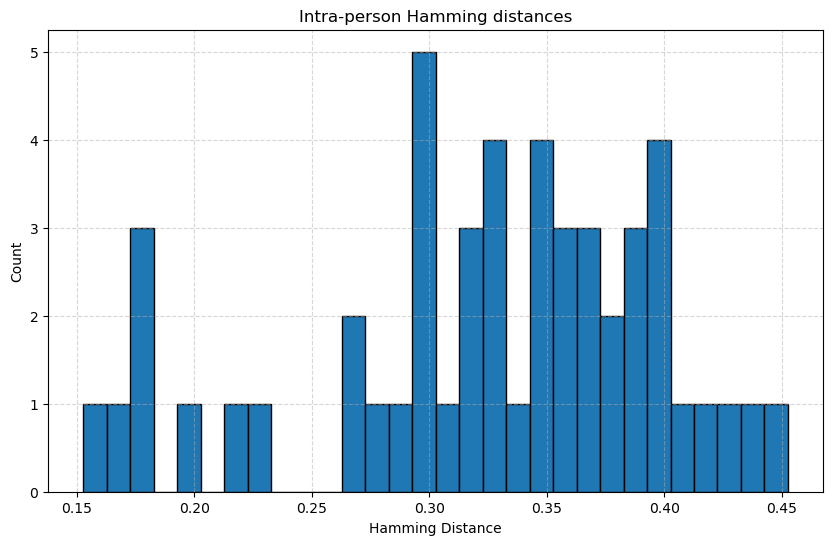

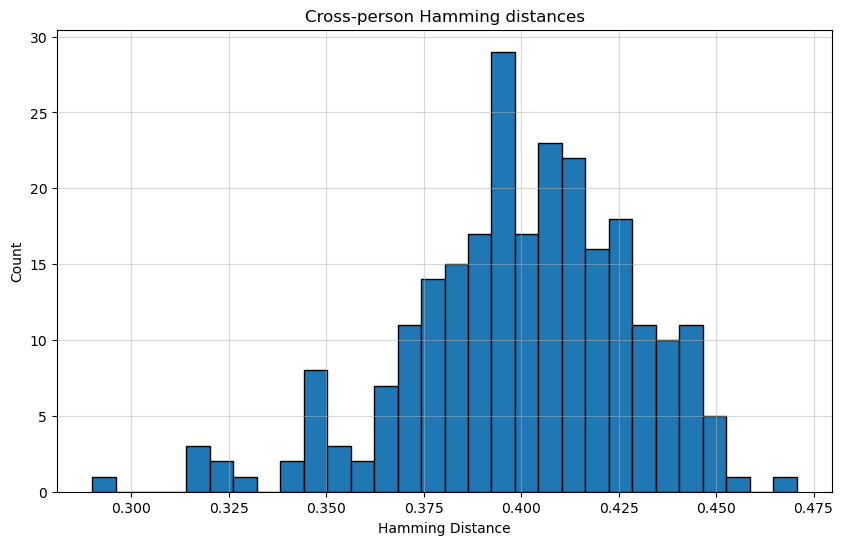

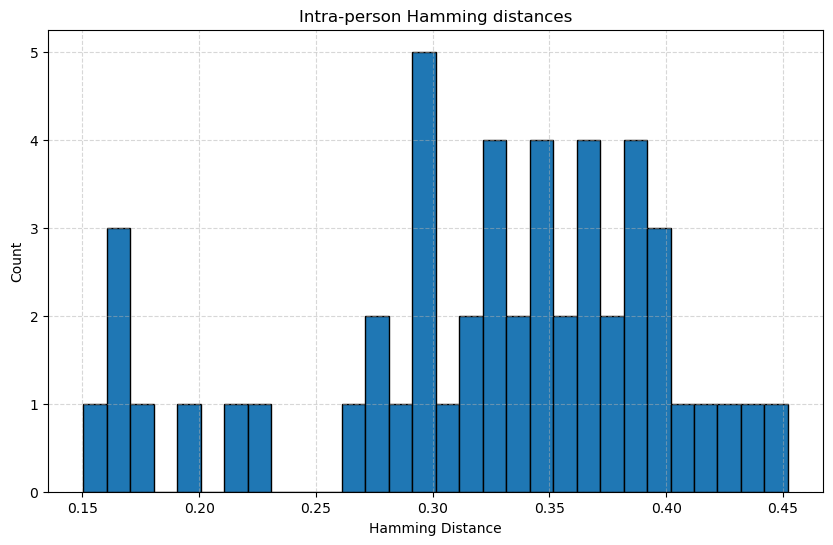

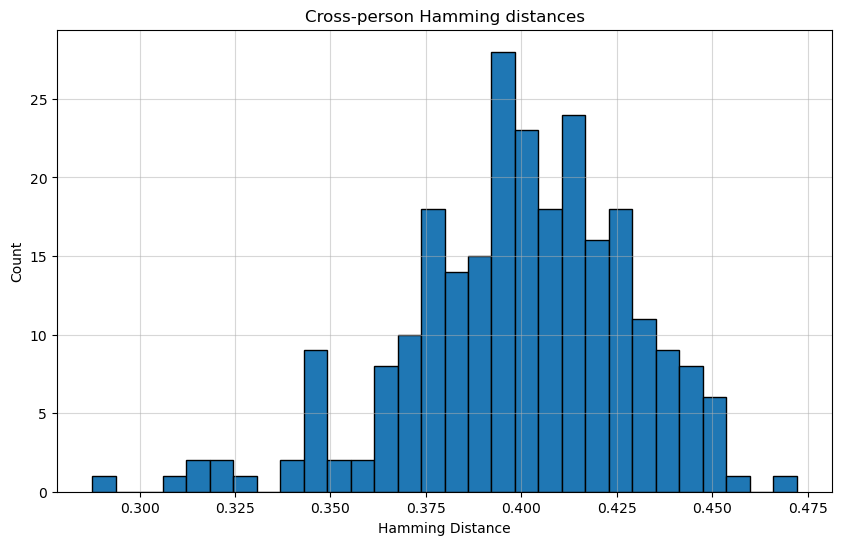

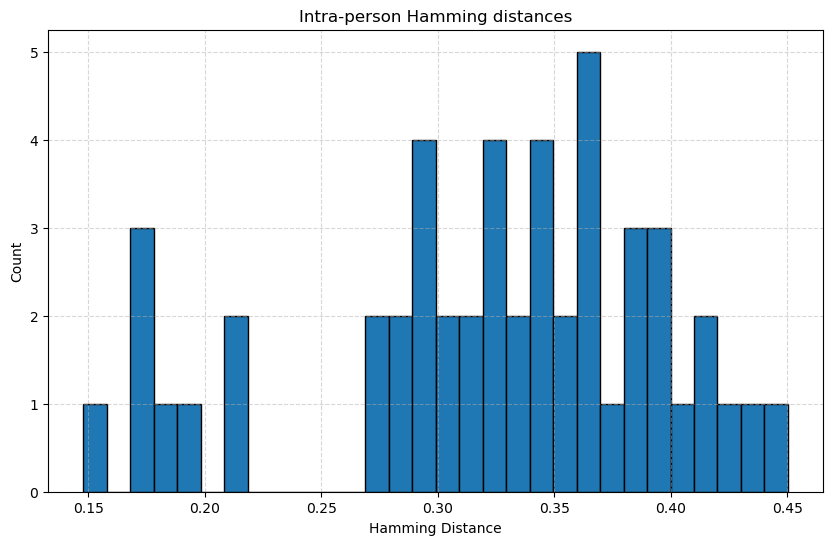

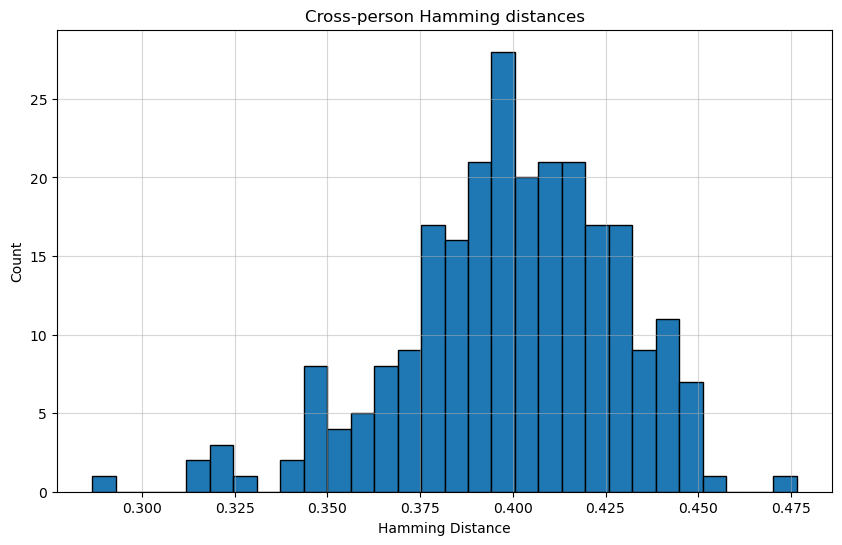

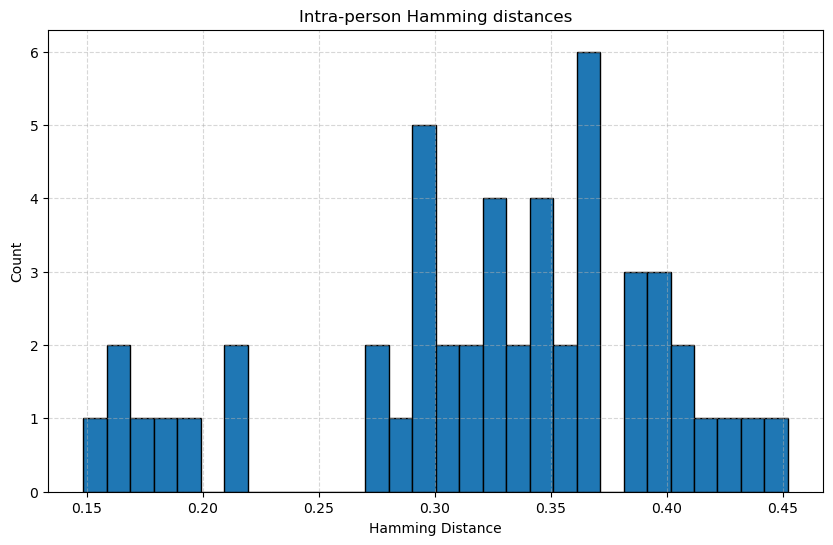

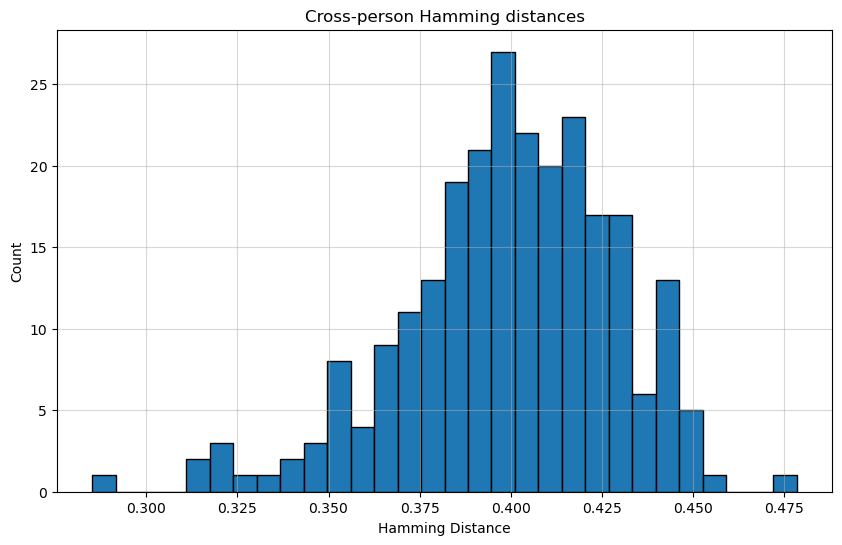

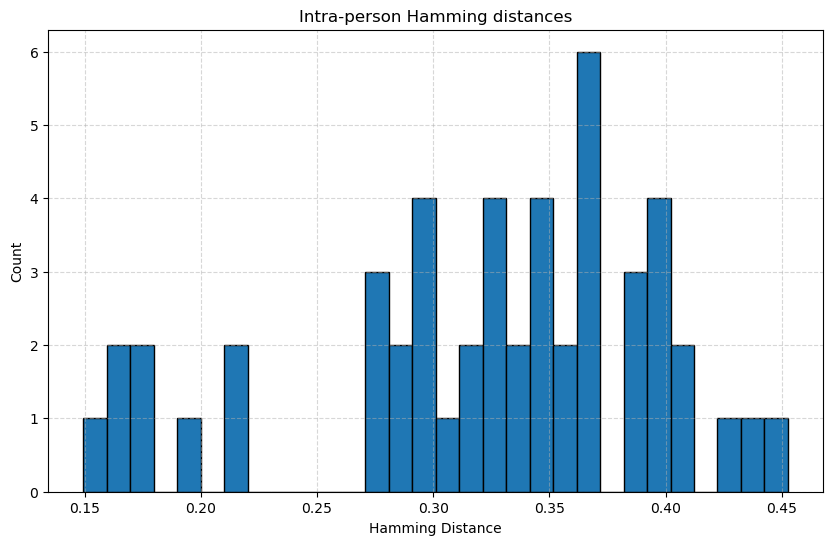

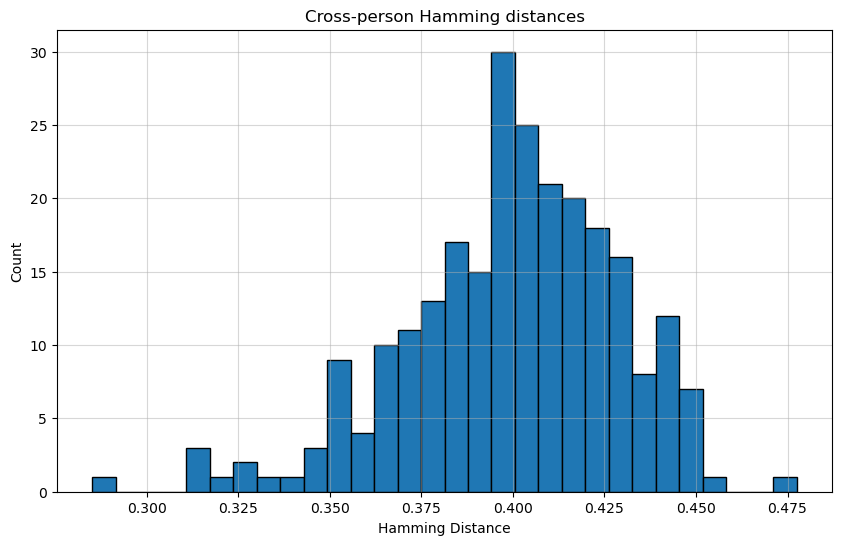

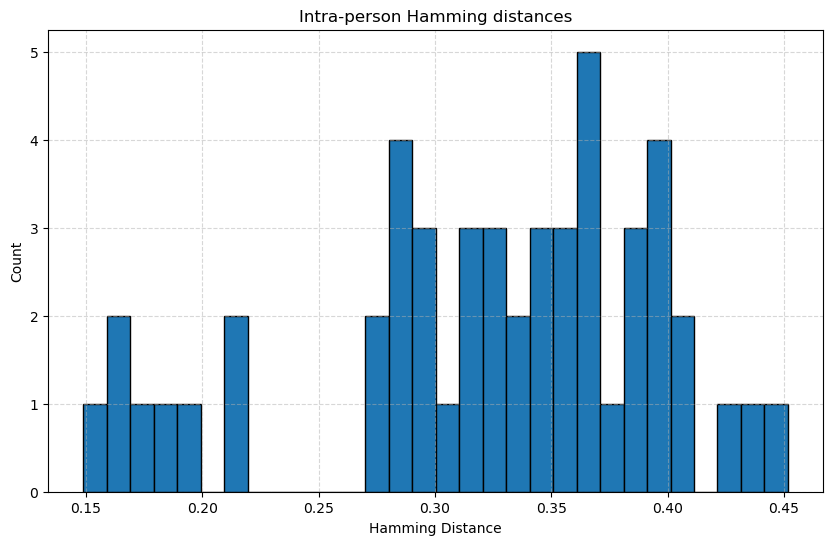

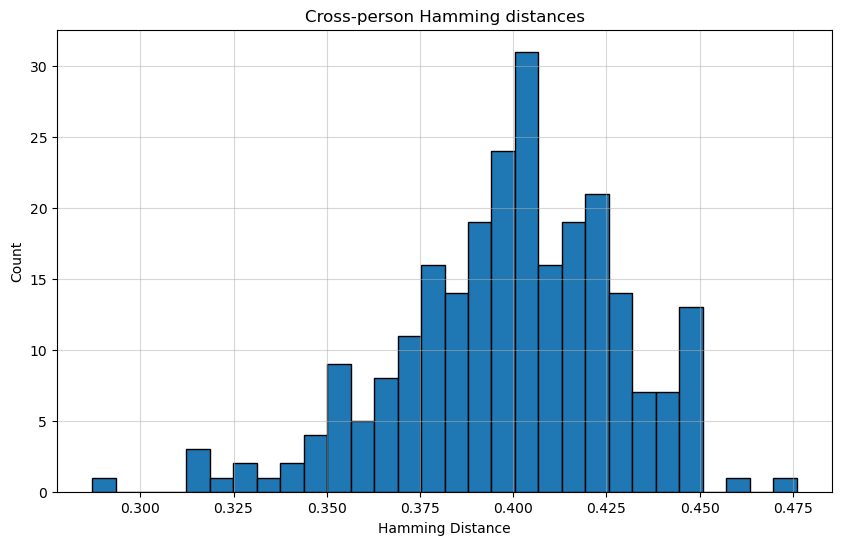

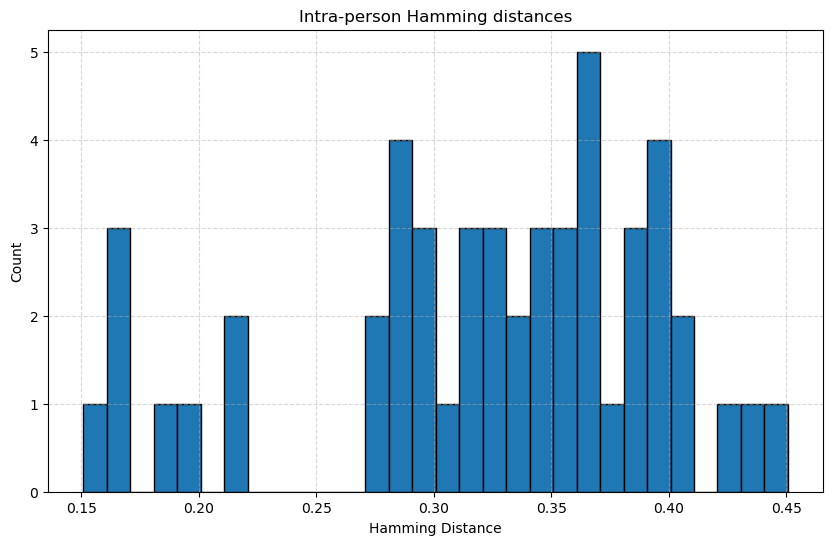

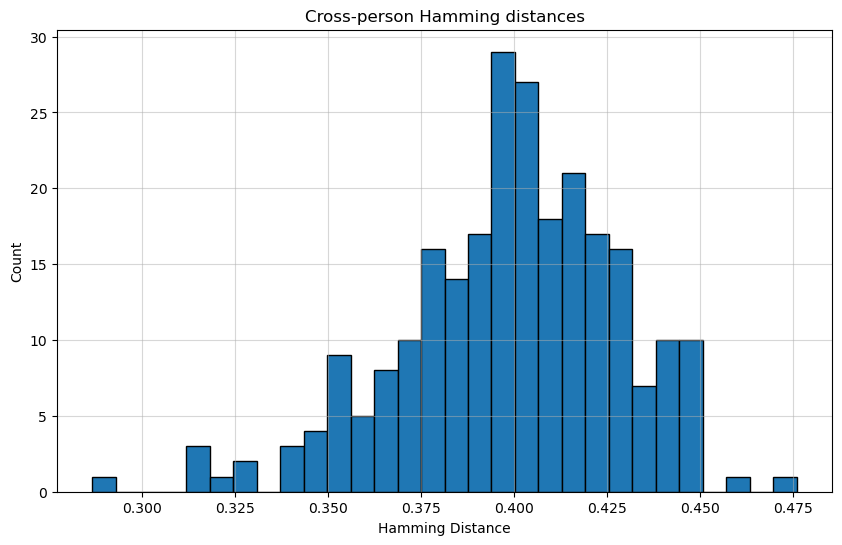

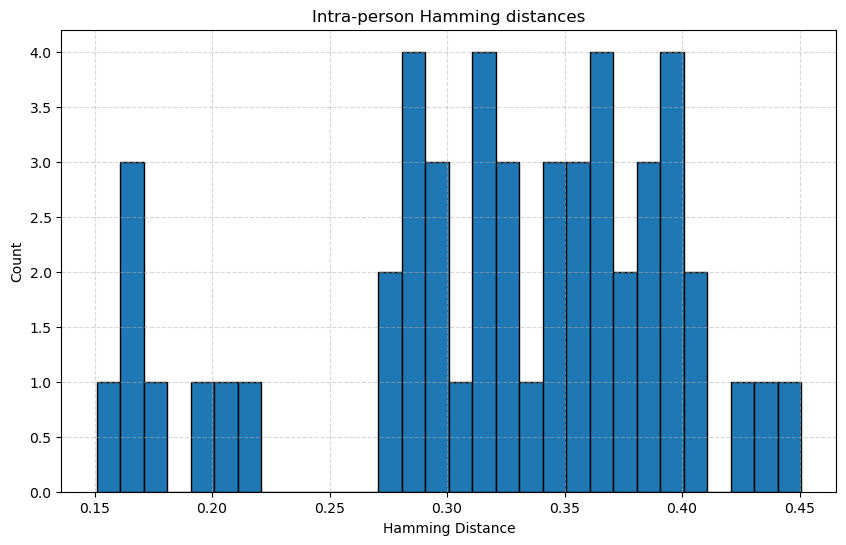

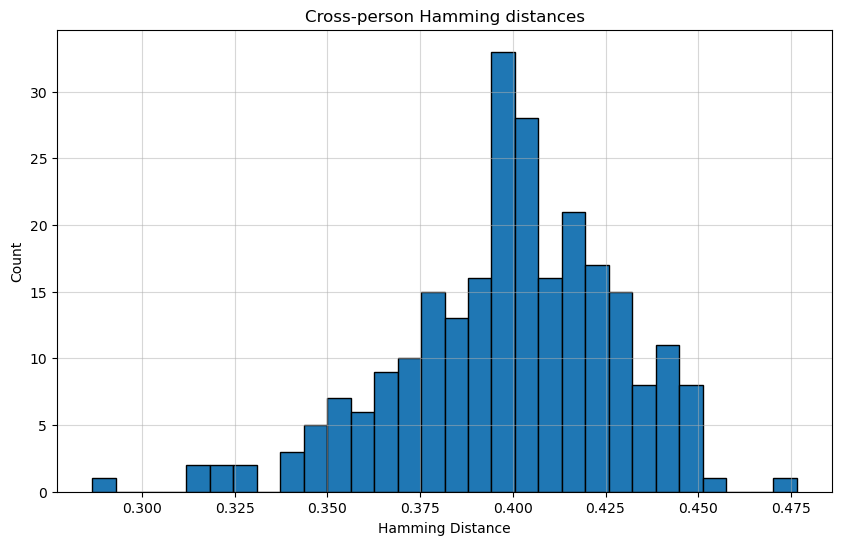

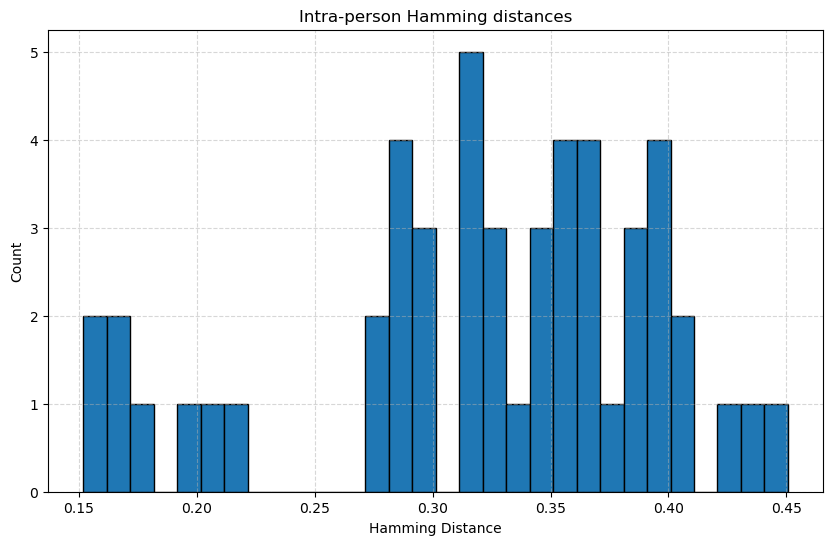

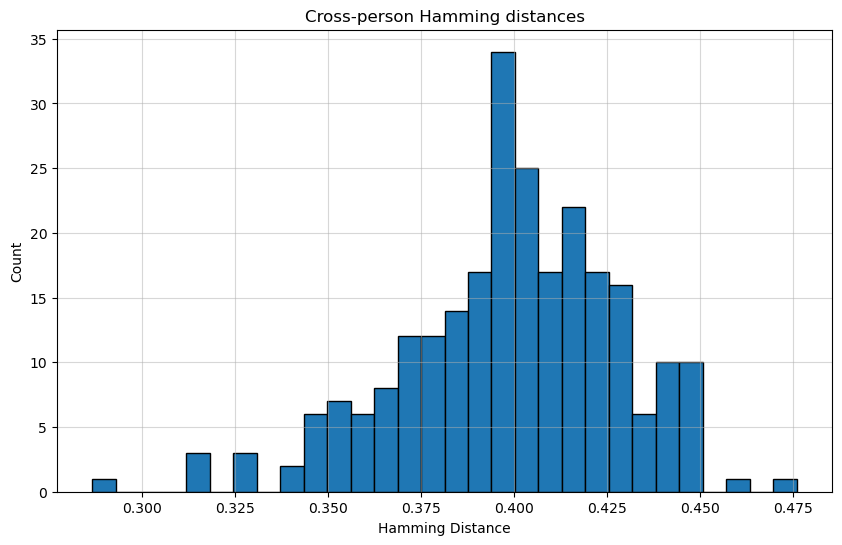

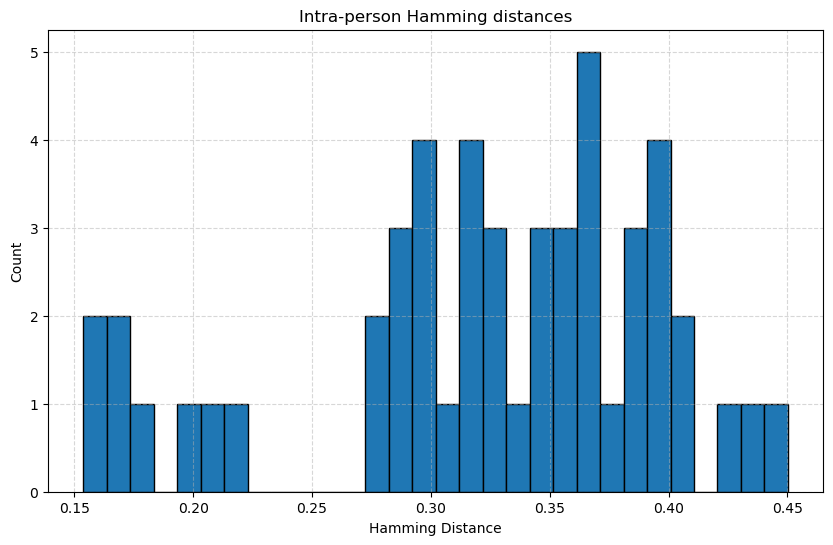

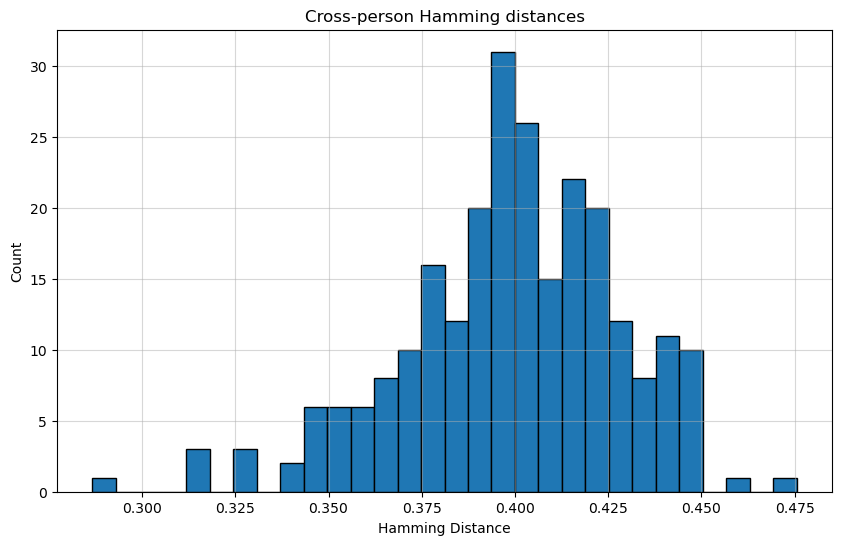

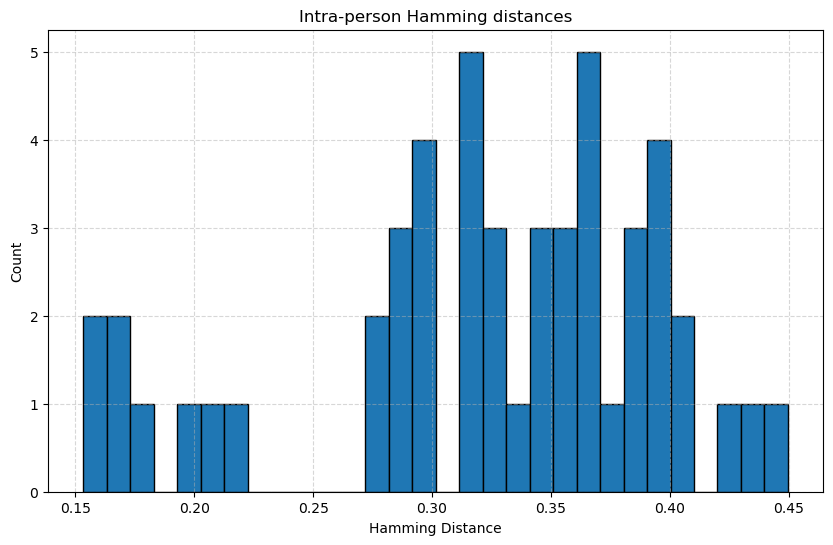

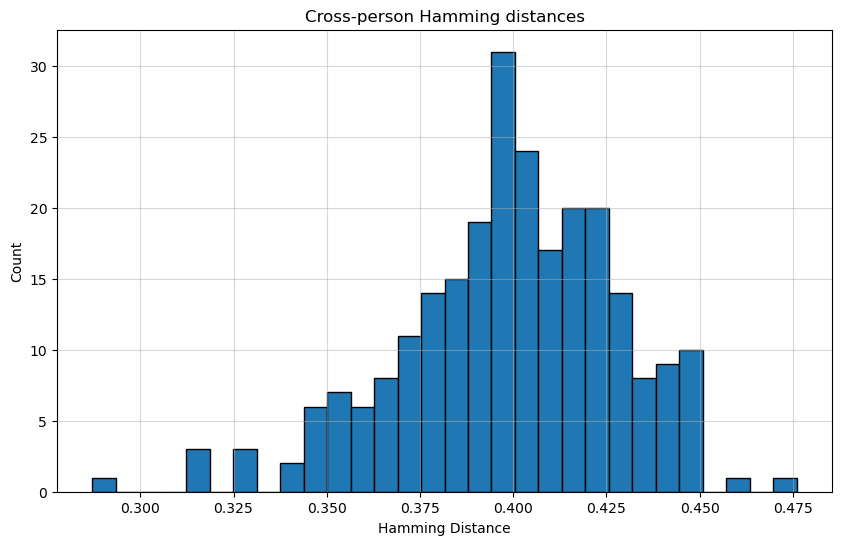

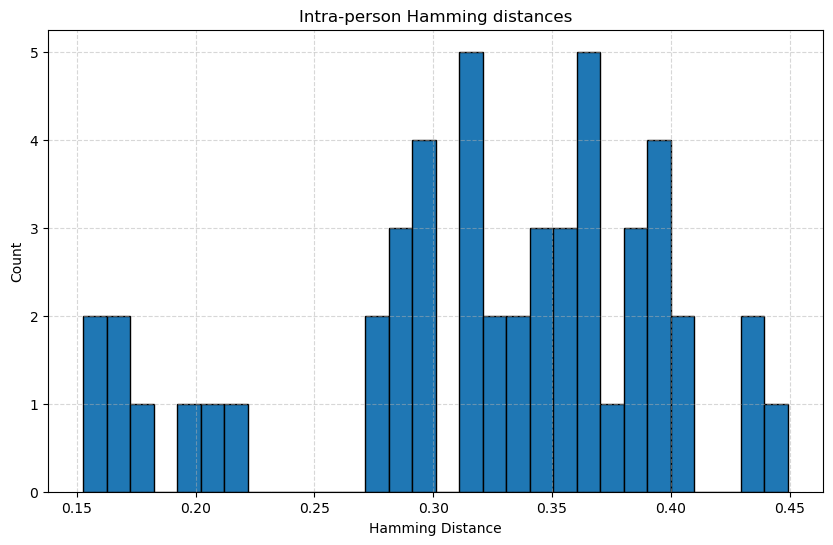

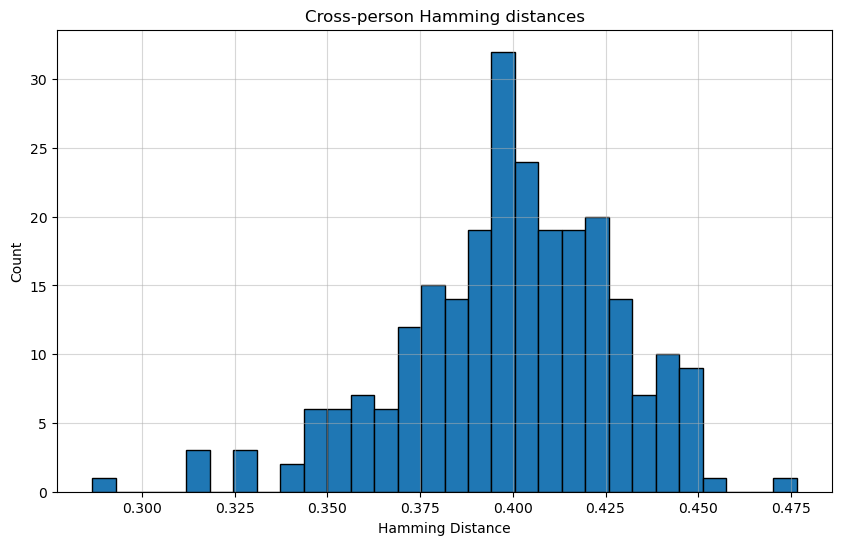

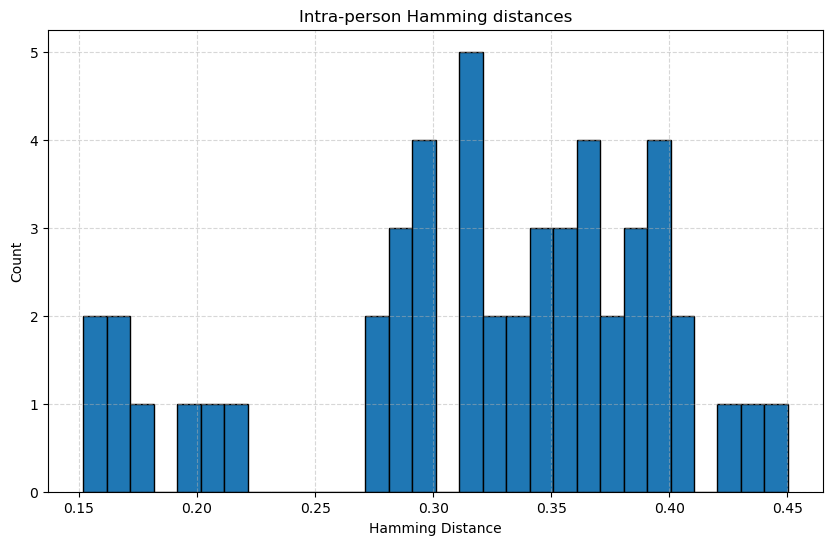

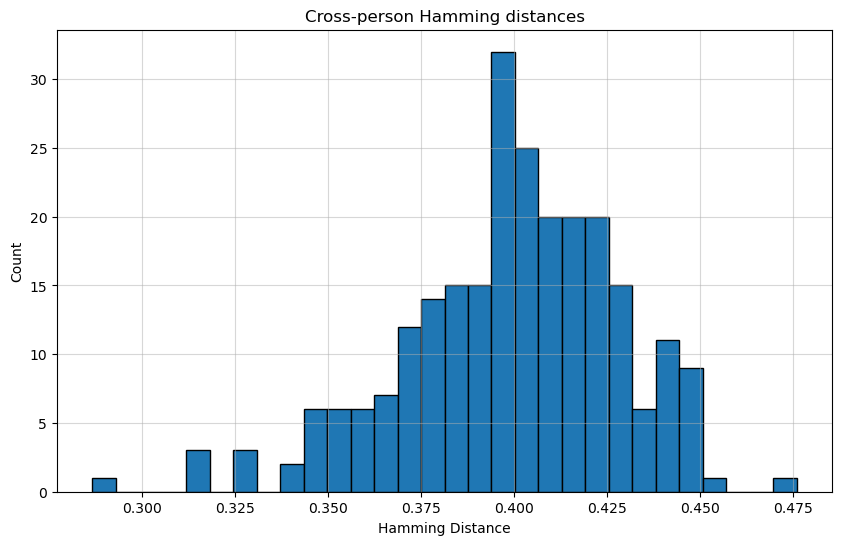

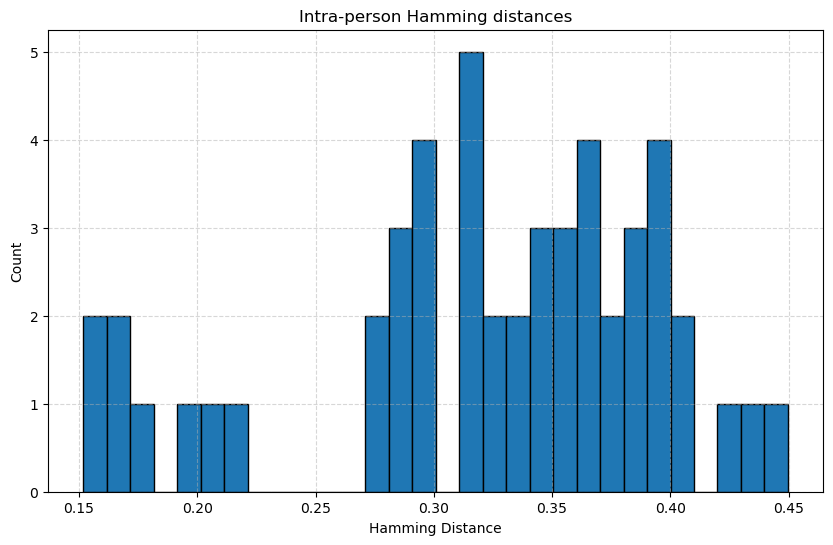

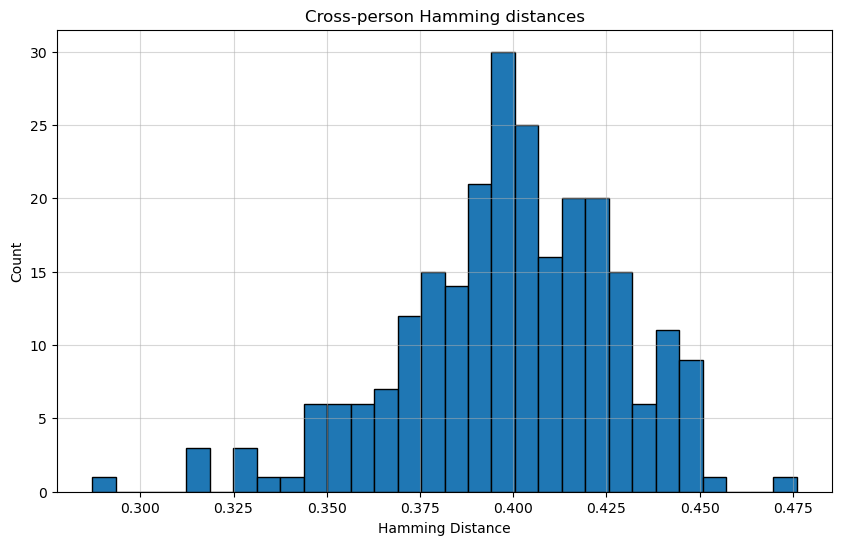

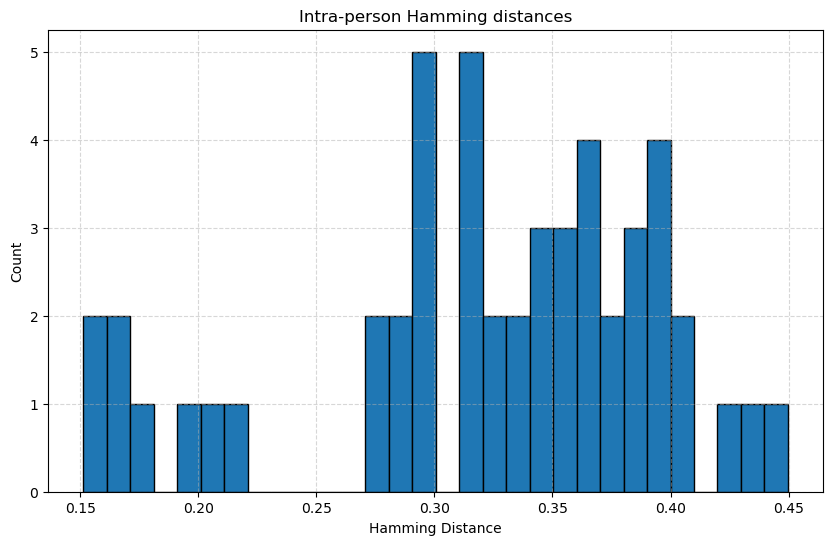

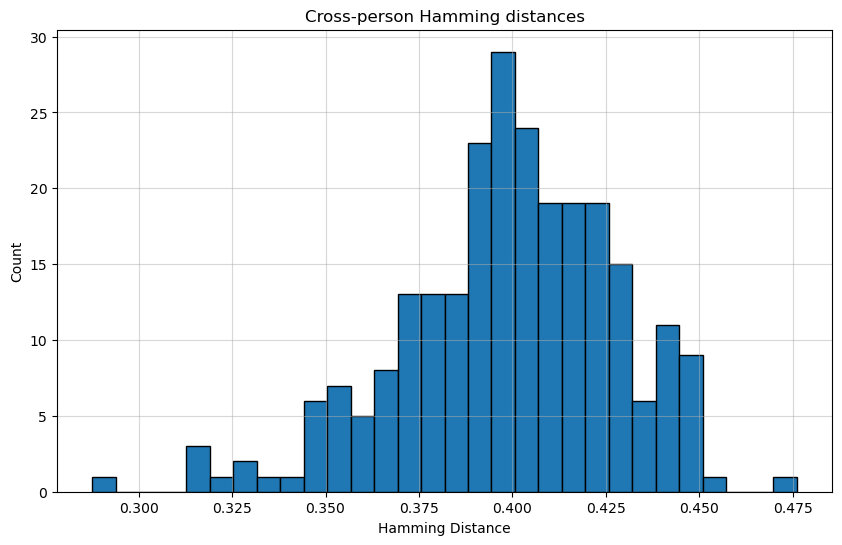

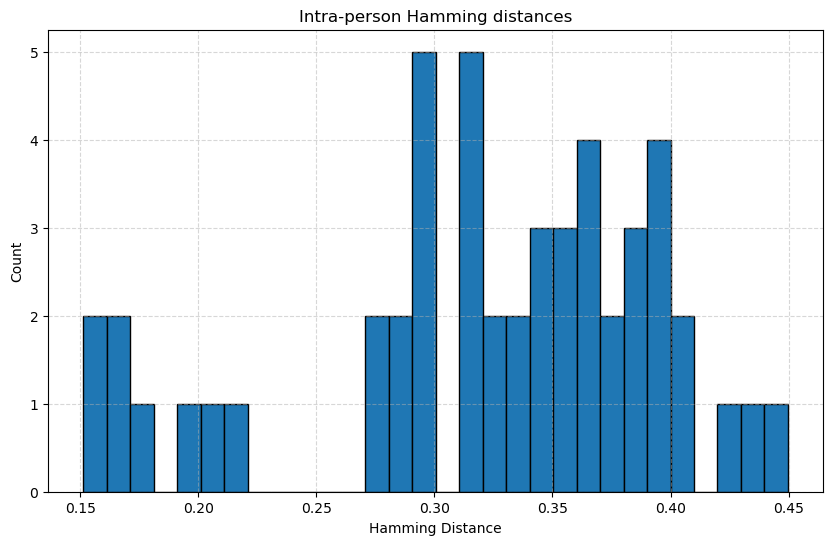

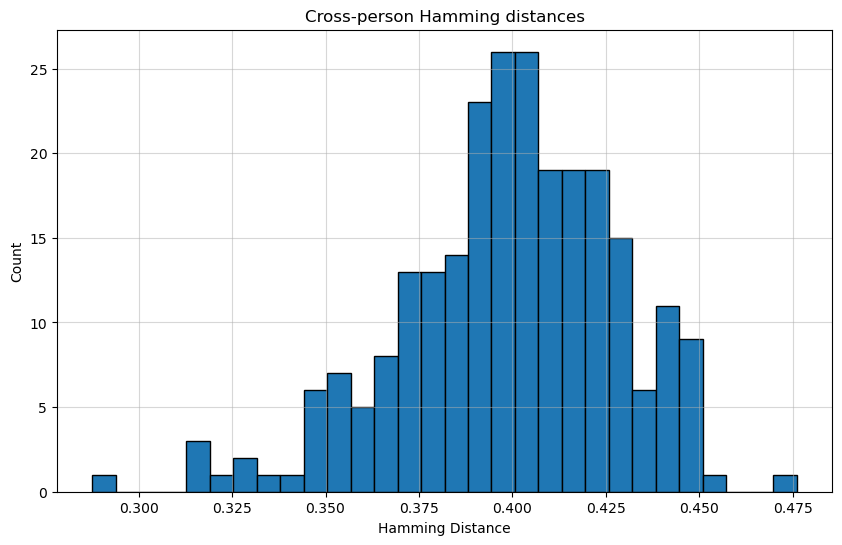

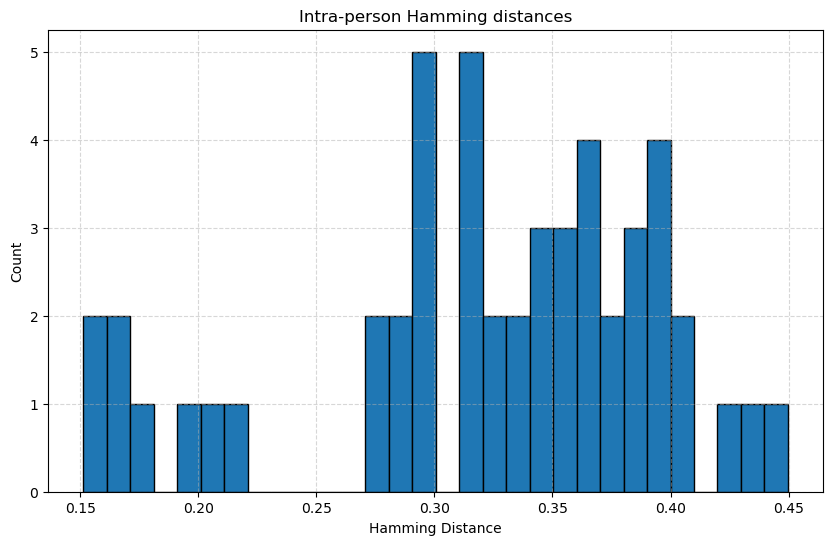

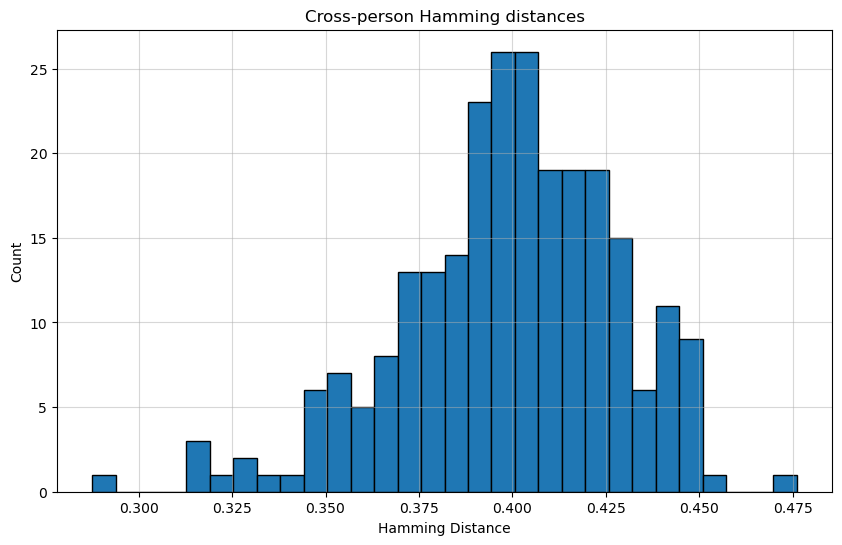

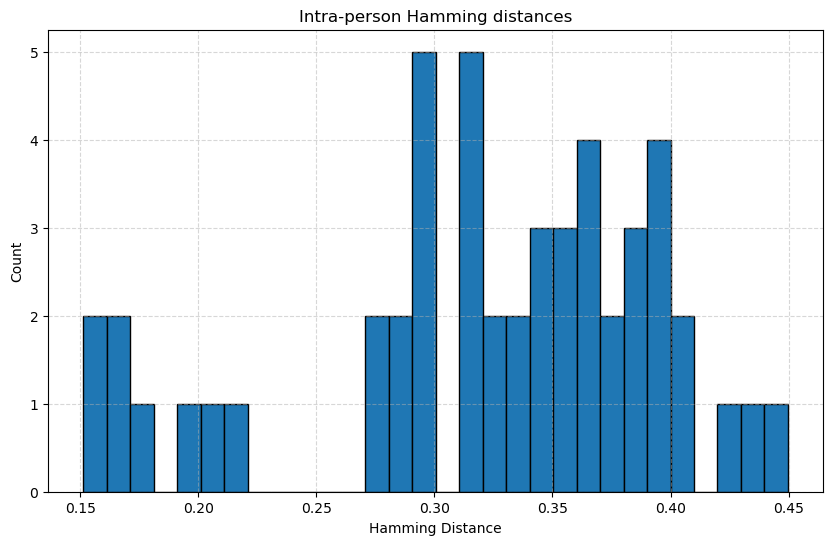

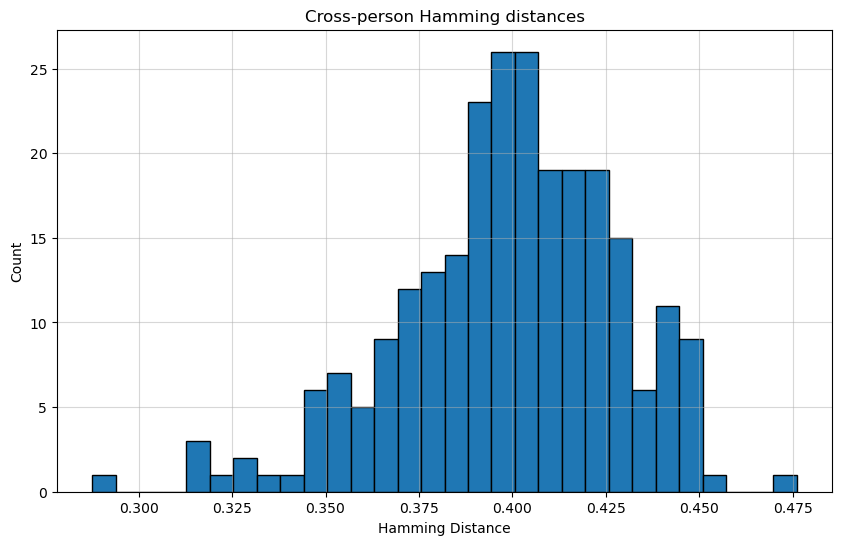

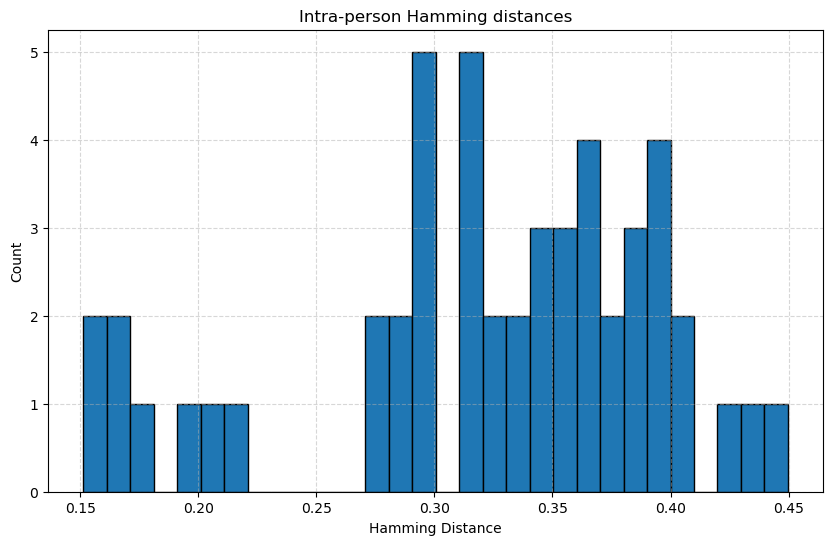

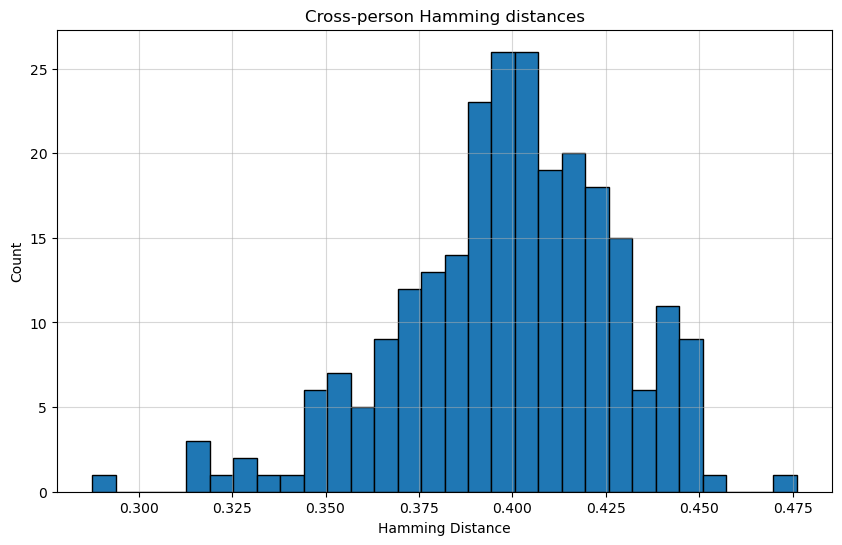

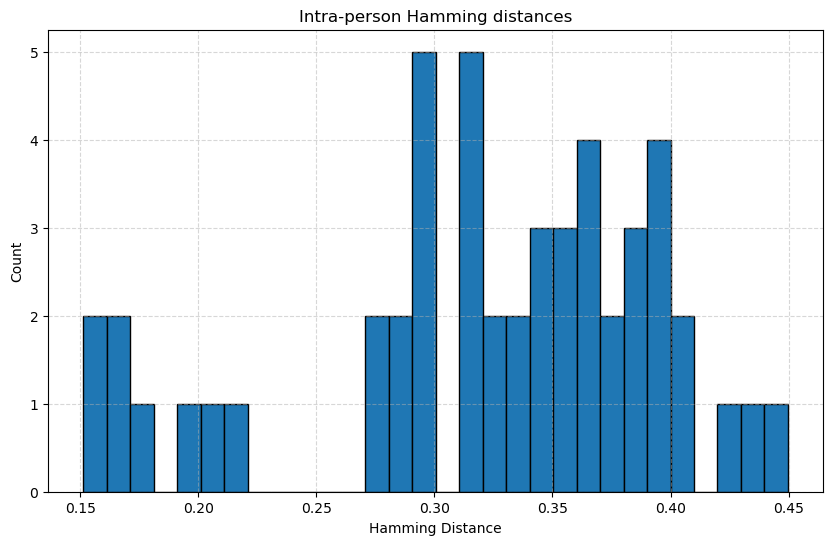

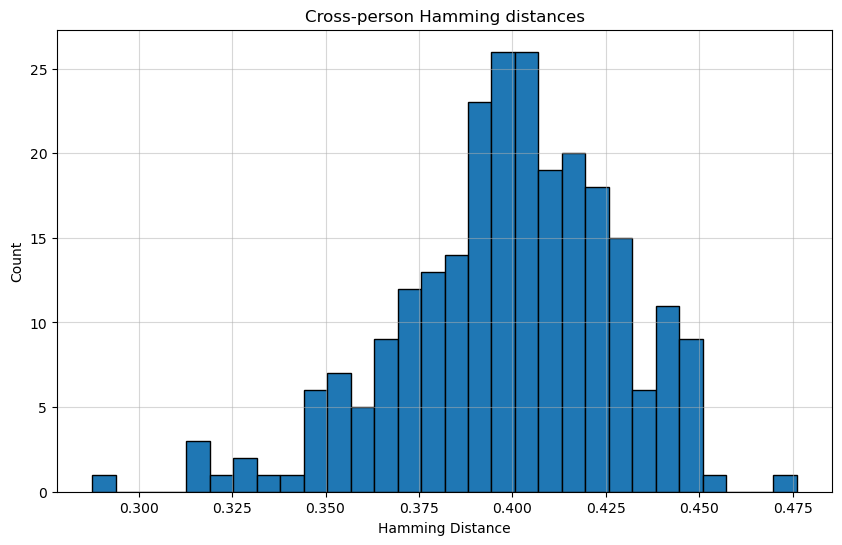

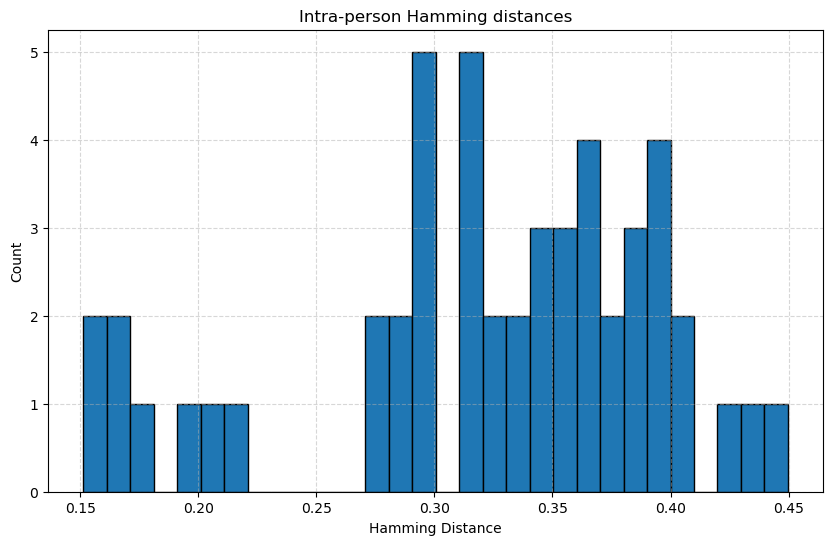

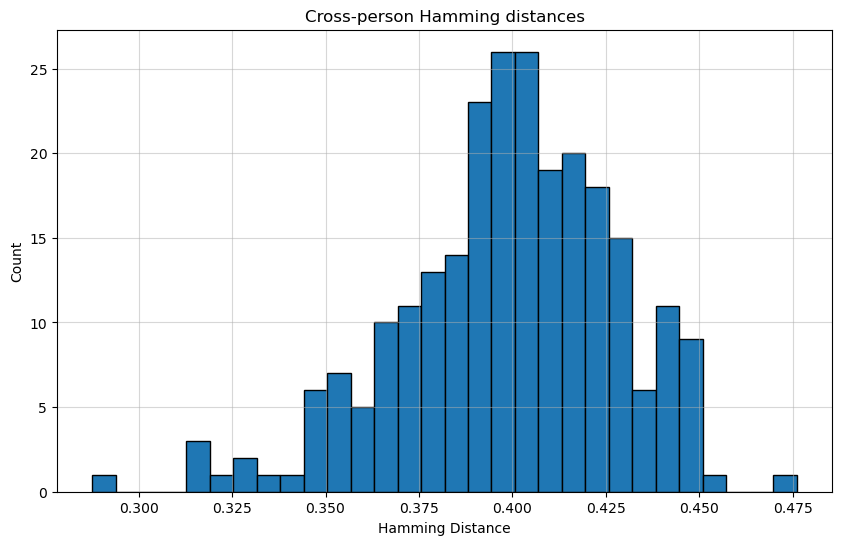

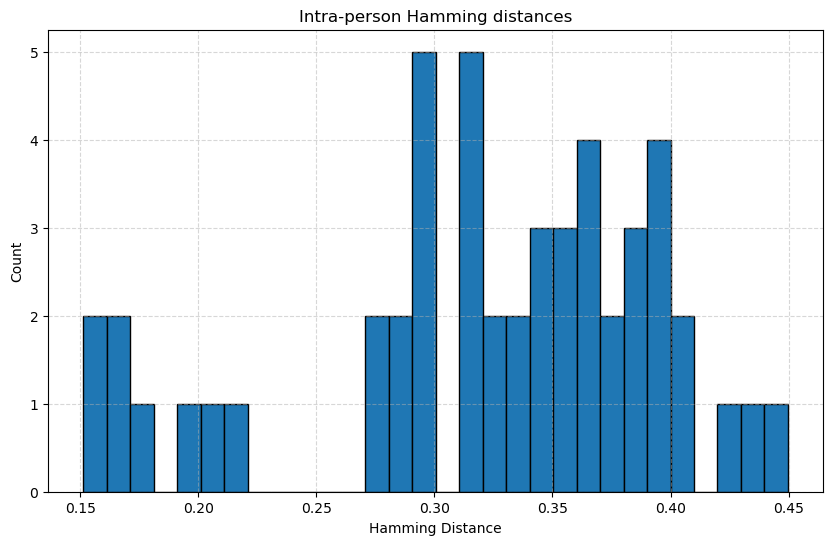

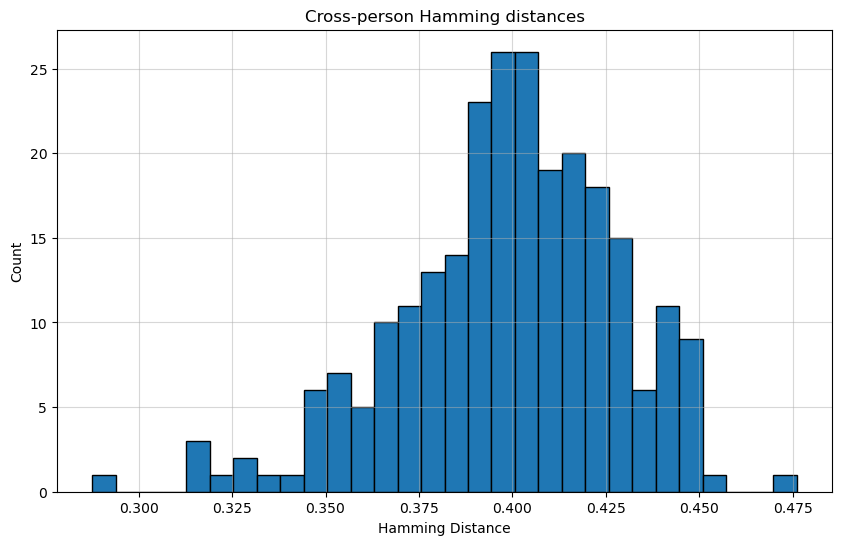

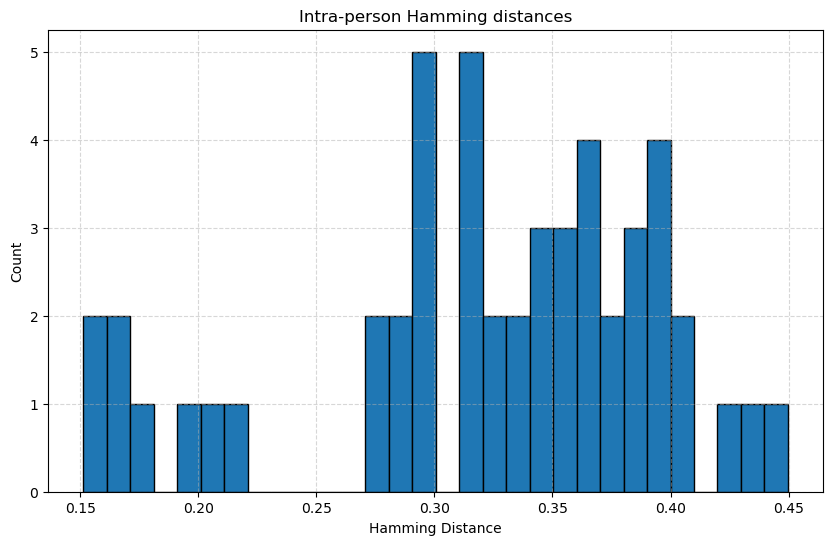

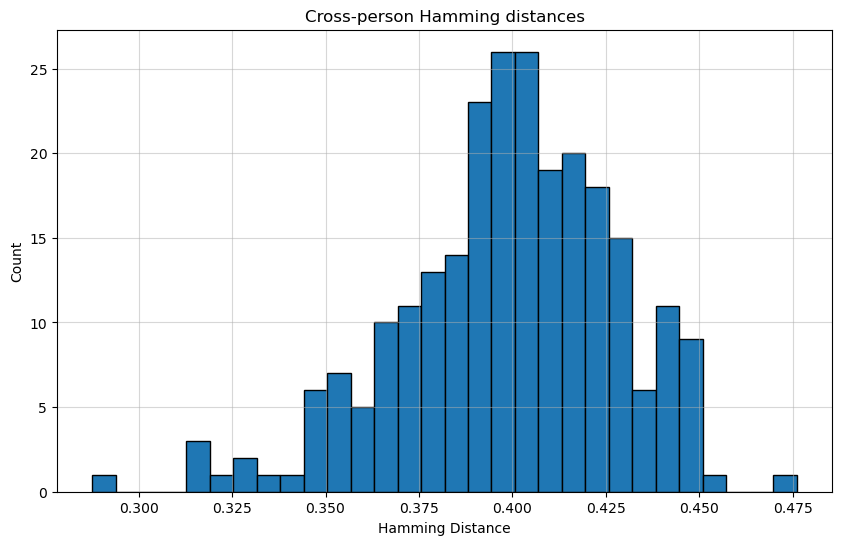

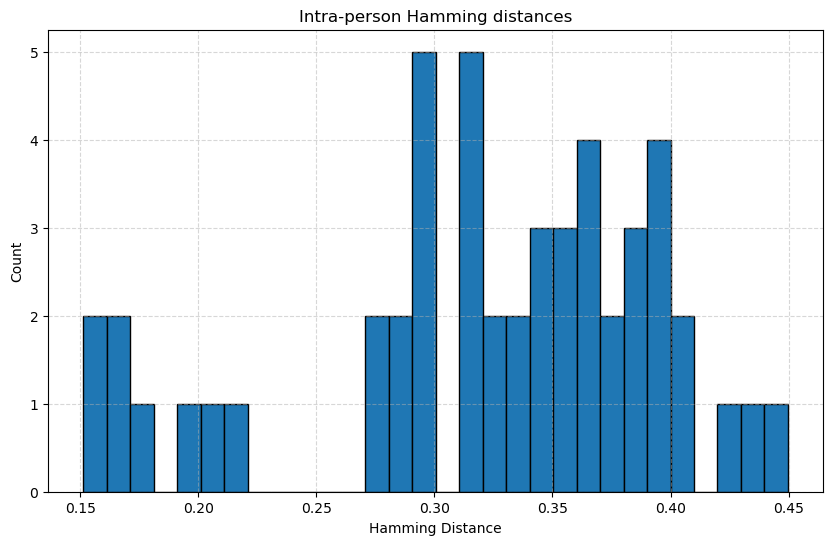

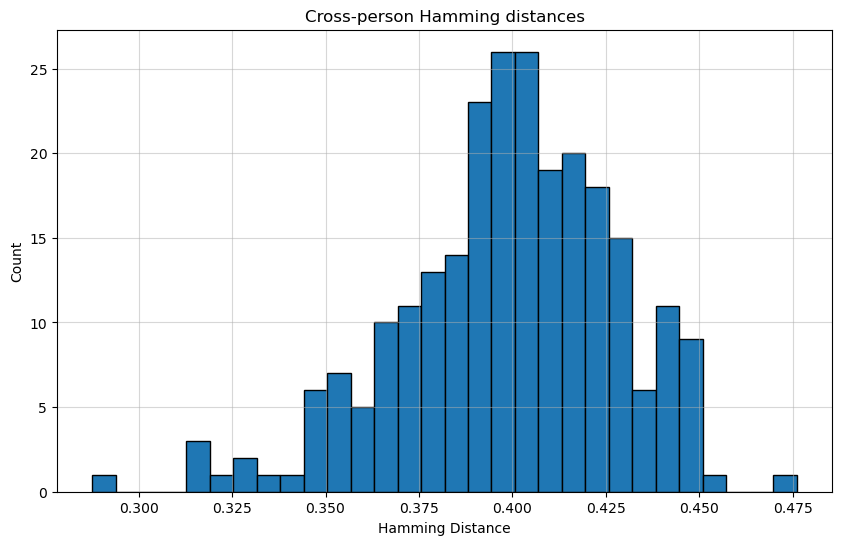

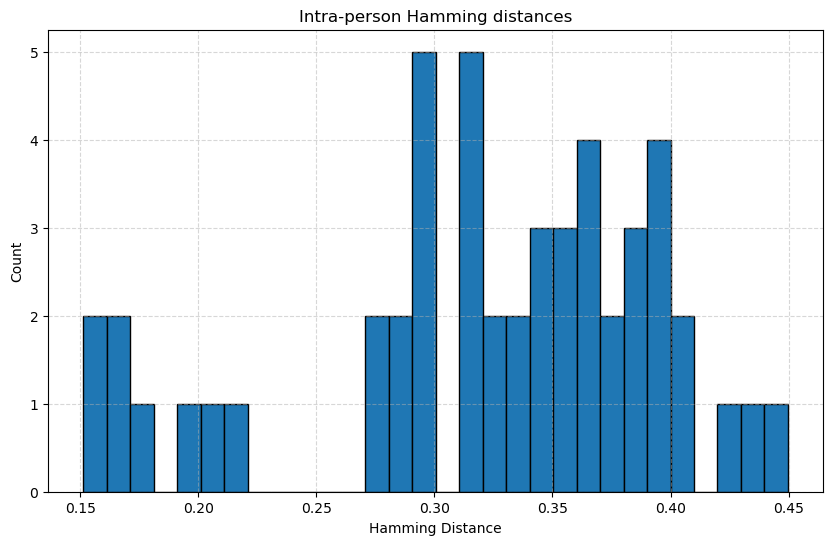

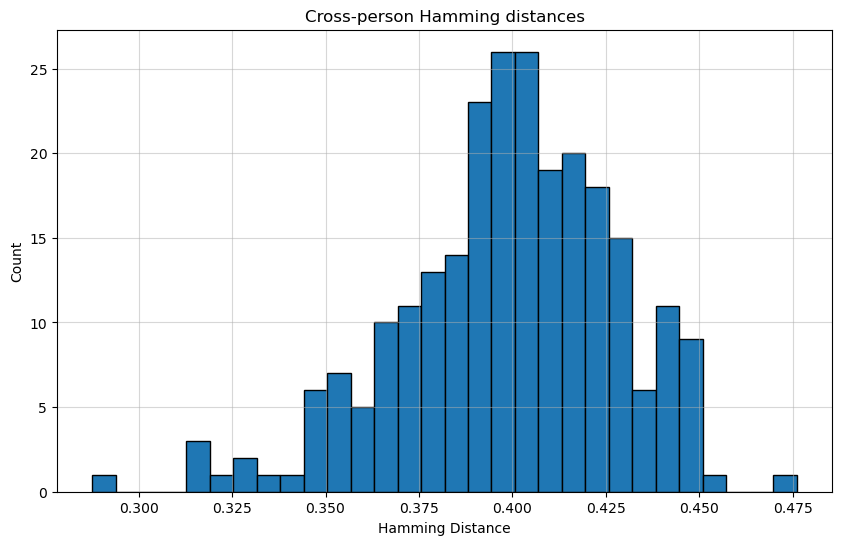

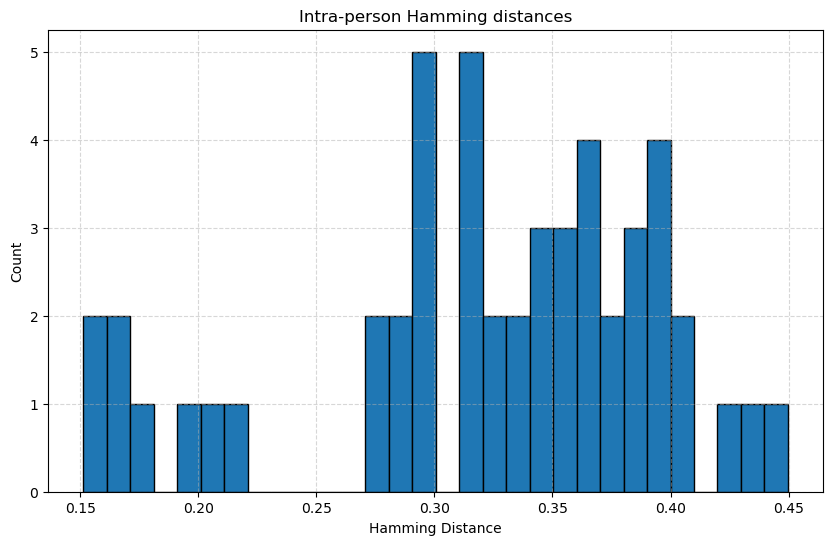

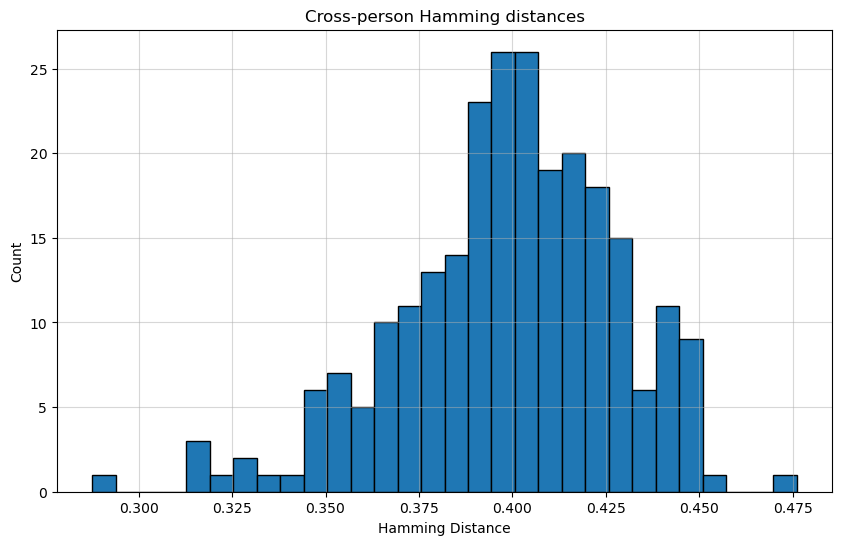

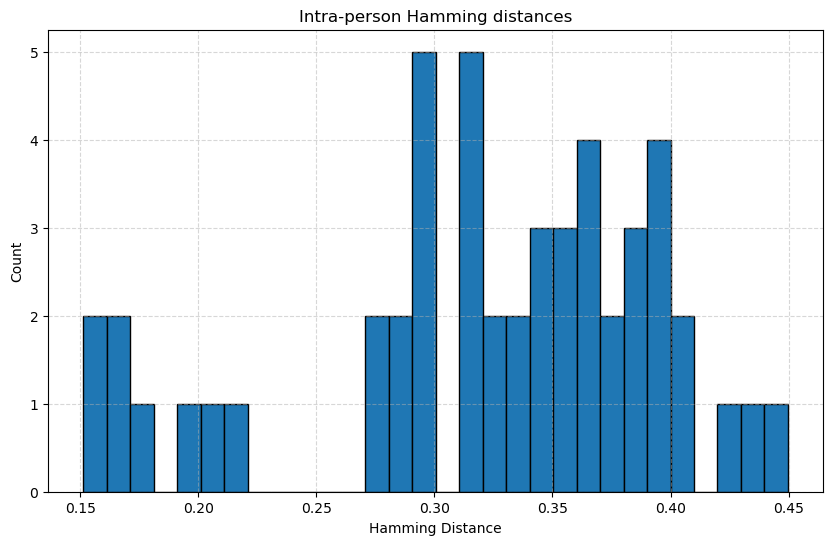

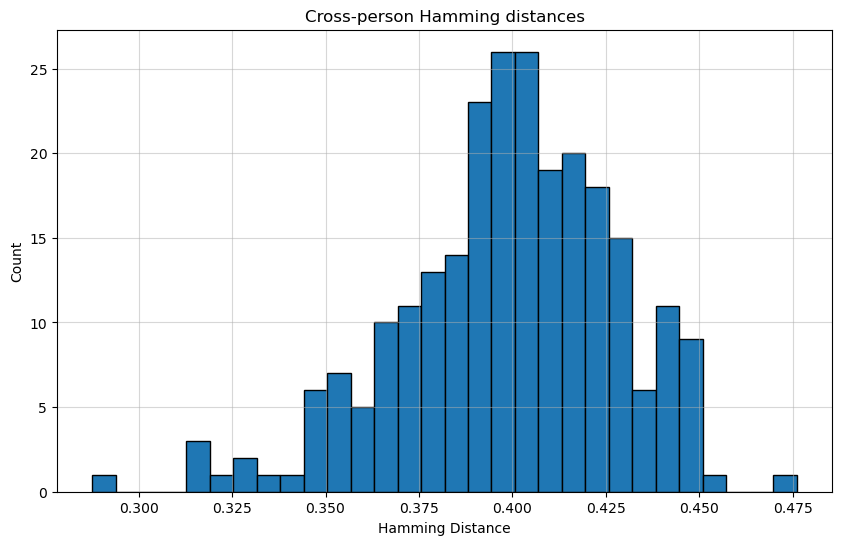

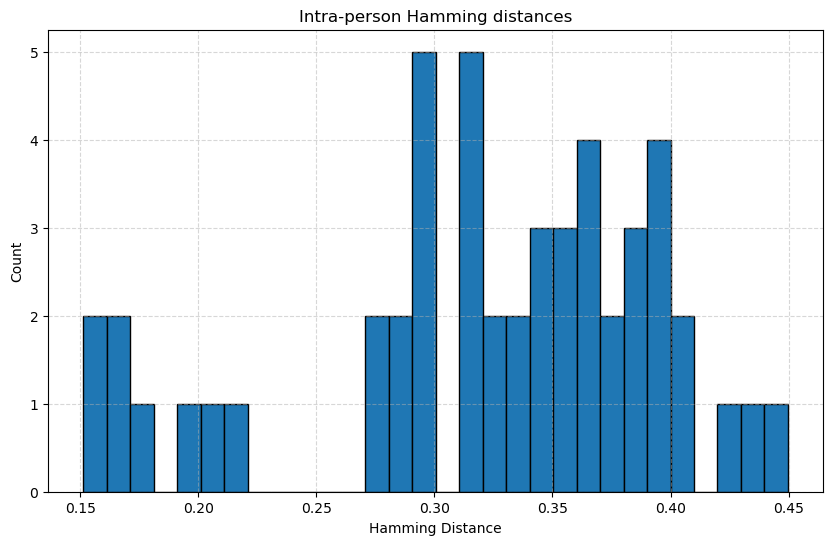

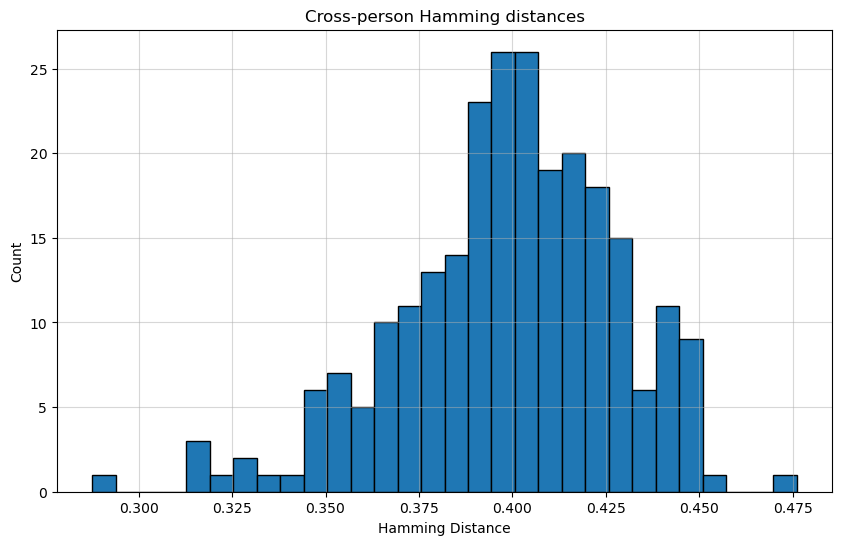

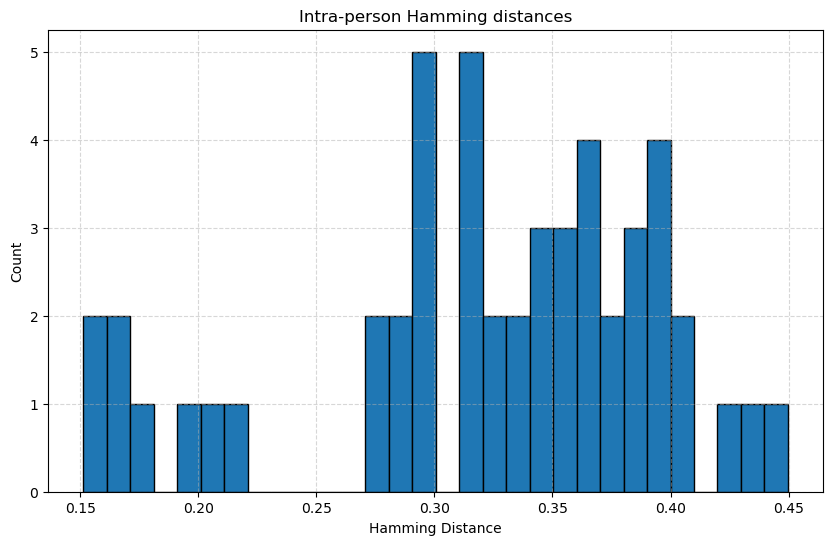

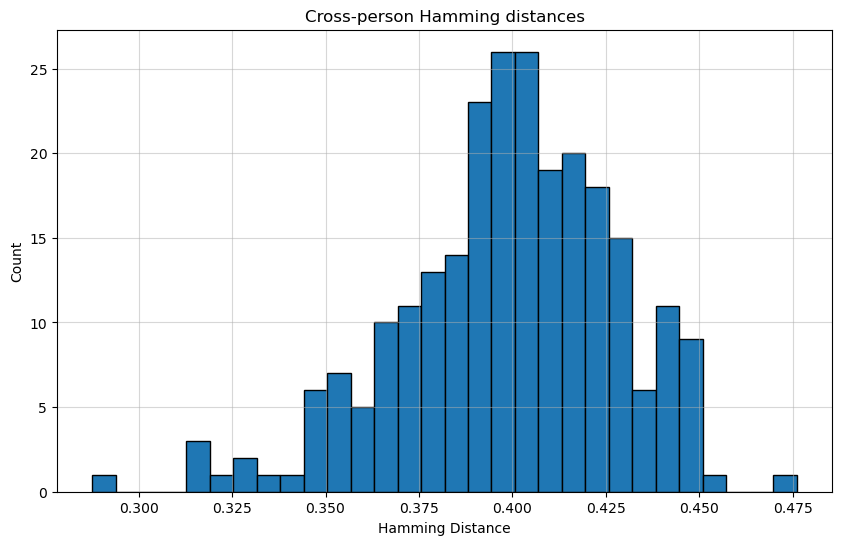

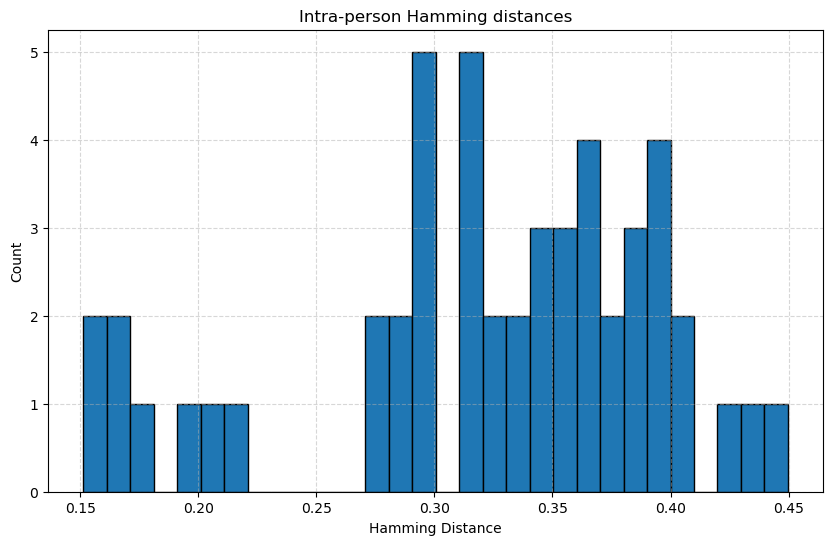

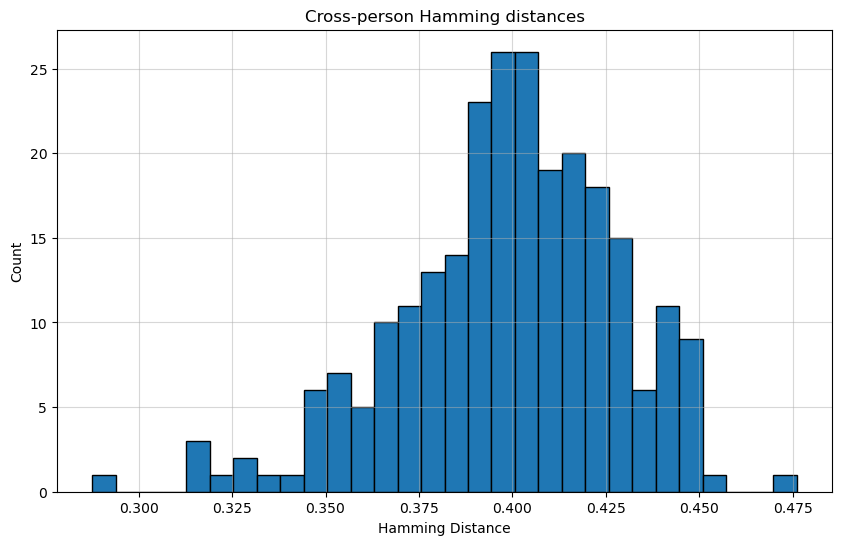

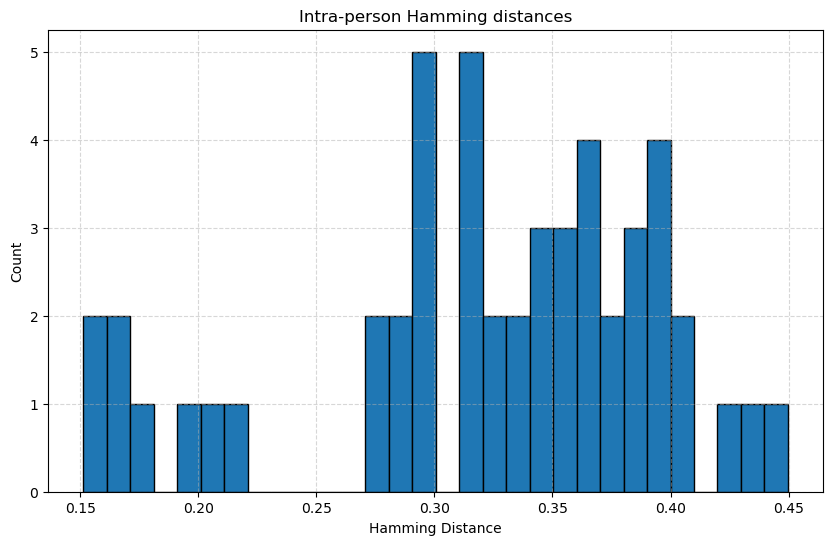

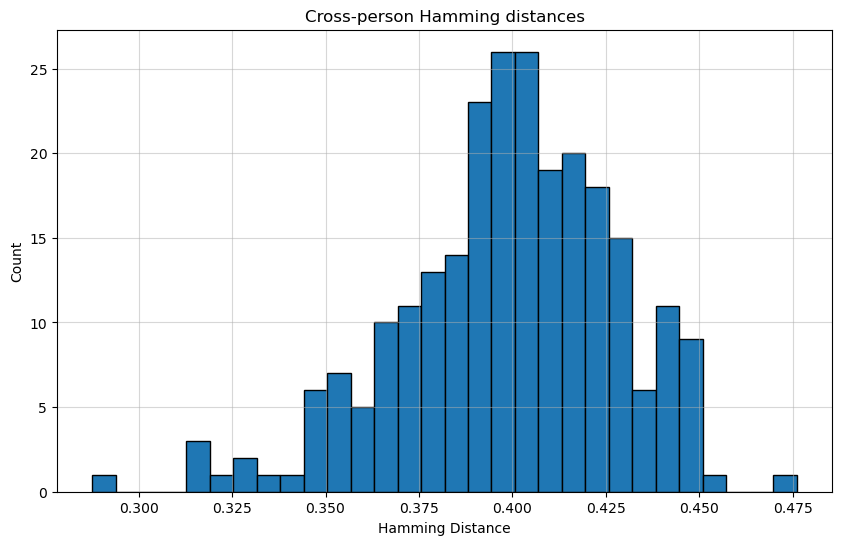

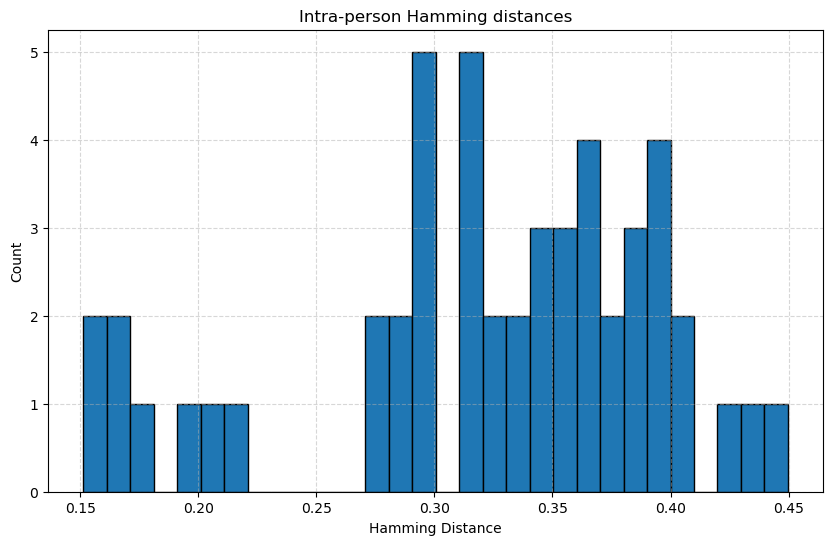

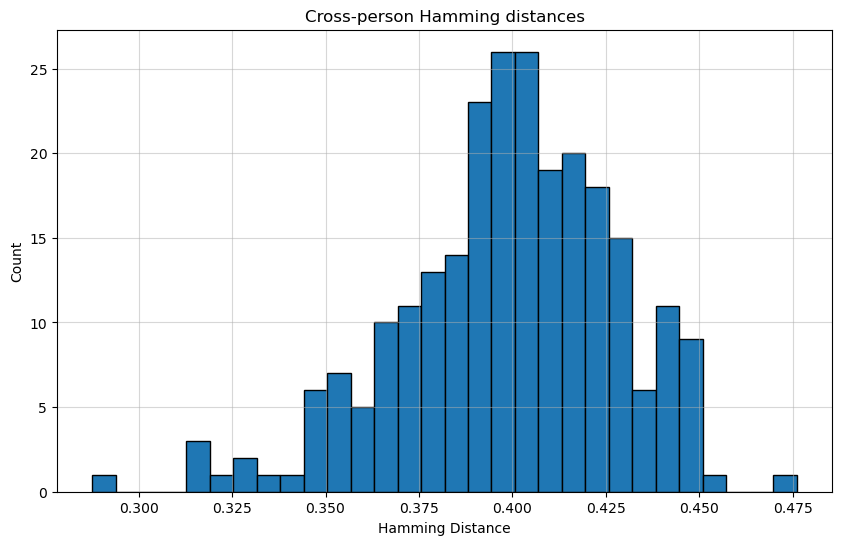

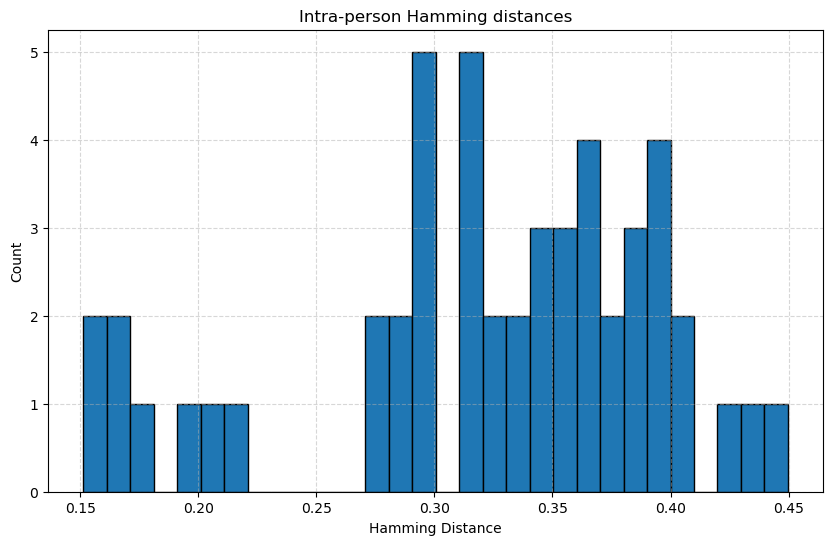

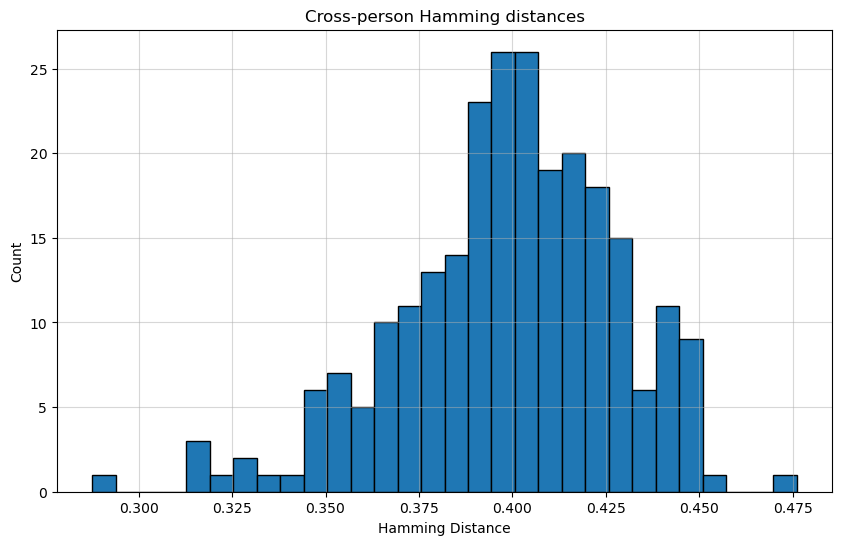

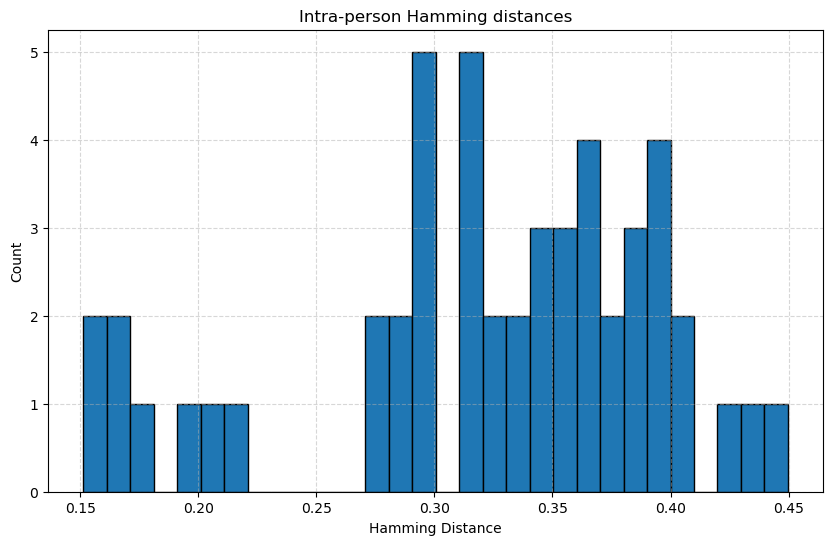

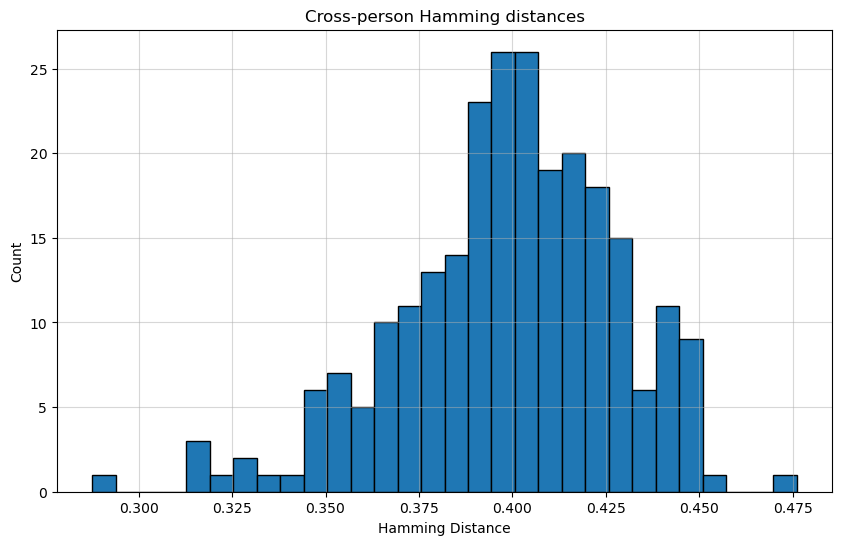

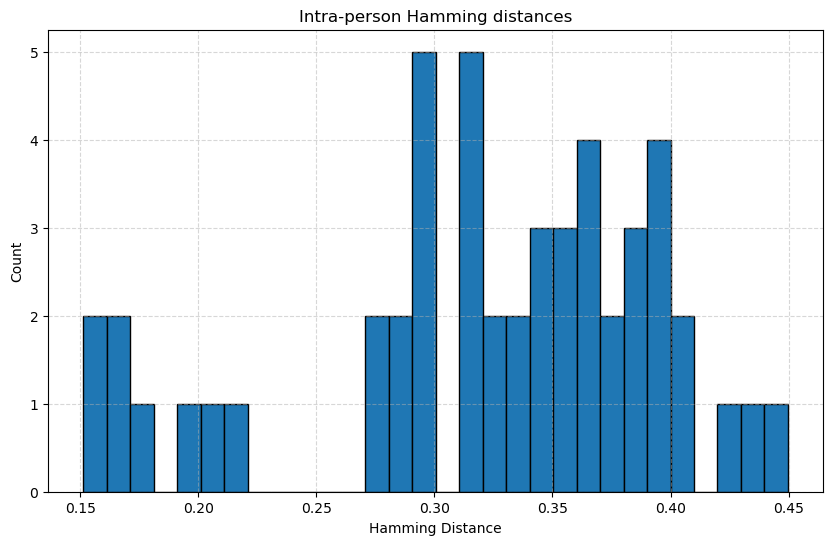

Best sigma: 8.900, delta difference = 0.07718


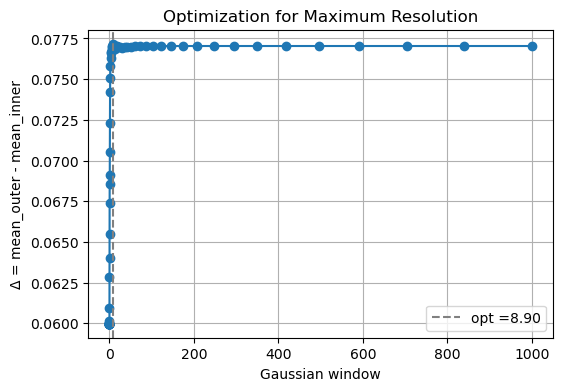

In [20]:
def delta_sigma(sigma, person_ids, eye, f_value):
    d_outer = compare_people_multiple(
        person_ids=person_ids,
        eye=eye,
        f_value=f_value,
        verbose=False,
        sigma=sigma
    )

    d_inner = compare_within_persons_range(
        person_ids=person_ids,
        eye=eye,
        f_value=f_value,
        verbose=False,
        sigma=sigma
    )
    return np.mean(d_outer) - np.mean(d_inner)

# Experimental parameters
person_ids = [41, 42, 43, 44, 45]
eye       = "left"
f_value   = np.pi

# Range of σ to search
sigmas = np.logspace(-3, 3, 80)

# Calculate Δ for each σ
deltas = [delta_sigma(s, person_ids, eye, f_value) for s in sigmas]

best_idx   = np.argmax(deltas)
best_sigma = sigmas[best_idx]
best_delta = deltas[best_idx]

print(f"Best sigma: {best_sigma:.3f}, delta difference = {best_delta:.5f}")

plt.figure(figsize=(6,4))
plt.plot(sigmas, deltas, marker='o')
plt.axvline(best_sigma, color='gray', linestyle='--',
            label=f"opt ={best_sigma:.2f}")
plt.xlabel("Gaussian window")
plt.ylabel("Δ = mean_outer - mean_inner")
plt.title("Optimization for Maximum Resolution")
plt.legend()
plt.grid(True)
plt.show()


### **Checking of the matching**

C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:635: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(path1)
C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:636: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(path2)


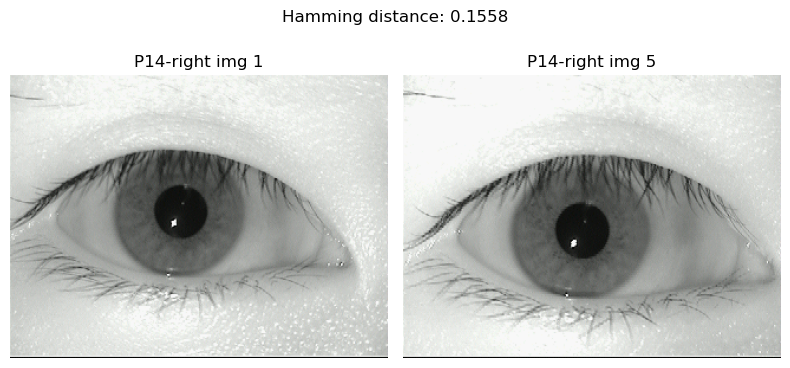

✅ Iris match!
Hamming distance: 0.1558


In [21]:
d = compare_two_images(
    person_id1=14,
    eye1="right",
    index1=1,
    index2=5,
    f_value=np.pi,
    sigma=4.42
)

C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:635: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(path1)
C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:636: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(path2)


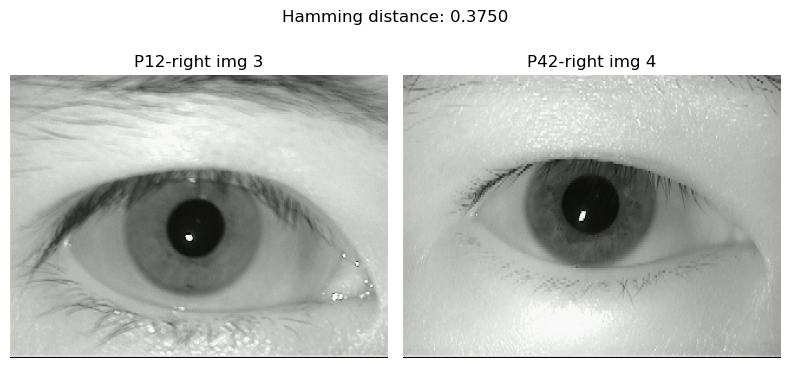

❌ Iris mismatch!
Hamming distance: 0.3750


In [22]:
d = compare_two_images(
    person_id1=12,
    eye1="right",
    index1=3,
    person_id2=42,
    eye2="right",
    index2=4,
    f_value=np.pi,
    sigma=4.42
)

C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:635: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(path1)
C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:636: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(path2)


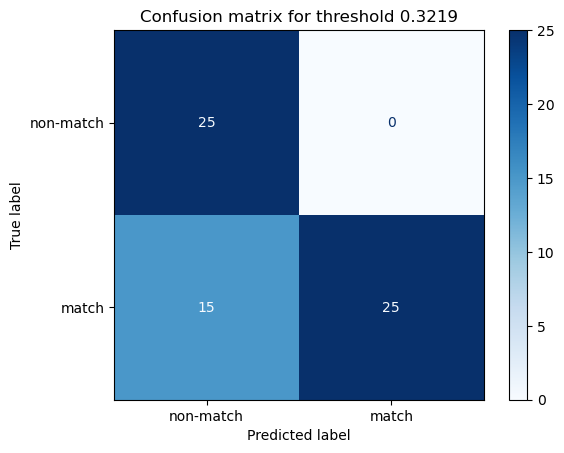

In [23]:
# List of people for within-person comparisons
person_ids1 = [14, 23, 42, 44]
# List of people for between-person comparisons
person_ids2 = [14, 23]

# Thresholds and function parameters
eye = "right"
f_value = np.pi
sigma = 4.42
threshold = 0.3219

y_true = []
y_pred = []

# 1) Intra-person: all pairs of different images of the same person
for pid in person_ids1:
    for i1, i2 in combinations(range(1, 6), 2):
        dist = compare_two_images(
            person_id1=pid, eye1=eye, index1=i1,
            index2=i2,
            f_value=f_value, sigma=sigma, threshold=threshold, verbose=False
        )
        y_true.append(1)            
        y_pred.append(int(dist <= threshold))

# 2) Inter-person: all pairs of images between two different people
for pid1, pid2 in combinations(person_ids2, 2):
    for i1, i2 in product(range(1, 6), range(1, 6)):
        dist = compare_two_images(
            person_id1=pid1, eye1=eye, index1=i1,
            person_id2=pid2, eye2=eye, index2=i2,
            f_value=f_value, sigma=sigma, threshold=threshold, verbose=False
        )
        y_true.append(0)             
        y_pred.append(int(dist <= threshold))

# 3) Confusion matrix
labels = [0, 1]  # 0 = non-match, 1 = match
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["non-match", "match"]
)
disp.plot(cmap="Blues")
plt.title("Confusion matrix for threshold 0.3219")
plt.show()

C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:635: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(path1)
C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:636: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(path2)


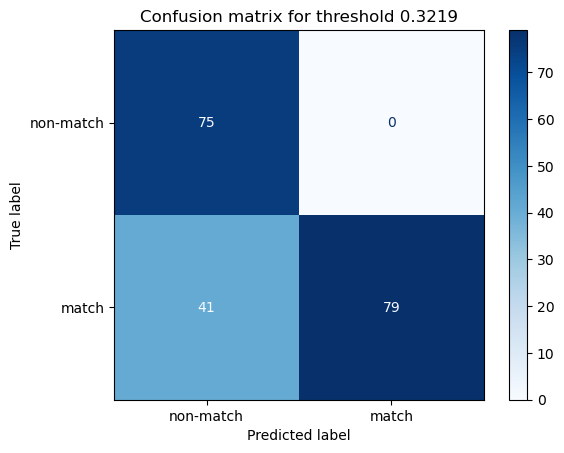

In [24]:
# List of people for within-person comparisons
person_ids1 = [1, 2, 3, 5, 6, 7, 14, 23, 42, 44, 45, 46] 
# List of people for between-person comparisons
person_ids2 = [14, 23, 42] 

# Thresholds and function parameters
eye = "right"
f_value = np.pi
sigma = 4.42
threshold = 0.3219

y_true = []
y_pred = []

# 1) Intra-person: all pairs of different images of the same person
for pid in person_ids1:
    for i1, i2 in combinations(range(1, 6), 2):
        dist = compare_two_images(
            person_id1=pid, eye1=eye, index1=i1,
            index2=i2,
            f_value=f_value, sigma=sigma, threshold=threshold, verbose=False
        )
        y_true.append(1)            
        y_pred.append(int(dist <= threshold))

# 2) Inter-person: all pairs of images between two different people
for pid1, pid2 in combinations(person_ids2, 2):
    for i1, i2 in product(range(1, 6), range(1, 6)):
        dist = compare_two_images(
            person_id1=pid1, eye1=eye, index1=i1,
            person_id2=pid2, eye2=eye, index2=i2,
            f_value=f_value, sigma=sigma, threshold=threshold, verbose=False
        )
        y_true.append(0)            
        y_pred.append(int(dist <= threshold))

# 3) Confusion matrix
labels = [0, 1]  # 0 = non-match, 1 = match
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["non-match", "match"]
)
disp.plot(cmap="Blues")
plt.title("Confusion matrix for threshold 0.3219")
plt.show()

C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:635: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(path1)
C:\Users\flang\AppData\Local\Temp\ipykernel_10892\2148817201.py:636: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(path2)


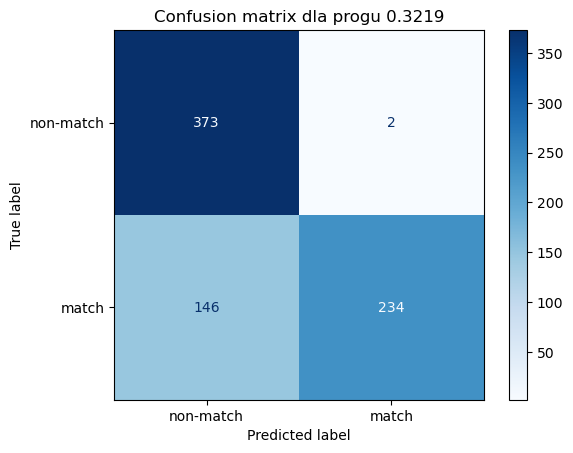

In [25]:
# List of people for within-person comparisons
person_ids1 = [x for x in range(1, 40) if x != 4] 
# List of people for between-person comparisons
person_ids2 = [14, 23, 42, 44, 45, 46] 

# Thresholds and function parameters
eye = "right"
f_value = np.pi
sigma = 4.42
threshold = 0.3219

y_true = []
y_pred = []

# 1) Intra-person: all pairs of different images of the same person
for pid in person_ids1:
    for i1, i2 in combinations(range(1, 6), 2):
        dist = compare_two_images(
            person_id1=pid, eye1=eye, index1=i1,
            index2=i2,
            f_value=f_value, sigma=sigma, threshold=threshold, verbose=False
        )
        y_true.append(1)            
        y_pred.append(int(dist <= threshold))

# 2) Inter-person: all pairs of images between two different people
for pid1, pid2 in combinations(person_ids2, 2):
    for i1, i2 in product(range(1, 6), range(1, 6)):
        dist = compare_two_images(
            person_id1=pid1, eye1=eye, index1=i1,
            person_id2=pid2, eye2=eye, index2=i2,
            f_value=f_value, sigma=sigma, threshold=threshold, verbose=False
        )
        y_true.append(0)             
        y_pred.append(int(dist <= threshold))

# 3) Confusion matrix
labels = [0, 1]  # 0 = non-match, 1 = match
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["non-match", "match"]
)
disp.plot(cmap="Blues")
plt.title("Confusion matrix dla progu 0.3219")
plt.show()

In [26]:
# 1. Precision: TP / (TP + FP)
prec = precision_score(y_true, y_pred)
# 2. Recall: TP / (TP + FN)
rec = recall_score(y_true, y_pred)
# 3. Accuracy: (TP + TN) / (TP + TN + FP + FN)
acc = accuracy_score(y_true, y_pred)
# 4. F1: 2·(precision·recall)/(precision + recall)
f1 = f1_score(y_true, y_pred)
# 5. AUC:
auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"Gini:     {auc * 2 - 1:.4f}")  # Gini = 2*AUC - 1

Precision: 0.9915
Recall:    0.6158
Accuracy:  0.8040
F1-score:  0.7597
AUC:       0.8052
Gini:     0.6105
